In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/erio/Dropbox/URP project/Code/PQC_composer')
from BayesOpt import quantum_obj
from QuOTMANN.optimal_transport import circuit_distance_POT
from QuOTMANN.structural_cost import structural_path_lengths_circ
from embedding import qc_embedding
from gate_distance import MUBs
import new_expressibility

import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector

In [20]:
np.random.seed(20)

num_qubits = 4
MAX_OP_NODES = 30
num_circuits = 300

encoding_length = (num_qubits + 1) * MAX_OP_NODES
bounds = np.array([[-.2] * encoding_length, [1.0] * encoding_length])

x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(num_circuits,encoding_length)
qc_list = [qc_embedding.enc_to_qc(num_qubits=num_qubits, encoding=x[i]) for i in range(len(x))]

for qc in qc_list:
    qc.lengths_to_in_nodes, qc.lengths_to_out_nodes = structural_path_lengths_circ(qc)

In [18]:
qc_list[0].draw()

┌───┐                                                           »
q_0: ─────┤ X ├───────■───────────────────■───────────────────────────────»
          └───┘       │                   │                               »
q_1: ─■───────────────┼───────────────────┼───────────────────────────────»
      │             ┌─┴─┐┌──────────────┐ │             ┌────────────────┐»
q_2: ─┼─────────────┤ Y ├┤ Ry(theta[1]) ├─┼─────────────┤1               ├»
      │ZZ(theta[0]) └───┘└──────┬───────┘ │ZZ(theta[2]) │  Ryy(theta[3]) │»
q_3: ─■─────────────────────────■─────────■─────────────┤0               ├»
                                                        └────────────────┘»
«                     ┌───┐                     ┌──────────────┐»
«q_0: ────────────────┤ Y ├─────────────────────┤ Rx(theta[6]) ├»
«                     └─┬─┘┌───┐                └──────┬───────┘»
«q_1: ──────────────────┼──┤ Y ├───────────────────────┼────────»
«                       │  └─┬─┘┌──────────────┐       │        »
«q_2: ──────────────────┼────┼──┤ Rx(theta[5]) ├───────■────────»
«     ┌──────────────┐  │    │  └──────┬───────┘                »
«q_3: ┤ Ry(theta[4]) ├──■────■─────────■────────────────────────»
«     └──────────────┘                                          »
«     ┌──────────────┐┌───┐┌────────────────┐┌───────────────┐     »
«q_0: ┤ Rx(theta[7]) ├┤ X ├┤0               ├┤ Rz(theta[10]) ├─────»
«     └──────┬───────┘└─┬─┘│                │└───────────────┘     »
«q_1: ───────┼──────────┼──┤                ├──────────────────────»
«            │          │  │  Ryy(theta[8]) │ ┌──────────────┐┌───┐»
«q_2: ───────■──────────■──┤                ├─┤ Rz(theta[9]) ├┤ X ├»
«                          │                │ └──────┬───────┘└───┘»
«q_3: ─────────────────────┤1               ├────────■─────────────»
«                          └────────────────┘                      »
«                                                                          »
«q_0: ────────────────────■────────────────────────────────────────────────»
«     ┌─────────────────┐ │                                                »
«q_1: ┤0                ├─┼──────────────────────■────────────────■────────»
«     │                 │ │ZZ(theta[12])         │                │        »
«q_2: ┤  Rxx(theta[11]) ├─■──────────────────────┼────────────────┼────────»
«     │                 │                ┌───────┴───────┐┌───────┴───────┐»
«q_3: ┤1                ├────────────────┤ Ry(theta[13]) ├┤ Rx(theta[14]) ├»
«     └─────────────────┘                └───────────────┘└───────────────┘»
«                                                                    
«q_0: ────────────────────────────────■──────────■───────────────────
«     ┌─────────────────┐┌───┐┌───────┴───────┐┌─┴─┐┌───────────────┐
«q_1: ┤1                ├┤ X ├┤ Ry(theta[16]) ├┤ Y ├┤ Ry(theta[17]) ├
«     │                 │└───┘└───────────────┘└───┘└───────┬───────┘
«q_2: ┤  Rxx(theta[15]) ├───────────────────────────────────┼────────
«     │                 │                                   │        
«q_3: ┤0                ├───────────────────────────────────■────────
«     └─────────────────┘

In [23]:
outcome_states = quantum_obj.get_QFT_states(num_qubits, input_states=None)

In [22]:
# for idx,qc in enumerate(qc_list):
#     if qc.num_parameters == 0:
#         print(idx)
#         print(qc.draw())

In [24]:
max_fid_QFT = []
for i in range(len(qc_list)):
    opt_param, opt_val = quantum_obj.maximize_QFT_fidelity(qc_list[i], outcome_states=outcome_states)
    max_fid_QFT.append(opt_val)
max_fid_QFT = np.array(max_fid_QFT)

In [25]:
dist_mat = np.zeros(shape=(len(x),len(x)))
distnorm_mat = np.zeros(shape=(len(x),len(x)))

for i in range(len(qc_list)):
    for j in range(i+1,len(qc_list)):
        res = circuit_distance_POT(qc_list[i], qc_list[j])
        print(res)
        dist_mat[i,j] = res[0][0]
        distnorm_mat[i,j] = res[1][0]

([188.8440914361917], [0.4541704940745351])
([180.85929868325394], [0.3859566766608066])
([202.85131598039357], [0.47284689039718786])
([200.55075820777435], [0.4747887268176476])
([230.52272523997405], [0.6590129366494399])
([212.35261130058072], [0.5362439679307595])
([185.54787507941725], [0.4164935467551453])
([203.16561436647598], [0.47725067974272023])
([184.04501201938365], [0.4225092103291636])
([181.42493803108513], [0.41649434809707336])
([168.45582840973404], [0.3594874699311439])
([210.21774021793945], [0.5491581510395492])
([205.8917038825911], [0.5031566566045726])
([195.50070308216732], [0.45223387250096536])
([206.17043398455723], [0.5163296618696651])
([204.1833175425301], [0.4652160345010938])
([204.1602945453071], [0.49100599938746303])
([188.06455039451208], [0.4159799831774211])
([131.82699429377877], [0.2481215778162597])
([174.53344140220716], [0.3860505228980472])
([201.5921122905615], [0.48870815100742176])
([187.3691553245984], [0.44014365826779056])
([222.409

([191.8904582297589], [0.4614970135395838])
([197.25878510897715], [0.4744078525949428])
([171.87943571802217], [0.35431753394768545])
([143.23902223379835], [0.2712860269579514])
([169.6827567983936], [0.35707650841412797])
([213.68822332015506], [0.5487627717518107])
([183.12580386221092], [0.4080343223311295])
([184.88977162355434], [0.4309784886329939])
([168.94307327802858], [0.36567764778794065])
([176.63694463078417], [0.38233104898438136])
([198.98571459233884], [0.47108360462201426])
([198.72893011946715], [0.4779435548808734])
([169.71511774237683], [0.36734873970211435])
([175.00908772822328], [0.3788075491952886])
([232.91180138036552], [0.6535123495520918])
([177.49157430634497], [0.37350920519011993])
([168.95055107425537], [0.34592659925113717])
([197.3859848358948], [0.4365980642244964])
([213.871221333127], [0.5312250902462172])
([193.03119510897565], [0.45344419804786384])
([170.12036539301891], [0.35799740192133617])
([191.63569584746654], [0.4467032537236983])
([188

([115.83272162640472], [0.3545537852047894])
([110.66255540250901], [0.46575149580180547])
([93.56693103892431], [0.2864001562256636])
([87.07547925872414], [0.33400644134531693])
([97.34870992436065], [0.3734127730125072])
([88.08704404860381], [0.30681659369071324])
([113.91235990732159], [0.35586491692384126])
([74.35801094109718], [0.26824679271680074])
([124.03665587816714], [0.3758686541762639])
([99.67868051394822], [0.4137761748192121])
([78.08169951399859], [0.2751293147075355])
([99.73449445081118], [0.3285062399565585])
([92.63237853647458], [0.3508802217290703])
([156.6808680029658], [0.42016859212380203])
([130.70616311682747], [0.3633754882313801])
([110.04555703379317], [0.3334713849508883])
([108.31768406236307], [0.3349340880097806])
([113.22724482930788], [0.3501151664480763])
([143.2077231712138], [0.3874667834718987])
([158.97189778012654], [0.4225728276983693])
([146.26086891202712], [0.40661904062281656])
([125.67897400038589], [0.36619747669110103])
([148.6218792

([83.82428260091659], [0.30977192387626223])
([102.17530644592132], [0.41840829830434606])
([131.79494762342551], [0.3767722916621655])
([74.91132602247885], [0.2579591116476544])
([85.47024527809947], [0.28461620139227256])
([184.17156913360338], [0.4574554623288708])
([121.9007445078629], [0.3586370829887111])
([95.0478955579412], [0.36458724801665204])
([94.30121505017807], [0.33228053224164217])
([112.77979538790073], [0.33837322348605076])
([167.01652465256515], [0.451884536397633])
([84.84916066939307], [0.2989751961571284])
([118.25272503898185], [0.34790445730797837])
([117.22929184248072], [0.3448934740879102])
([164.07015643009933], [0.42134092560374753])
([112.2687103106928], [0.3402082130627053])
([130.11158254660046], [0.35843411169862377])
([80.44224985010807], [0.2834469691688092])
([79.0682833739086], [0.29219616915709007])
([117.95475827869578], [0.35043006024567963])
([135.44484817169436], [0.3800360498644622])
([140.15570080133122], [0.3932539304189989])
([93.6351882

([116.02840962437503], [0.303104518349987])
([96.78806288710169], [0.24441430021995375])
([146.47943012000437], [0.4931967344107892])
([120.91643442246855], [0.3664134376438441])
([136.10387112166796], [0.4434795409634017])
([145.10579719824594], [0.45803597600456425])
([107.51294001147963], [0.2670465474701431])
([125.70853301556079], [0.34012048976071646])
([123.6635209249472], [0.3638232448512716])
([123.0558138906229], [0.3452744497492225])
([123.63645228764676], [0.2997247328185376])
([104.09409985994854], [0.2719281605536795])
([149.49354703796533], [0.47685341957883676])
([110.37248607553225], [0.3068459440520774])
([121.99669275773878], [0.31329402351756236])
([123.28598773456935], [0.30128540502094175])
([111.13974270384472], [0.2928583470457041])
([123.47847150340975], [0.34328182236143945])
([106.35223561509927], [0.26416352611798133])
([119.00279974331025], [0.2817301130286701])
([108.95624444969178], [0.2974508447985033])
([123.53300174804686], [0.3599446437880154])
([124.

([101.78173164536939], [0.35451665498212953])
([86.92144961532502], [0.2832240130834963])
([106.74734678954289], [0.3234768084531603])
([105.48578602695281], [0.3261774459707879])
([136.17160595267748], [0.3684296697853829])
([100.44810784693061], [0.29841980940858764])
([109.82906062062742], [0.32001474539809854])
([108.80461960159651], [0.40705057838232894])
([135.57790224880154], [0.36682332859524225])
([99.47582880650756], [0.3075937810961892])
([103.95826838420284], [0.3500278396774507])
([113.65811120581884], [0.42520804790803896])
([100.30397613665063], [0.3009420226122131])
([82.10831110724747], [0.2591802749597458])
([104.78266155642723], [0.3342349650922719])
([88.23650202762639], [0.2756529272965523])
([192.20118025935395], [0.4446013885249918])
([155.33544812866526], [0.39890972811675723])
([123.3094935944006], [0.34921974963013486])
([108.27552268993206], [0.3216741612891625])
([81.60823607440354], [0.24979564148883854])
([108.5706513682071], [0.33917729262170293])
([104.1

([91.91411777029093], [0.2813410400070124])
([106.17323205690747], [0.312366084309819])
([110.46443231758558], [0.38475942987664774])
([137.99096400719594], [0.38014039671403843])
([103.33636030545163], [0.3684005714989363])
([113.0446492575567], [0.34255954320471727])
([96.68438970517808], [0.329194381018652])
([101.97242800521755], [0.3471992781927735])
([93.96229591621177], [0.29659815630117353])
([90.11032315336732], [0.30006767616838936])
([116.0808988195941], [0.3318493391069013])
([94.95794813725159], [0.3028961663070226])
([104.79935497855888], [0.4019921556523165])
([107.4663967776001], [0.3464422849052227])
([102.81656672626077], [0.3665474749599315])
([103.42385485578531], [0.33341023486713517])
([89.56725536825094], [0.3193128533627485])
([116.10112319754028], [0.33828998600681903])
([94.5019508661375], [0.33298784660372627])
([94.01361458721277], [0.3165441568593023])
([101.0732384783678], [0.36033240099239855])
([95.66964710233206], [0.2899080215222184])
([99.092522298283

([104.16099599931611], [0.38967824915569055])
([120.0668164808393], [0.3465131788768811])
([72.7443452023752], [0.23702947280017989])
([91.73172893559016], [0.305466962822478])
([98.21481598436495], [0.310021515102162])
([97.743622984726], [0.2991846433569819])
([87.27488005900575], [0.31863775121944404])
([88.48671568671541], [0.3047063212352458])
([85.39099173605278], [0.2752772138492997])
([90.65571799554647], [0.29539171715720575])
([92.20719070025537], [0.3037127493420796])
([107.34738475684397], [0.4224611757451553])
([81.09578028467958], [0.26711390080592745])
([93.9710171992611], [0.3430851303368423])
([146.40544967580772], [0.3926131661995379])
([143.15409024626882], [0.3979819022693044])
([149.28685005490627], [0.41503155422548305])
([109.69111559370711], [0.4748533142584722])
([113.4020486633256], [0.3402401700069774])
([92.98403203474344], [0.3522122425558462])
([111.72047747476037], [0.335194951919473])
([185.3530716001903], [0.449340779636825])
([130.54791494898433], [0.3

([113.8689181881824], [0.49293903977568143])
([71.22832389854237], [0.37214380302268735])
([174.06151933385067], [0.6062748844787555])
([249.5355870625189], [0.6633056540736814])
([140.00340661264286], [0.5370287940646064])
([175.68722729305793], [0.6049835650587395])
([94.90713460147127], [0.44937090246908734])
([89.70964172148162], [0.41822676793231517])
([145.91797276907505], [0.5458958951330903])
([187.8711498983559], [0.6188114291777203])
([87.87881232715289], [0.4365564447449224])
([122.86688821775445], [0.4898998732765329])
([246.92791856542019], [0.6802421999047388])
([109.51391356947346], [0.4740862059284566])
([127.1357827495129], [0.5206215509808062])
([87.28888276743136], [0.4198599459712908])
([102.90865821002251], [0.45194843306992755])
([130.1826438791702], [0.5190695529472495])
([128.4271304748565], [0.5259096252041626])
([174.57522098610858], [0.601154342238666])
([129.1980389345657], [0.5019348831956709])
([145.8162405091312], [0.5523342443527697])
([71.37608027420299

([68.65283719206126], [0.37149803675357823])
([90.73063049558489], [0.4364147690985324])
([129.76046886420968], [0.5242847226836755])
([138.84230158649527], [0.5325749964959542])
([89.94709997060012], [0.43264598350457])
([164.74943867760638], [0.5805124689133417])
([80.65326428363441], [0.4006620182992271])
([131.28012666338125], [0.5234454811139603])
([84.07263564368417], [0.39194701931787507])
([99.22346897497633], [0.46258027494161463])
([119.46564137947793], [0.5028015209573986])
([102.38131275077977], [0.463054331753866])
([154.46502571000468], [0.5708241896156859])
([111.08814301903202], [0.4741277977764917])
([61.72272417539813], [0.3400701056495765])
([113.65969442222139], [0.4920333091871055])
([87.79293560273878], [0.4361298340920954])
([113.50731034087129], [0.4913736378392697])
([86.68085016568436], [0.4306053162726497])
([142.1079391031439], [0.5382876481179694])
([81.0027537004617], [0.39590788709903085])
([96.24166918998912], [0.4418809421027968])
([80.82565381413889], 

([120.51470209422416], [0.37649079067236546])
([92.81645456659743], [0.3308964512178162])
([82.38686396865462], [0.30079176330286467])
([104.6213213730016], [0.3602662581714931])
([118.24571601011849], [0.3937586280723226])
([62.46509433582566], [0.25238421953868956])
([68.81507218135633], [0.2606631522021073])
([86.98771616545636], [0.30651062778525856])
([94.64104664644204], [0.33740123581619264])
([88.5138925019458], [0.319314186514956])
([75.07953535228087], [0.32973006303153657])
([88.2175741783228], [0.3182452170935166])
([67.69004967683931], [0.2734951502094518])
([157.95713613897638], [0.4558647507618366])
([138.37695943620494], [0.4151723955481697])
([153.8565648741558], [0.46161585620808826])
([83.18540913098609], [0.406575802204233])
([120.10201179168017], [0.39133923685786953])
([67.12897130729468], [0.282529340518917])
([119.6741353837559], [0.3899450484970866])
([184.23698640208727], [0.477174271955678])
([132.6841578245468], [0.4102787811519691])
([148.51655226923725], [

([123.0402335972819], [0.4285622904816505])
([129.34398998123913], [0.3378892110272705])
([218.72943132061695], [0.4635080129701567])
([104.60802091676375], [0.2935129655352518])
([123.81587414803477], [0.32068343472684474])
([114.17488138534137], [0.37202633230805254])
([108.45199473244398], [0.3496195832767375])
([86.5071395827378], [0.23831167929128869])
([137.09805978511318], [0.343346004971483])
([117.08387154813913], [0.3942217897243741])
([90.58054928717951], [0.2614157266585267])
([179.27389686449666], [0.3908303833976382])
([101.09926542281343], [0.30945597007289083])
([91.13021483425713], [0.2681088991887529])
([108.27748969811934], [0.3566452229845828])
([97.95609000969202], [0.3028945269316388])
([86.1727279176914], [0.24869474146519882])
([90.10874363082276], [0.26510368823425345])
([134.07924659309313], [0.3472655959417072])
([90.65877616864077], [0.2567509945302769])
([91.43057277767815], [0.2541856346335228])
([121.42533717094514], [0.42785531067986304])
([118.830920483

([93.25995962701867], [0.2641176993118626])
([94.89581666605379], [0.2819245890257094])
([132.46500616034066], [0.5017613869709873])
([107.72803104777273], [0.29147194547557553])
([178.63994043282565], [0.3980390829608414])
([85.3071346970928], [0.24387402715006515])
([110.47003000744992], [0.3638670290100458])
([124.35397248614947], [0.333478070491149])
([98.13892500507605], [0.29739068183356376])
([125.21848753049463], [0.4517261454924048])
([115.9863629443381], [0.3138159170571918])
([145.982752146964], [0.3567515937120332])
([135.2299840396203], [0.33316083774235106])
([127.23755584640139], [0.45360982476435435])
([113.25551338731566], [0.37304187545229134])
([97.2036806442211], [0.28322750770460686])
([91.82827356400895], [0.25765508856343694])
([115.19752904755906], [0.37943850147417335])
([111.13957065513154], [0.2928578936894111])
([116.58966675468497], [0.39255780052082473])
([113.653517174163], [0.3280043785690129])
([104.20002840788308], [0.3359124062149681])
([106.839922084

([186.00872645832646], [0.44036156831990175])
([167.69083833453644], [0.4234617129660011])
([138.85951980583624], [0.3790868681568012])
([124.13031610559312], [0.35486082362948296])
([107.65140364000892], [0.31671492686086766])
([155.86251793392245], [0.4143075968472155])
([141.9895987482337], [0.37414914031155133])
([86.83044653656268], [0.27408600548157414])
([100.56322000497038], [0.307815182139487])
([101.63079180203965], [0.30193342781354626])
([123.14692609028131], [0.35881971471527185])
([103.65283041372814], [0.35693123420705286])
([122.1391134520611], [0.35249383391648226])
([94.56138530611791], [0.3016312130976649])
([95.45507424526065], [0.3013102091075147])
([89.64097042936217], [0.30182144925711163])
([93.84189745157934], [0.34679193441086237])
([116.43524036689041], [0.33286232237533])
([73.33628401554532], [0.23641613157816033])
([79.08265839884088], [0.2604830645548119])
([91.80629444185506], [0.2868050435546862])
([95.36825123566598], [0.28899470071413935])
([87.437630

([143.92100049378516], [0.3825651262461062])
([141.07949489850404], [0.362299678732676])
([111.47753546807728], [0.33446605300953286])
([108.90864414979629], [0.36669577154813565])
([83.9892164881686], [0.2651174762884109])
([112.00057298250768], [0.39464613454019615])
([85.22650550407211], [0.2507399397001239])
([119.052435844264], [0.33404162694799094])
([114.92356333577344], [0.3912957553141758])
([98.34464780222117], [0.2893340623778205])
([102.68754826956997], [0.32755198810070174])
([92.10313352006386], [0.2658099091488135])
([112.97587720129192], [0.39350706095887117])
([86.39834025058107], [0.2727220336192584])
([112.44384960150406], [0.40564159307901887])
([149.52487977662508], [0.4009784922945162])
([219.93868373067696], [0.4760577569928073])
([108.1560070477655], [0.3121385484783997])
([134.54140635370743], [0.35763265910076397])
([114.67950983413931], [0.38612629573784274])
([102.59222570057216], [0.3416324532153584])
([123.93885542429953], [0.3510021394061159])
([157.05314

([79.92822272090886], [0.23980864902762936])
([111.14561726931692], [0.4057890371278456])
([155.06561337425833], [0.3699966914203253])
([91.178480477833], [0.28781086009416984])
([99.65218071940997], [0.29318087884498367])
([114.38972816486829], [0.422726268162854])
([96.02624072669208], [0.3128909766265627])
([121.88805738516852], [0.3211806518713268])
([161.40420060554607], [0.38817749063382895])
([104.95825910453316], [0.3058224332882668])
([82.03956283230293], [0.25111589480349844])
([117.7181677138734], [0.463274961487105])
([125.99491272517814], [0.35027776682006706])
([180.88547750615453], [0.41213369219903057])
([95.4473616220469], [0.2808101253958426])
([106.03909735713718], [0.36104561578868627])
([126.60313914073147], [0.3487689783491225])
([95.21448396225283], [0.2974523085356227])
([106.248148340431], [0.39748652577789384])
([129.42309590918185], [0.3598084401144894])
([155.89154987562392], [0.39041209585680925])
([136.71930563225314], [0.345250771798619])
([94.46569697704

([110.65549238587582], [0.3104811795338827])
([120.94354739347186], [0.3362344937266385])
([95.60497091450674], [0.3049600348150135])
([114.14016522915337], [0.40691681008610825])
([122.73755293117492], [0.32341911180810257])
([112.76276071184472], [0.41671382376882754])
([91.8936069835885], [0.29006820386233745])
([150.17804995287], [0.3761033056670924])
([102.71712832976364], [0.33469250025990105])
([98.5907465477369], [0.3319553755816057])
([106.33552186473067], [0.354097641907195])
([95.06376937880596], [0.27435431278154676])
([85.32537385184665], [0.2638385091275407])
([106.90422131208487], [0.3027590521441089])
([171.39844611409035], [0.39648032873951045])
([147.58645156719794], [0.3636029848908547])
([125.0000817818574], [0.3322702865014817])
([115.0045649943513], [0.3197235612853803])
([110.52784633651912], [0.3159744034777561])
([144.15720710702385], [0.3733675397747315])
([143.3443064961792], [0.36811583589157476])
([86.37199404779271], [0.2643770861579207])
([91.469595324685

([133.48063182671706], [0.3548129500975998])
([119.34909922889267], [0.3477537856319716])
([160.97203468557262], [0.3933822939530123])
([114.98337869180922], [0.3828950339387586])
([146.19396812477407], [0.4712893878941781])
([113.40656926591285], [0.3369179122576139])
([115.14769751371765], [0.32012148321856443])
([137.81577769050904], [0.421841988645574])
([132.0055699519903], [0.36037556634449974])
([135.90638094168423], [0.39599761346644585])
([108.16379827797968], [0.2850165962529108])
([151.67514699785553], [0.330663062999467])
([122.24826595757867], [0.32212981807003593])
([124.97551804282566], [0.3676831951833646])
([124.83736809002691], [0.35354678020398445])
([140.0661691199263], [0.40041786483683894])
([107.1572381018927], [0.2618700833379587])
([113.44250898940182], [0.2685665459029398])
([115.38010687419741], [0.31498800675456573])
([113.33874177417528], [0.343450732649016])
([120.74005690280879], [0.3451688304825865])
([137.0693811446815], [0.4326685010880097])
([116.9716

([114.32791142073742], [0.2839739478905549])
([135.24041056757667], [0.42689523537745155])
([117.43020292980384], [0.3121483331467406])
([122.28907374900871], [0.3431231025505295])
([105.29548609270515], [0.27040443269826686])
([104.99622774520913], [0.2696359212768596])
([139.63209922812635], [0.3991769560552496])
([125.20265420715837], [0.36480959850570616])
([90.02398152326185], [0.23118639322871554])
([113.69147974622855], [0.2919657928768068])
([160.41375883204068], [0.5652352319663165])
([113.17264466267628], [0.2811044328432098])
([109.60398465320758], [0.2635978466888109])
([115.94199124057525], [0.30551249338755004])
([138.10418193542162], [0.4184975210164292])
([126.2225872149533], [0.35746980236463677])
([114.49912808376692], [0.2843992252453227])
([118.83132319085738], [0.3334212210742351])
([122.33741827288775], [0.34973532953941605])
([101.4463744135343], [0.26731587460746853])
([146.03100021658625], [0.5028615709937543])
([147.3763551849052], [0.4854293649041673])
([93.4

([114.0586129246014], [0.3927638186108863])
([119.18364734543516], [0.41041200876527256])
([159.477256744451], [0.47378864154620026])
([176.37770875591465], [0.513921062808609])
([148.8709743758091], [0.455680974520383])
([147.10211484011015], [0.47421700464252137])
([178.17379515759134], [0.5241947489190684])
([114.88554089235991], [0.39561136670922836])
([73.28672123579345], [0.3127901034391526])
([140.84501084322955], [0.4690143551223095])
([71.82634427906784], [0.3065571672175323])
([114.46194594115065], [0.4129218829045838])
([129.98987152253497], [0.4281616321559122])
([134.5941385642538], [0.43856024295944535])
([105.48754011411269], [0.4046319145152002])
([58.900930864315384], [0.2586777815736292])
([166.08886007703836], [0.5083834100919448])
([64.2352263405621], [0.2949275773212217])
([102.81296297493509], [0.3894430415717238])
([168.21263493688863], [0.4854621498900104])
([88.05578783763914], [0.346539897039115])
([77.05827843005417], [0.3155539657250375])
([85.2774377546214]

([171.91918897131717], [0.5107521953990408])
([89.30764690224767], [0.3560910961014659])
([130.49755481596685], [0.42521197398490335])
([132.8723069349879], [0.432949843385428])
([182.61683377968205], [0.5123929118397363])
([131.90170072391686], [0.44411347045089844])
([163.66564086406936], [0.49595648746687665])
([93.09950825497822], [0.37121016050629263])
([77.44116122621142], [0.3259308132416305])
([139.23595298651622], [0.4586164459371417])
([151.9750020306123], [0.46992888692211593])
([142.95461872881518], [0.44203654523443153])
([91.83168228183469], [0.3435528704894676])
([163.76901767147993], [0.5063977046118736])
([124.10301927167511], [0.42735199473717317])
([177.4214588100502], [0.49781554099340686])
([89.4585261783109], [0.3614485906194379])
([93.64560378031523], [0.3118401724286221])
([81.60487007608094], [0.3052931914555965])
([99.08704532964367], [0.32286427282386326])
([88.91386577595709], [0.3132976242986508])
([122.2932199324671], [0.38204692262563916])
([194.171130082

([139.99015156659686], [0.39646035561199916])
([184.37877099361182], [0.46560295705457533])
([122.15645915145856], [0.3559337387863012])
([83.13133803376044], [0.3229655712267306])
([114.7195820137464], [0.36211989272015915])
([95.2791101413755], [0.32080508465109603])
([120.35762680452513], [0.3647200812258337])
([127.07856212025801], [0.3850865518795698])
([102.43680891585173], [0.3527438323548613])
([92.39639785341235], [0.3255687027956743])
([116.32332559347091], [0.35249492604082094])
([129.1006515147553], [0.3912140954992586])
([101.83517669634097], [0.45381094784465675])
([141.34375141640967], [0.4118407675303313])
([144.95371228522632], [0.40671636443666204])
([119.42223215483222], [0.37307788864364955])
([81.74283325155425], [0.30207994549724415])
([88.37427606918371], [0.3008998163744763])
([129.91640073767343], [0.3785442911936872])
([80.5968444898836], [0.2713698467672849])
([87.02238476960378], [0.29966385939946205])
([112.08839718917736], [0.35016681408677713])
([94.99210

([153.10041676591115], [0.3965304759541858])
([147.12066418233977], [0.37463881890078876])
([133.81378383020242], [0.3556985216113834])
([114.34950084150441], [0.31790242102169697])
([153.9485694021349], [0.3953481494661913])
([101.08419566948506], [0.29739392665338354])
([90.24840444464972], [0.318000015661204])
([113.72252475255438], [0.3251072748786574])
([110.05157254623184], [0.3877786206703024])
([91.13801836625663], [0.2789654679101825])
([112.91745859387541], [0.3197888943468575])
([119.10030744340226], [0.33417594681089297])
([102.65578660211654], [0.33093419278567543])
([104.67744442182469], [0.3776242583759909])
([137.69274815965787], [0.3660094315780379])
([115.94420458831071], [0.4337605858148549])
([87.82510073546351], [0.2801438619950989])
([159.6347580327585], [0.4031180758402992])
([94.69596868458183], [0.3119103052851838])
([91.77295580261604], [0.3124717596275656])
([91.01991343296757], [0.3064643549931567])
([100.5109870305417], [0.29286418132442216])
([89.636910301

([102.04481202295948], [0.29450162199988295])
([133.18777015248662], [0.35095591608033355])
([87.63240484377113], [0.29181619994595775])
([99.01652803538603], [0.3448851551215117])
([105.30919766082772], [0.2982418512059692])
([132.2595169814417], [0.35467824344714843])
([140.77410545089074], [0.37751167994339163])
([77.23612637108755], [0.24380090394913995])
([136.96740323488538], [0.36730330714638065])
([109.91662288434938], [0.3233792965117663])
([171.8288727437395], [0.42332809249504677])
([102.2635697050888], [0.3443217835188174])
([109.93440722619101], [0.37014951928010426])
([85.72637758353835], [0.3129842189979495])
([109.12516221299298], [0.35178969120887477])
([195.7534680044407], [0.5027053621069355])
([116.13069683340441], [0.3743736197079445])
([84.82498557553302], [0.3134700132133519])
([96.33988408892444], [0.3394640031322214])
([89.88685111616793], [0.3204522321432011])
([152.4467992601474], [0.44850485219225483])
([159.67742218498572], [0.45221586571788647])
([114.7011

([84.27940047765944], [0.30770135260189646])
([151.99466791766653], [0.4428749065200074])
([185.0411927102412], [0.4792571683766931])
([141.23543654675697], [0.4237486845087217])
([79.81678863479353], [0.322492075292095])
([125.95524654123355], [0.4104113605123283])
([86.84688541786153], [0.3024969885679607])
([117.32259309941246], [0.36651856638366903])
([134.47675108917525], [0.420108563227664])
([94.16560916108152], [0.33570627151900706])
([92.13273872512127], [0.33637363536006304])
([131.850451082752], [0.41190393965245853])
([126.08071152227208], [0.3938791362770138])
([89.01070989306288], [0.4149683444898036])
([124.42144093053739], [0.3733016529569078])
([153.5392348556114], [0.4431146749079694])
([111.9912240893339], [0.36102909119707893])
([70.110476177614], [0.26893163090761035])
([96.48516293078028], [0.33997590884700574])
([131.28849391705128], [0.39390487223837767])
([92.84822694955703], [0.32340030285460475])
([93.09355006017365], [0.33188431394001305])
([119.366976863376

([116.04974646794061], [0.3168161246736025])
([153.66982686171875], [0.3880551183376735])
([102.7505027348949], [0.29653824743115403])
([119.62342562995305], [0.4119263967973589])
([112.04132469362789], [0.31436959790580205])
([115.3225528613086], [0.3971162288612553])
([88.61755055774591], [0.2658792395971974])
([127.42596309449006], [0.3542562221142341])
([119.69048207285644], [0.3297258459307339])
([114.99041171383146], [0.3629747844502255])
([113.02616766157838], [0.3982599283353712])
([148.71775521682025], [0.3884998830115471])
([118.73100161446462], [0.433483028895453])
([97.87967652579077], [0.305778433382664])
([150.59595663782764], [0.3740585112713055])
([104.61923067958998], [0.3372637997407799])
([112.33267390348225], [0.37406817816677396])
([92.57341394874081], [0.3049190182764847])
([108.310125253993], [0.30963443468837326])
([103.55753684676569], [0.31698052294694107])
([107.17727194816906], [0.30072186292976716])
([188.83830464979903], [0.43351309607391875])
([170.124714

([154.43233645495064], [0.39325779591278487])
([108.11008049258626], [0.35226484357310595])
([103.29434104298839], [0.28455741334156576])
([121.0871572843725], [0.3335734360451032])
([162.74661704599075], [0.39453725344482593])
([109.59109993761047], [0.310368450687087])
([153.18119204194392], [0.3967396841283187])
([105.40866341516715], [0.34346257222276677])
([104.30902491928461], [0.3551550048324296])
([123.1905391072612], [0.342481343083851])
([143.4478783167756], [0.3779917742207524])
([130.91968582687932], [0.3449794092934895])
([102.62967060522807], [0.31734592023880037])
([144.92065669900128], [0.3818726131725988])
([112.09354960342482], [0.3235023076577916])
([167.75555720298826], [0.40668013867391084])
([101.77134003849622], [0.33521521751810335])
([122.54866401110978], [0.37511069486106446])
([195.50861896010048], [0.48166695974402685])
([110.97981642285175], [0.3396994686955976])
([93.60784184634862], [0.32604612276680117])
([90.92085157607464], [0.30276673851506714])
([105

([92.7240939038536], [0.31929784402153455])
([147.41173984231503], [0.409818570593036])
([190.64176721905983], [0.4735264958247884])
([132.03526909879412], [0.37745931703486024])
([85.88066016404895], [0.3253055309244278])
([121.84858905265797], [0.37677362106573276])
([98.63431942107916], [0.32488247503649265])
([109.20420888355456], [0.32443318147223577])
([123.29550341998444], [0.3662968016042319])
([92.6373832758963], [0.3119103814003242])
([90.5579937217333], [0.31183882135583096])
([128.17677257883975], [0.380798492509922])
([119.6580855448111], [0.3554904502222553])
([105.50764144684969], [0.4567430365664489])
([136.53041541827466], [0.3903099354438956])
([147.98100755529603], [0.40766117783828115])
([110.23921492124002], [0.33743255255965726])
([97.92980542191002], [0.35328212634166684])
([108.72030848514105], [0.3620389892945089])
([148.30455016383968], [0.42396955449925583])
([88.24402216106921], [0.29065883452262586])
([91.26087066609831], [0.30727565880841184])
([124.811934

([136.87362879864315], [0.3344907839654035])
([119.17685311766192], [0.30095164928702495])
([97.69527641413023], [0.2667083713189468])
([83.22273600481452], [0.2313670725738518])
([105.20365133044896], [0.2924760948858742])
([122.12965947931417], [0.3008860790325552])
([134.7487679180228], [0.3266636798012673])
([125.06999023192259], [0.3158333086664712])
([115.987632459789], [0.3056327601048458])
([138.97539778015442], [0.3396270717990088])
([95.34237621534005], [0.2650608179464555])
([118.18623648586201], [0.38928272887306326])
([98.11159949822077], [0.2654534618458354])
([126.1644289896989], [0.41556136030862606])
([97.40029653536536], [0.2810975368986013])
([98.09367478521679], [0.26305624774796665])
([114.78476022732251], [0.3051163217100545])
([116.92723037136142], [0.35432494051927704])
([119.41307030321222], [0.40206420977512525])
([121.46384586820409], [0.3067268835055658])
([136.59703014059357], [0.4757820624890058])
([115.67395090281951], [0.3470565583642949])
([137.68220373

([108.32644554507598], [0.3218254472521568])
([160.15034207118566], [0.3648902758514141])
([110.44020117361309], [0.29356778621375085])
([121.29408869224879], [0.40839760502440664])
([116.35258493259914], [0.3634882378400472])
([94.21994169702018], [0.25492408467808486])
([134.60005581677635], [0.3316089081467759])
([120.02266804493583], [0.3749536646202305])
([90.30214072631172], [0.2400375883208711])
([109.41680780340812], [0.29084744232697524])
([148.1449635299627], [0.34800320303021537])
([96.5105162881535], [0.26347397294063196])
([114.91966014716213], [0.28780280527714025])
([117.15061052376811], [0.36598128873404584])
([118.10031705228751], [0.3848169340250488])
([106.07179579489309], [0.2844510479884502])
([104.35327132649594], [0.2657328019518613])
([105.6897104180886], [0.2691360081947761])
([105.73016298239287], [0.3141121894901749])
([129.1623208773225], [0.3289083801306913])
([108.49301332230071], [0.30162083214428886])
([138.91092533750353], [0.3263117813894844])
([115.84

([152.04948850120314], [0.32677732323490893])
([194.23586463369458], [0.5118204601678381])
([151.11829423173677], [0.3443114473268097])
([165.6425622516486], [0.39523398294356626])
([152.26835052962335], [0.3368023679044975])
([159.22219514519097], [0.3521835769634837])
([176.73063145186129], [0.4284378944287546])
([175.2411067377384], [0.4317346803097768])
([162.01827060018707], [0.35836821632423593])
([146.4307380052579], [0.3238901526327315])
([220.65320144632713], [0.6368057761798763])
([148.8098880929232], [0.3198149325014468])
([141.0547920698129], [0.2947853543778744])
([172.93778950720812], [0.39108500566985105])
([191.4869503586235], [0.48761637473548136])
([152.95826824963666], [0.3678650030053791])
([162.30885440299315], [0.3488262505974493])
([181.33981053659804], [0.4326886436091578])
([184.4795333866178], [0.4472231112402855])
([160.28753059370896], [0.3624774549835119])
([208.43147932295466], [0.5902902274793391])
([205.42284830496416], [0.5608049366774889])
([159.123897

([135.95539790230782], [0.33494801158489235])
([131.45678325320742], [0.3186831109168664])
([116.63007526041486], [0.2945203920717547])
([115.74404581823609], [0.3049908980717683])
([134.35579987521976], [0.32833773185537574])
([91.52487987093676], [0.2544478172669912])
([105.21295959246747], [0.34655125030457])
([96.9943905458162], [0.2624307103512343])
([135.05185736437497], [0.4448348398036065])
([106.0339761992452], [0.30601436132538296])
([111.57853522509834], [0.2992183835481317])
([124.77633686248252], [0.3316755365828881])
([119.35507472155112], [0.361682044610761])
([123.3688456001961], [0.4153833185191787])
([135.37248179116932], [0.34184970149285177])
([130.03812460380956], [0.45293669315154844])
([93.00870946135376], [0.27905403378744])
([153.6936042636976], [0.3696334878876806])
([107.96498396583641], [0.3338434878349919])
([104.43400914136001], [0.3331228361765869])
([125.11291799496288], [0.3949271401356151])
([91.01811910765402], [0.25073862013127823])
([94.445652796408

([113.96557209132003], [0.35603115305004684])
([96.30314156463612], [0.2605604479562665])
([139.8974090344945], [0.3446597906737977])
([117.06967011181561], [0.36572842896537194])
([117.2769720576262], [0.311741020886832])
([96.52303371463096], [0.25657372066621725])
([141.33418980897213], [0.3320042043903503])
([98.16280990958614], [0.26798473903790915])
([119.83227957049017], [0.30010588422361667])
([98.14230287468389], [0.3065988843320333])
([119.51751556815286], [0.38943472000049795])
([103.78505911015982], [0.27831874258557204])
([112.76878284253158], [0.28716267594227546])
([115.42313905586829], [0.29392192272948375])
([95.57503567394106], [0.2839424708079057])
([125.22113488093353], [0.31887225587199775])
([104.91578885872983], [0.291675810004809])
([148.74514785011698], [0.3494130792814587])
([124.49794433689975], [0.3929859354068804])
([90.22383038249103], [0.303783940681788])
([100.63990745497256], [0.34266226576429193])
([152.53017270276752], [0.43197443416246817])
([149.677

([141.4015865630586], [0.39674968171453034])
([183.0190498668724], [0.45834973670641715])
([138.03561653907892], [0.3983711877029695])
([96.98919156147748], [0.37203372290555226])
([119.97985472567959], [0.37481991479437543])
([91.92646608501343], [0.30611543817853293])
([134.05431436631773], [0.4022031634152946])
([121.29654411924795], [0.36392602496023996])
([106.06912726724579], [0.3611478626736322])
([78.45815508934422], [0.273278143815201])
([101.61415331397625], [0.3048729472366523])
([128.18033848481207], [0.38457947340177645])
([108.2529414750487], [0.4754191544797922])
([135.87331577838353], [0.3921307814671963])
([133.90932806087554], [0.37228058954927873])
([113.26086641275441], [0.3502191292911392])
([91.84611964378644], [0.3353271984073985])
([109.91961033921574], [0.37009969811183735])
([137.4007573796111], [0.39653898233653995])
([90.36156274311583], [0.3009043048388806])
([82.07496230525341], [0.2794516932422656])
([114.10685158330868], [0.35283503890942697])
([98.73843

([102.41685069697368], [0.30728128021894296])
([105.53816052013087], [0.3807292948056669])
([115.22085667572921], [0.3357251068640129])
([98.47853151995656], [0.355261657719901])
([95.84427284731373], [0.2994197839653662])
([118.83499222268095], [0.34295813051278773])
([121.28034842037073], [0.34671340314571397])
([92.45150885806557], [0.3045174863572647])
([103.79513459305448], [0.3835740376683462])
([129.4615286822837], [0.3502746988157026])
([105.2417261421498], [0.4036890147378205])
([94.903002121376], [0.3092310267884523])
([137.37583188321452], [0.35278847427635984])
([90.48575998975966], [0.30466585855137934])
([103.05392513890058], [0.3589478409575081])
([93.78448669146792], [0.3229493343370108])
([115.8997941208319], [0.34432499738809236])
([70.3098135132171], [0.22427372731488707])
([111.43065075112621], [0.32468138330747726])
([183.39301200869096], [0.4341690625205752])
([169.51523587149518], [0.42806877745327065])
([128.11107295848723], [0.3497435789202491])
([119.046404640

([144.6687271272102], [0.3949460200033038])
([131.90245149308944], [0.3600940526701869])
([98.36668069731157], [0.3171072878701211])
([135.69003480992419], [0.3704341654652585])
([109.9730073393547], [0.32995201721978606])
([167.30371546203565], [0.4189925255748452])
([92.19698790906298], [0.317482740733688])
([147.99518397688823], [0.4077002313412899])
([161.54427639048936], [0.42941062304755273])
([107.33148908180229], [0.335306120218064])
([99.35787372001914], [0.3500982160677206])
([105.51801758663153], [0.34755605265688894])
([104.14507185574703], [0.3848672278482891])
([125.64306634340284], [0.3845823885626043])
([134.2340705043252], [0.39112491405689137])
([106.88807068196856], [0.381062640577428])
([117.08427730112095], [0.35838468717820915])
([109.65840879702108], [0.36516286645694673])
([136.9491025283929], [0.4108883964248211])
([108.18565751782101], [0.39498232025491414])
([102.20731377797235], [0.33665123115274154])
([102.75402958959444], [0.389219809051494])
([157.0374425

([126.93315913121805], [0.37710385956986936])
([115.16773072166944], [0.3597867251536065])
([119.70365984109947], [0.4591624850061352])
([179.48283183125835], [0.4421848529964483])
([98.69545651996549], [0.3250838488799917])
([116.64922128178357], [0.3570530189218964])
([124.8243178131464], [0.48494295964703343])
([102.76370344218486], [0.34989344038878056])
([161.1794150698998], [0.4400202431610696])
([194.78309475475166], [0.48381295269436575])
([115.64893921656972], [0.35045133095930214])
([114.877907293727], [0.3664367058811069])
([125.30025567185226], [0.5201338965207648])
([138.056085874109], [0.39843026226294076])
([218.5065082514565], [0.5132875458103277])
([120.57543536044409], [0.36907081530592])
([109.05499340695944], [0.3887878552832778])
([148.9923326242902], [0.42593577079556943])
([102.64553005491354], [0.3344592051316831])
([114.71773230924627], [0.4514668725275335])
([144.07266276959567], [0.4157941205471736])
([170.4503838559126], [0.4414669356537493])
([167.776569948

([127.0148988576504], [0.33180485594997494])
([115.80742160531769], [0.29490048791779394])
([132.63814278451835], [0.3321766661270181])
([134.23486498147668], [0.38740220773874945])
([106.27851095293559], [0.2639804047514545])
([122.60553484080664], [0.3317249319285895])
([122.52525587977381], [0.32857403024879006])
([151.5208009855458], [0.4291158340004128])
([153.0801022731926], [0.4685647452500539])
([90.69078402155235], [0.22343134767566483])
([125.81655384366299], [0.34347953547273546])
([138.54270481806992], [0.38516181489594087])
([128.46580764087602], [0.34148274226708136])
([124.91577181994927], [0.32353217254584116])
([147.792002928692], [0.4434203508211581])
([134.36359681253208], [0.38411548545606655])
([116.69436974417228], [0.315731519870596])
([123.1985005832405], [0.3363322429244895])
([133.33616416149616], [0.3673172566432401])
([159.23553986280695], [0.5079283568191609])
([132.58428001334673], [0.365245950449991])
([131.65690742499694], [0.3950102232973206])
([121.143

([123.50410384027798], [0.3042722440016703])
([125.69464354380862], [0.28855519638156246])
([151.77347242768286], [0.42585149390483396])
([157.82978751029611], [0.4387817278573703])
([141.07301176552696], [0.34199518003764107])
([106.35525236150617], [0.2369769437644968])
([163.0964674150046], [0.47069687565657886])
([150.61596501787835], [0.38034334600474323])
([173.77254170980245], [0.3419373115108273])
([143.8528868024213], [0.38238406911861056])
([148.2404508259471], [0.38068939606047014])
([159.85762045646246], [0.4527261978376167])
([154.36767041756482], [0.4139653269443947])
([145.17641710148447], [0.3666071138926375])
([133.96964907022405], [0.3440412148696046])
([129.92063728410898], [0.29825674307646693])
([141.6997327332648], [0.35196158155306706])
([140.00907729001548], [0.34215317030795567])
([164.05914018749758], [0.4922266432268154])
([127.72657501348299], [0.29321986917695814])
([143.19337049792196], [0.36772822418572665])
([151.20725808055894], [0.4165489203321183])
([

([142.3956005829299], [0.33976521255769476])
([161.06995490258922], [0.32323892214045596])
([129.2325791846567], [0.323647831667059])
([159.5802587639298], [0.45194069318586744])
([136.81477709339813], [0.32389862001277964])
([144.80731054851535], [0.3815739408393026])
([173.53401260766887], [0.5311723679451144])
([130.76627501717445], [0.31201688145353007])
([137.81901501061202], [0.3004556682158535])
([119.07046287515409], [0.26146346700736517])
([166.22488399546197], [0.5037117696832181])
([162.8788274171249], [0.46128243391992324])
([122.67472366213266], [0.3123878881134012])
([133.51003452469453], [0.32892346520003574])
([165.05896235292974], [0.4674567044829502])
([142.2882410220207], [0.33167422149655174])
([165.15954853784024], [0.4766509337311406])
([132.81665317654577], [0.3353955888296609])
([154.65882639875804], [0.4299661562378595])
([157.23994055506532], [0.4371418975675988])
([155.1027816455421], [0.40517968036975466])
([145.63923573904916], [0.39759551116311526])
([118.

([110.82315946973083], [0.322911303816232])
([110.58168323431131], [0.38079092022834476])
([96.16255614707788], [0.313335145477608])
([85.77332936351223], [0.2625446261509405])
([100.54690357203278], [0.3109057005937934])
([108.7246417996459], [0.339658362385648])
([116.77053193885199], [0.4315245082736586])
([102.58667938321997], [0.320483222065667])
([119.4980783995184], [0.41149476032892024])
([154.57523356497896], [0.3969574565099614])
([133.18446079750134], [0.3540256799508277])
([141.4783138565618], [0.37607207298394957])
([133.9981013909204], [0.541406470266345])
([114.20423573177682], [0.32648437887872167])
([115.78337513942255], [0.4127749559337702])
([106.01991145880092], [0.3030872254396825])
([180.91001399562387], [0.42170166432546363])
([102.27005542118617], [0.2791975304973688])
([122.6292449558323], [0.32034807982192354])
([111.55545305830593], [0.31300632171241843])
([112.12720046507928], [0.3175508367745094])
([119.82132643893341], [0.3271125482908365])
([126.811302686

([102.9477164400033], [0.346625307878799])
([149.8871948132011], [0.4367342506212154])
([107.32292613951161], [0.34597977478888325])
([121.70785222937764], [0.3841788264816213])
([77.41677409882564], [0.3213647741752829])
([148.16460374805848], [0.4317150458859512])
([105.76869942993119], [0.35612356710414544])
([84.75021250419744], [0.3131936899637747])
([82.55558581834202], [0.34269649571748445])
([103.5523197478198], [0.3374138799212114])
([90.49873287335421], [0.3116347550735338])
([96.24203921249475], [0.3352213138714551])
([93.10373620040365], [0.31700284712428883])
([213.5920800596922], [0.5262184776045632])
([162.09945145800768], [0.446554962694236])
([133.85205022199793], [0.40970936707070077])
([119.2417320920265], [0.3844027469117554])
([96.43730220315908], [0.32113653747305726])
([102.76928159088233], [0.34991243306395076])
([101.48613370783987], [0.3417041538984506])
([112.13134753365173], [0.36536770131525503])
([72.40008753627113], [0.3226385362578927])
([106.19497111653

([88.05741318001314], [0.3102798209302788])
([72.07229531799476], [0.2836375258480707])
([86.61127186862699], [0.30518418558360466])
([77.61796270806131], [0.30546226961063094])
([120.20580553040051], [0.3794375174570724])
([78.04803905275507], [0.3032169349368884])
([81.27114176508086], [0.30033681361818504])
([82.50894498669312], [0.3247105272990678])
([100.21122221009375], [0.3300764894930624])
([109.30858675759022], [0.372177687291761])
([71.37627233898922], [0.28089835631243304])
([80.02840497604002], [0.295744290377088])
([151.31465823951268], [0.43257478055892695])
([97.11214110583678], [0.3233837532661897])
([85.21885549945654], [0.30381053653995194])
([102.29581434048815], [0.33331969482074997])
([85.31652067225679], [0.3041587189741775])
([127.22211835853966], [0.39338935794229946])
([83.01743672406565], [0.3030939639432846])
([191.69261216925472], [0.4922768674094882])
([99.82338735808266], [0.3398821496700124])
([84.52029487431167], [0.304907268666348])
([222.02286561522507

([97.11674904351297], [0.3633249122465879])
([83.60039960209998], [0.26666794131451343])
([133.54798961048138], [0.38912584385338395])
([146.14569561641406], [0.4026052220837853])
([110.56315554970851], [0.3317226389130168])
([96.18378943292258], [0.30680634587854094])
([125.1542989069643], [0.3511624548455788])
([145.14563120755406], [0.38582039130131324])
([88.58460389214085], [0.27674040578613185])
([90.12769542155263], [0.30346025394462167])
([92.1669672602758], [0.29712110657729135])
([100.90987886459342], [0.31852865803217606])
([82.14232923587835], [0.2765734991107014])
([93.07854405924125], [0.31339577124323653])
([146.38682371545863], [0.39963642837963037])
([176.83441584900373], [0.43214666629766296])
([138.62510758018138], [0.3889593366447288])
([93.06152833126386], [0.34390808695958547])
([108.63909892794409], [0.3292093906907396])
([96.77751185251103], [0.3119842419487782])
([100.87756632909075], [0.2939323028236909])
([117.79496019564624], [0.3432254084954727])
([90.55557

([165.4000147221415], [0.4962496691333379])
([144.96927906320767], [0.45760504754800396])
([162.0991613663156], [0.46781864752183433])
([126.02919316708295], [0.42434071773428605])
([78.64798646073933], [0.3264756598619316])
([134.82770569593563], [0.43932129584860097])
([71.42583803210528], [0.29649579922003017])
([98.42718756871601], [0.3468188427368429])
([133.74986023034444], [0.43117298591342496])
([143.79172850009792], [0.4586658006382709])
([101.09580855750015], [0.3782110308922565])
([57.8500279509783], [0.2469057957788233])
([158.65904433846225], [0.47602473548893565])
([70.9594513380145], [0.31621858885033205])
([93.70138259336069], [0.3462726629466396])
([166.16001240226635], [0.47057494308203435])
([96.43944363659286], [0.36992498518064])
([85.36439401905295], [0.34036839720515527])
([89.74315023813213], [0.35318044170850893])
([120.25971083958], [0.4004652375610389])
([102.52380204484399], [0.36985498573176034])
([131.47854571079887], [0.4284084252551282])
([203.4347364777

([159.52859471343479], [0.4834199839801054])
([159.15792932465084], [0.48229675552924495])
([107.62000674370253], [0.39291714765864383])
([160.69676147872792], [0.4869598832688725])
([125.16585085166236], [0.4214338412513884])
([176.37032751193112], [0.48586867083176616])
([84.41847790075445], [0.332225414800293])
([115.4184739765239], [0.31509274904865925])
([115.30797885379486], [0.3798023018899699])
([104.9383083449229], [0.2999951639363148])
([110.82297117888736], [0.3426808014189467])
([98.57256058900762], [0.27657845283111004])
([117.5067091143371], [0.39564548523345816])
([100.85036284752553], [0.30869410115557244])
([122.2735725690449], [0.4258919281401773])
([135.6553203063983], [0.35437648982862674])
([204.09496928363797], [0.43249622649637204])
([98.03700512943033], [0.27507577196809857])
([127.29906419332904], [0.3297049059656282])
([120.13088647106561], [0.39143332183468743])
([99.17984612928993], [0.31972871092614413])
([106.09951869625684], [0.2922851754717819])
([144.73

([102.91309998613698], [0.3087701769761086])
([105.08184001193332], [0.3216462810282624])
([96.51826191625953], [0.2708144273744656])
([119.43566435585056], [0.4468225378071476])
([129.81173178637303], [0.46278692258956516])
([105.32010646712632], [0.29279985117355106])
([85.01673595440289], [0.24771776210490348])
([128.94257311739403], [0.45434310471245254])
([155.35353428553142], [0.3621294505490243])
([95.02483556457848], [0.29086267390443366])
([95.97178867033242], [0.2743618887087833])
([130.85688914730903], [0.46651297378719797])
([112.0100522881985], [0.3535670842430508])
([128.55170630020453], [0.33012764843401265])
([170.35228166946584], [0.40016979485427734])
([98.61596253184241], [0.2792862150434506])
([101.92282866328206], [0.3028010358386276])
([133.03095881123417], [0.5039051470122506])
([114.49523851805307], [0.3097814894968968])
([187.03119355815176], [0.41673617102974986])
([96.16045826891666], [0.27490125291285494])
([96.52171783426503], [0.3179239717861167])
([127.31

([92.6932820870968], [0.25535339417933006])
([108.88510672812842], [0.29199545917974895])
([113.54147706516875], [0.29918702783970674])
([124.88496760274366], [0.38226191491504014])
([115.33770069243141], [0.3013001585486713])
([105.06127319955971], [0.3003466929661512])
([110.85883276222731], [0.3139587447245179])
([103.26913059306428], [0.3098383756167543])
([130.70964349602593], [0.42590304169444737])
([112.16219100286301], [0.29050036519778033])
([115.24055770908672], [0.33258458213300635])
([126.31968762046597], [0.37163779823614573])
([105.6136913053684], [0.2963347118556913])
([115.96079149040062], [0.3165732773420709])
([125.4046010010235], [0.40001467623930925])
([116.47631725564668], [0.35295853713832315])
([117.88620786288209], [0.3370103140734193])
([118.77627068029174], [0.3427886599719818])
([119.87922233089537], [0.3492984333650797])
([144.40556082979936], [0.4916770882866848])
([115.99807238845861], [0.3379897214115926])
([124.93517090635095], [0.3985172915673076])
([13

([72.90098251244574], [0.2761400852744157])
([137.67454687968223], [0.43457874646364336])
([170.19352552851723], [0.4819980898570298])
([82.38996114461126], [0.3285086170040321])
([120.2508404603551], [0.40043569916868166])
([218.04034796830499], [0.5285826617413454])
([101.55416309549193], [0.36204692725665577])
([110.46007943436652], [0.37609832970502727])
([83.83084344126556], [0.32568315245246915])
([91.4930582701894], [0.33006153777124597])
([118.6245716386673], [0.39502021857698066])
([116.34861954836609], [0.39614783639212153])
([163.41383694299932], [0.48077033522506435])
([126.57687501606317], [0.4124368687392088])
([121.604654861892], [0.3878936359231005])
([77.5414273849174], [0.32635280885908])
([147.04810147583976], [0.4326216577694609])
([123.15338255110797], [0.41931693071538295])
([82.10650006812227], [0.30716984686914434])
([90.79963761032816], [0.38215335694582553])
([118.61842315814192], [0.39070626863683106])
([100.80762450148747], [0.3511237356373649])
([107.809402

([77.33364921801221], [0.3004415276535051])
([148.32855653877974], [0.45402068117165517])
([108.51379505632993], [0.38236009533590537])
([89.76226605568125], [0.3885812383362825])
([138.60339706892947], [0.4285819328043583])
([167.17961542480913], [0.4605499047515403])
([176.2990345167255], [0.49012798030782745])
([81.05863692309197], [0.3459608916905334])
([71.90815469897225], [0.2793634603689676])
([118.63398210548391], [0.3994410171901815])
([128.30433569251412], [0.4136181034574922])
([77.10265213020307], [0.29954410306994195])
([141.3646139402453], [0.42413625544628053])
([86.5133646024426], [0.34494961962696413])
([129.65349775569558], [0.43174657927304544])
([86.57383493658843], [0.327931192941623])
([80.90730725593437], [0.3064670729391453])
([100.34379713957327], [0.34950817533811657])
([91.32515309088399], [0.3374913270173096])
([139.8694820142962], [0.4369555826750895])
([102.50021418910715], [0.3611705926325129])
([79.38697096510538], [0.3436665409744822])
([101.08259046108

([108.80327846772425], [0.3297069044476493])
([114.12710607900718], [0.34933304584942515])
([122.97681862054145], [0.4436393168129202])
([103.23916324873396], [0.31600600933190687])
([105.2420322990242], [0.3543502771010917])
([129.06993018281273], [0.32593416712831497])
([130.0893593946911], [0.33983636205509693])
([127.42331207045133], [0.3328717661192564])
([135.4551577313105], [0.5330781492770975])
([97.87857990568708], [0.27463125674996375])
([124.73518600747511], [0.4344659909699585])
([105.64461559853117], [0.29642148035502575])
([177.02853506293437], [0.4064015956449366])
([120.21083850553961], [0.3223674939810663])
([118.07091502949393], [0.303212416614006])
([108.30249787623261], [0.29835398863975926])
([99.18539587595185], [0.27574477585752527])
([104.68278157480768], [0.2807261506430885])
([114.36936685951052], [0.4175588421303781])
([104.75903636078448], [0.34134583369431243])
([124.79963811138549], [0.4397450250577361])
([116.74148937240815], [0.3974854932666264])
([125.3

([108.40771272231147], [0.33521246976596003])
([91.3340090332444], [0.29760185413243534])
([93.5366660878839], [0.30809178553321453])
([95.0172043853307], [0.3063094918933937])
([203.51250684964302], [0.4818004423523747])
([161.13464930889], [0.42459723138047445])
([127.56761163153637], [0.37170050009188926])
([113.45220142319239], [0.34726722198712096])
([101.74770912939364], [0.32117332427207596])
([102.67312176331123], [0.33099007660641927])
([84.8215209741993], [0.2705630653084507])
([117.27110804255759], [0.36261938170240454])
([104.62488690012795], [0.4343083723542049])
([102.43863996088564], [0.326758022203782])
([132.7311067478268], [0.3690050229297382])
([106.45869629925974], [0.3226021099977568])
([115.95658845266001], [0.481347399139311])
([111.46105336882299], [0.33776076778431213])
([97.46156192586379], [0.36917258305251444])
([100.13305483034216], [0.37929187435735673])
([82.27282063083611], [0.2833086109877277])
([114.82973500192853], [0.3550702999441204])
([93.541207010

([94.0222913370783], [0.30969134168998125])
([101.27931730003037], [0.40382502910697926])
([91.5113763766399], [0.30473318806739896])
([89.67019880099159], [0.3313754575055122])
([84.64596294335497], [0.28187133847271056])
([92.14408811783596], [0.3405176944487657])
([115.01765801462548], [0.34508748279215573])
([98.2223942462643], [0.35860676979285994])
([88.32933378673276], [0.30766051475699335])
([97.25073274744656], [0.35938925627289947])
([113.75114259835333], [0.3553612702229095])
([97.0415291935255], [0.31283536168125575])
([91.7581323342296], [0.3390913981309299])
([92.88843051332401], [0.32354033616622785])
([148.34493389247496], [0.40498207450853113])
([101.39746992418954], [0.3200677712253458])
([79.4900123634979], [0.26764313927103667])
([100.51165263500002], [0.3107966995516389])
([82.11192289530086], [0.2764711208595989])
([133.2456507940346], [0.39201427123870136])
([96.80663719815402], [0.33335618869887756])
([189.04021586707373], [0.46573100730986383])
([92.75702719241

([132.37416114520278], [0.44570424628014393])
([99.50623243704835], [0.2899365747000243])
([104.50823017665736], [0.28025805893445255])
([117.54395178330103], [0.29932251536363896])
([93.19000351390413], [0.2567217727655761])
([106.51007324946538], [0.31034403627466606])
([110.23440884337353], [0.2855074044117418])
([123.2752602879755], [0.3037084510667048])
([94.5312210715645], [0.2702436279918939])
([100.52363219171646], [0.30769400732083396])
([104.87228188984366], [0.3085386345685309])
([120.02567095326171], [0.34639443276554593])
([97.23149375826758], [0.29761706078441247])
([104.61831449091132], [0.32022747012828695])
([114.60124244145604], [0.2893970768723637])
([169.92829276431442], [0.3871685868405431])
([109.84539687976198], [0.28449986241844594])
([98.20526531626612], [0.32702386052702664])
([104.20646412156293], [0.2897038201878313])
([94.2691466896388], [0.27734376784242076])
([102.15640700328579], [0.2739512121300235])
([91.34561246037408], [0.2449600763217326])
([117.450

([155.08743092372876], [0.46074697244126195])
([132.38257240143628], [0.4135662992859615])
([174.26710545721187], [0.4981906959897423])
([119.24571773517994], [0.3970886371467863])
([65.5986235186314], [0.26862663193542746])
([132.64930411625622], [0.42762509386285047])
([77.91764485371382], [0.31907307474903274])
([106.6115301325054], [0.37133935956985503])
([138.2466886785834], [0.4409782732969167])
([143.2408543685379], [0.4521491615168494])
([103.55519854965118], [0.382687356059317])
([76.42556314220647], [0.321656410531172])
([154.55173491974847], [0.4591554810450043])
([82.6482185796648], [0.36296977856681945])
([88.08537916694763], [0.3215968571264973])
([164.94407915843166], [0.46280605824475773])
([86.96920027658027], [0.32942878892644034])
([70.93007535848656], [0.279142366621356])
([76.71066835346691], [0.2980212445744635])
([127.06419187154862], [0.4185250061645211])
([97.513468499596], [0.34764159892904095])
([125.38948775889091], [0.4042214305573529])
([201.3945212709436]

([141.06090360352061], [0.4232250333138932])
([105.11608778706223], [0.37920666589849283])
([150.130807343264], [0.4504374657763695])
([131.03114257901143], [0.4363341411222491])
([175.81237965192906], [0.47996827641804274])
([77.59258830195486], [0.3014475070006016])
([102.94081901189597], [0.3899273447420301])
([145.21468071602553], [0.4037105385488617])
([230.06793463717435], [0.5126290878724918])
([98.21522355758944], [0.29467513818658697])
([126.19213022073038], [0.34763672237115806])
([86.4579964270425], [0.30464410298464584])
([74.8259470396821], [0.26062677478119856])
([119.5311094169636], [0.35166551755505615])
([144.06988507828183], [0.38296088537554973])
([92.95527652446107], [0.3393766941382295])
([97.59914647083066], [0.3017908054138239])
([200.26326184629818], [0.45974118881152015])
([71.46494670472859], [0.23539178756498222])
([78.71564840822907], [0.24847111239971292])
([94.20438043029282], [0.33584449351263035])
([83.75015492056254], [0.278888294773768])
([84.188780067

([75.50739399184232], [0.2487068313301789])
([89.32793954560654], [0.27342497565230034])
([98.14553023422025], [0.38129576625571193])
([77.38431885296944], [0.2634808268742575])
([134.39935242975423], [0.3669105990438281])
([168.20075591690454], [0.41778627897889853])
([94.31674055622832], [0.2858083047158434])
([92.83190418707751], [0.29611452691252793])
([103.01558881517954], [0.4276280150069719])
([125.80571124646302], [0.363075645732938])
([184.21296876719396], [0.4327295484312754])
([92.96830035227781], [0.2845678002824542])
([91.73257784567008], [0.32703236308616784])
([129.50912671118266], [0.37023764068376974])
([74.96344358463716], [0.2442601615661035])
([82.7102594118318], [0.32550279186080994])
([104.1889095655719], [0.3006894936957342])
([155.1906076380812], [0.401944075726706])
([153.40096986063537], [0.4007339860518166])
([91.07133874402325], [0.35381250483303517])
([94.32577286041881], [0.3362772650995323])
([75.11346015875743], [0.23465623292332843])
([109.9989641386147

([103.4946440342925], [0.3871853499225309])
([96.98472545323037], [0.3720165916886473])
([117.79946000539339], [0.4249619769314335])
([119.6862527622994], [0.41688001658759793])
([75.33818754306485], [0.3215458281820949])
([93.13112250065319], [0.3713362141174369])
([108.11745021030514], [0.3995471182938105])
([97.21736871842836], [0.36370134200684])
([100.67044620813428], [0.3813274477580844])
([66.62451290288179], [0.3106037897570247])
([98.52567596983876], [0.37320331806757107])
([74.11875461538365], [0.316341248891949])
([152.8683476560698], [0.4586509080590152])
([157.70069534332438], [0.49266071647399057])
([154.1803597257782], [0.4816631044229247])
([75.53245736548229], [0.3946314386911299])
([131.24233081459076], [0.4468584637881877])
([62.26767778671333], [0.2774851951279559])
([132.4020586399856], [0.45080714552259304])
([203.33512733103697], [0.5452805774498175])
([145.41989601958582], [0.4687939910367047])
([163.83167611558275], [0.5014743682754292])
([134.29864052135508], 

([132.911697197588], [0.35960957033979446])
([167.07191904351924], [0.3467661250384377])
([146.2165930488426], [0.33314329698984424])
([140.03186357908302], [0.3478188365103901])
([145.61722057958116], [0.37714897845009376])
([145.8022596735099], [0.38756581518742667])
([147.7282937308074], [0.3996977644231803])
([147.7250062253902], [0.39615180001445477])
([136.09799372131175], [0.3555328989584948])
([172.67102681169865], [0.5749950942780508])
([121.64633255276765], [0.32621703553973624])
([119.49036699123349], [0.2851118277051623])
([150.16811013769174], [0.38563972813993774])
([169.33006219424342], [0.5638696709765016])
([135.60247903913708], [0.34823440944822054])
([151.39059299078127], [0.4681218088768747])
([162.30467112394115], [0.5018697313665466])
([145.08974819826898], [0.41477915436897933])
([131.03096534531502], [0.3422961477150341])
([144.20952998415652], [0.42427046185394685])
([149.57567369019753], [0.3808904346580023])
([161.67056596668712], [0.5325117456083238])
([151.

([134.12238563888204], [0.36288524252944276])
([150.93930699663355], [0.4573918393837382])
([150.27519660939112], [0.43369465110935385])
([131.33614931321296], [0.30851808624198485])
([118.91147320234873], [0.3160857873533991])
([132.22952442842293], [0.37101437830646167])
([125.92156831010622], [0.3289487155436422])
([142.59378143198484], [0.400094785162696])
([121.80957873636771], [0.30505779798739724])
([150.3284312808909], [0.4297553781614949])
([181.58902219485276], [0.39026224413250116])
([130.43560749723537], [0.35291019344490093])
([146.58110417882662], [0.41512632166192753])
([197.8838445336297], [0.39450527219623155])
([151.07628777905012], [0.45327419075622605])
([164.58609153483997], [0.5362857332513522])
([108.51990988487388], [0.26307856941787616])
([147.16165947596673], [0.4167704884620979])
([134.71849481154436], [0.3711253300593509])
([169.19419614945815], [0.3636238902846726])
([129.64208803675874], [0.3220121411742642])
([156.99246153224146], [0.4854436039957992])
([

([152.5750147626018], [0.275207458085501])
([189.23599847751217], [0.37726474975580576])
([244.49088787465146], [0.5880011733397101])
([203.3920479765908], [0.4280135689743072])
([221.94004008954445], [0.4873518666876251])
([203.86757810606278], [0.4174192835914471])
([202.81743643741225], [0.415269116374718])
([234.2842087461976], [0.5220236380262869])
([218.92109440741686], [0.49507257894033657])
([197.0798775139255], [0.4035214527312152])
([211.73149324427513], [0.43352066593831934])
([253.6749437986658], [0.662682716297455])
([189.8104572500091], [0.37841000249204365])
([179.59473354832522], [0.34886311878074056])
([207.47084320908053], [0.43358587922482866])
([237.34761849590691], [0.5532578519718111])
([217.35160709891264], [0.48076002454968497])
([195.02561187485156], [0.3888070412178061])
([205.30649721851583], [0.45082673961026754])
([219.68114008688184], [0.4894856062541931])
([193.24204853581875], [0.40384963121383227])
([252.57688852686744], [0.6486309412605737])
([239.4483

([116.56718535379335], [0.37182515264367894])
([117.40046688019774], [0.370582281818806])
([110.16296615637054], [0.3034792456098362])
([102.55398626345816], [0.3017181119842841])
([98.4390901673992], [0.2663395296736991])
([182.04123185033902], [0.4056177180266021])
([145.53982986896875], [0.34455452147009646])
([139.74238526545395], [0.3558502298585535])
([108.9708329807844], [0.2896619696458915])
([103.39699193794921], [0.28227407026467155])
([136.3070156490814], [0.3385668545680114])
([145.66819246652676], [0.3588770447561635])
([100.5196244765433], [0.2928893487078767])
([107.412708890963], [0.30419911892088086])
([98.17617630271687], [0.2704577859578977])
([90.2035030609342], [0.2440570970263371])
([108.82276808837388], [0.34350621240017004])
([102.82933021887426], [0.275755779616182])
([127.24151752887715], [0.3743498603379734])
([106.02403314597022], [0.3089278355069062])
([128.92166617356352], [0.39864460783414807])
([126.3505463365198], [0.4254227149377771])
([98.894742818134

([135.10051680543472], [0.3721777322463766])
([116.05298600291137], [0.3084874694388925])
([154.65819992026687], [0.4550108853199966])
([137.79475343756985], [0.38308243935938235])
([120.25762655543511], [0.3141526294551596])
([135.24269275009462], [0.35949679093592396])
([118.850873447583], [0.2813704390331037])
([118.23819046815996], [0.30364198887560334])
([125.8348382654677], [0.3177647430946154])
([153.1245385762498], [0.47836469408387944])
([104.83514463662773], [0.24818926287080423])
([129.17416564382992], [0.3433656715678626])
([144.03897973599896], [0.4117752422412778])
([159.69884078433802], [0.4989029702728459])
([137.43425792134235], [0.35595508397136066])
([122.29545759114099], [0.33088597833100913])
([122.56645793176251], [0.33460676476047646])
([124.7461823478697], [0.33452985344025127])
([165.62610326023446], [0.341426722861749])
([123.32464926930456], [0.2788888495461433])
([120.43007767089561], [0.29669888561442626])
([116.40124322907839], [0.2989246102441664])
([113.

([111.03781505687606], [0.2511031548097604])
([158.76521786117092], [0.5011528341577365])
([156.40256930506558], [0.46014289292458244])
([125.39710191480516], [0.33042714602056694])
([109.07407881981662], [0.27775421140773265])
([151.92276235486983], [0.4469631137242418])
([108.21874836808684], [0.2602663500915989])
([158.2351755969672], [0.4747530020911106])
([135.1704143563848], [0.3531097553719561])
([135.76771668000364], [0.39182602216451273])
([128.01855153100558], [0.3694619091803913])
([124.2806573851587], [0.3362571898949099])
([138.7853885420054], [0.393048395757591])
([118.40328647315884], [0.29409658835856634])
([135.19361654351897], [0.36907894224274895])
([152.41520883568955], [0.48617291494637815])
([134.36550205935973], [0.3701528982351507])
([142.63801813395918], [0.4279568500868863])
([141.538184528135], [0.3899123540719972])
([144.8018888299261], [0.43444911140091846])
([118.07641965215666], [0.2981727768993855])
([157.06085141517107], [0.46660977841702633])
([134.805

([138.20697269854898], [0.4105970668406089])
([113.2330297453941], [0.3729678186607184])
([80.06906440345702], [0.2923295524040051])
([87.46350231456766], [0.30118285920994364])
([152.84461650535238], [0.4411100043444513])
([120.4235020598133], [0.3801246908453702])
([88.69951964831239], [0.35838189756893885])
([97.42636737977352], [0.3317206924745438])
([127.83011291883966], [0.39526936585912065])
([144.19978685541216], [0.4201625491125062])
([124.13930442292113], [0.395978642497356])
([103.1380886513911], [0.35116816020221686])
([142.50192428244455], [0.4233568754677497])
([160.30134382908838], [0.4497793036730874])
([114.42418226261552], [0.38103290796741746])
([83.59986708145567], [0.3015868220831734])
([102.42673909385815], [0.35270915665929115])
([106.24747040887007], [0.357735590602256])
([86.55752499481952], [0.31225658367539505])
([87.10976482194627], [0.314248790843962])
([141.97099188333192], [0.40972869230398823])
([198.9190622449793], [0.5108347772084727])
([144.8385572412

([83.24315844553303], [0.33191052011775524])
([155.0345975858087], [0.4432092555340443])
([87.47727503159581], [0.3631269200149265])
([96.54724132912891], [0.3362843654793762])
([159.94147952981268], [0.4327420982949477])
([77.11346371888717], [0.278187098552984])
([71.50732988244462], [0.26751713386623494])
([73.94461683460128], [0.2732617030103521])
([112.36552318290954], [0.3546891514612043])
([94.26140862728518], [0.3209445305661735])
([116.88606411663329], [0.36142876968655924])
([206.07633234419524], [0.5118637167019255])
([170.91691050676508], [0.4543245893321772])
([151.16904639016573], [0.43627430415632246])
([126.98510526542363], [0.3848033492891625])
([113.49457603243809], [0.3545597501794378])
([149.7456983887523], [0.420161892224333])
([159.19472723080744], [0.4425763892988808])
([95.02211473620564], [0.3199397802565846])
([107.95768970607455], [0.3517682949041204])
([116.8103003623599], [0.368719382456944])
([125.0807297800349], [0.3867678719234226])
([74.87653437046181],

([108.0973561689348], [0.3005208678591459])
([197.50653454662285], [0.4185347203785184])
([115.02457691607653], [0.33840711066806867])
([106.38479267769588], [0.30128799965362746])
([120.16076080738448], [0.37929533083139033])
([108.6524556549001], [0.3227939859028523])
([114.23197878965074], [0.3175756986089817])
([106.01788014274018], [0.3002488817409804])
([138.75154588257809], [0.34748696689851766])
([107.79825393054148], [0.2942895275199057])
([99.52191033229413], [0.26688632430221004])
([138.9035999599575], [0.4676888887540656])
([130.1645867254326], [0.32598193520018176])
([115.45094726942322], [0.3269638835157837])
([129.965882063273], [0.3978141477296388])
([135.00595443998137], [0.4545655031649202])
([112.82789637524084], [0.31082065117146235])
([113.78144645586238], [0.32837358284520163])
([103.48690801431735], [0.30153527976199695])
([113.48544721911392], [0.32442952321073154])
([186.97148877478475], [0.40470019215321373])
([127.19587133081045], [0.3034976648313301])
([125.

([116.15850167722557], [0.30344436174823813])
([144.5460784109098], [0.34220189017734326])
([147.6897226058668], [0.3523973338245449])
([142.61374671575336], [0.48557625711866986])
([140.90698709109125], [0.44478215622187883])
([111.06547084899562], [0.31163151192198546])
([103.40556342128427], [0.2797769573086695])
([126.14898463035952], [0.39819755249482164])
([121.36792383024972], [0.3090601574490698])
([129.2454779924868], [0.4166520889506344])
([109.24824772398037], [0.3037204551681411])
([128.62255426680744], [0.39771971016328833])
([127.76349486378413], [0.39506337311003137])
([110.45264270362635], [0.3187666456093112])
([129.33990789525063], [0.3919391148340928])
([111.70815581236735], [0.29435614179806935])
([110.57793350886828], [0.32219677595824087])
([138.73522314699213], [0.4777383717182925])
([117.13647151871184], [0.3446203928176282])
([121.96796867807299], [0.39319138838837203])
([121.33525021139927], [0.35697337514386374])
([127.41772279123026], [0.41075990583891125])


([160.31888124579334], [0.44982851079066594])
([175.25307072859997], [0.5258117933651365])
([160.78332483713453], [0.468482881227082])
([134.21410895747695], [0.3128534008332796])
([138.97291066001944], [0.35094169358590765])
([165.78871650123193], [0.4526036486520118])
([144.0290383994541], [0.37625140647715277])
([118.3791891781134], [0.2697179065347765])
([132.88024447372626], [0.3247317802388227])
([175.38652220411524], [0.5159944754460584])
([139.6646901424879], [0.36173190920095283])
([122.12718359735135], [0.2937161702678002])
([111.42380425822923], [0.25579385734212406])
([136.77707473783497], [0.3369723447593865])
([145.97857080148447], [0.37808487646072125])
([120.14046370369805], [0.2800477009410211])
([116.8010279458786], [0.2602518447991947])
([137.28108559320484], [0.3495825963667044])
([135.69710890610818], [0.36714585742994643])
([149.51365419000808], [0.39057903393419047])
([152.9387201154149], [0.39275480255627854])
([157.13475633694233], [0.4251481502622898])
([145.4

([125.27655215618533], [0.4038573570476639])
([68.871888911851], [0.28203066712469693])
([96.45930318517784], [0.3359780675206473])
([131.93153065989432], [0.4208342285802051])
([128.76190840984023], [0.40644541796035427])
([101.22519405254685], [0.3740768442444452])
([65.21600834586002], [0.2744781496037879])
([159.83892234998984], [0.47486310858582836])
([73.37708163206534], [0.32225332293397163])
([82.2242556798272], [0.3001980857240862])
([175.5047764829007], [0.49243764445258326])
([82.66686669211191], [0.3131320708034541])
([69.52550208802816], [0.2736147268320667])
([82.76365796755852], [0.3215371327410975])
([119.82879989345926], [0.394693016776875])
([94.75069219788834], [0.33779212904773026])
([134.92534409448018], [0.43496242454700246])
([207.71228032558932], [0.5334162309337168])
([184.26968165130407], [0.5076299770008376])
([153.10575295284875], [0.4593631951780641])
([133.0509779258946], [0.4199841474933542])
([134.32988519138027], [0.4376992023179545])
([173.123736012563

([150.15728195158187], [0.45051689754450003])
([138.9631411435842], [0.41693111654240683])
([98.54887800849319], [0.35551543293107213])
([145.31424505330466], [0.43598633379329327])
([126.23799683229076], [0.42037294982447804])
([170.21365129901355], [0.4646837327300397])
([80.80461283496818], [0.31392623479008613])
([194.37340660869273], [0.426819074678728])
([106.3003669460889], [0.32869624906026257])
([92.3734988987638], [0.2744310721888407])
([102.10485742058808], [0.34000951522007344])
([85.85043276002251], [0.2681987902531162])
([96.92121479484962], [0.28240447201296504])
([80.0114406935197], [0.23770481489459208])
([121.9617824842562], [0.31860444745103506])
([97.0460561501538], [0.27743297927431043])
([92.09431639814666], [0.2584015611620276])
([123.22301537963914], [0.43929773753882045])
([126.52515771283214], [0.3305254903679])
([97.34664704962468], [0.2892057250434482])
([99.74513758683983], [0.32155105605041856])
([118.01124711773525], [0.4207174585302503])
([95.52165793107

([107.36950909979275], [0.3575408228431326])
([100.06752977531806], [0.29440285311950004])
([107.30641610854988], [0.3038980914997164])
([111.05086397582343], [0.3697997468392388])
([122.22479148585704], [0.32489311931381454])
([108.2678597103689], [0.36863418355590355])
([106.291507760962], [0.30970719044569345])
([109.1397617164794], [0.35561994694193355])
([110.44224399039035], [0.3598639426210178])
([100.14726809649056], [0.3034765699893653])
([103.93430583946169], [0.3315288862502765])
([120.45217754378399], [0.3318241805613883])
([94.4948284882974], [0.28924036880409365])
([110.65182624594216], [0.40398622214655777])
([102.0869283405249], [0.31566768194349065])
([105.48875098280654], [0.3591717772652589])
([94.80523420091805], [0.29315162090574537])
([104.37273503659745], [0.35537192726114214])
([95.48761880681103], [0.267922611691389])
([98.7257970750816], [0.3324100911618909])
([95.15251737503975], [0.30674570398143053])
([122.26490212721235], [0.41629180159078083])
([85.094734

([207.22414909327264], [0.45503765720964573])
([198.59472643922032], [0.4665133343650935])
([177.5557547284454], [0.40152816537414154])
([176.26049989876233], [0.3537236602423487])
([198.5373087156925], [0.42368183678124727])
([231.77188152597165], [0.5804454834108981])
([192.968717513682], [0.4331508810632593])
([195.06417347354963], [0.4104885805419815])
([186.51768594135473], [0.37680340594213074])
([186.830578454823], [0.4015271404573888])
([193.75014159149893], [0.434904919397304])
([177.27623379371934], [0.362973451666092])
([177.4087034951562], [0.34909229337889847])
([182.98219814136533], [0.4047383281162692])
([200.83577181339322], [0.46814865224567187])
([203.60811415175604], [0.46044349649877])
([206.49441791052487], [0.4601034267168557])
([205.3715028473839], [0.47872145185870374])
([206.3814459058408], [0.48107563148214644])
([167.18834725035384], [0.33551745384377657])
([152.6055197785981], [0.2819762006256432])
([180.77036159417244], [0.37012768549175357])
([220.66410611

([93.56903501517984], [0.2953568024469061])
([123.71511384267247], [0.36047527343436037])
([113.47568037526145], [0.3274911410541456])
([88.34671337718201], [0.2941948497408659])
([91.30530701435066], [0.34158364015843873])
([131.10913562204598], [0.35792829817648375])
([101.41884096848315], [0.39401259117514836])
([76.22915750921537], [0.2510841815191548])
([156.84307723126253], [0.4062239762529462])
([83.47927276293504], [0.28423313845057896])
([93.8101549831217], [0.3305502289750589])
([93.3796939827629], [0.32525145936176564])
([114.00985263957597], [0.34206376429515745])
([92.30688298660596], [0.29757215662993547])
([117.73444350335913], [0.34637965137793214])
([190.87492831733582], [0.45544005802275317])
([158.39668835479134], [0.4033529115222596])
([144.13039330156084], [0.3970534250731705])
([119.94311947703733], [0.34615618896691874])
([107.36424510162234], [0.318966860076121])
([149.07239864057598], [0.39976508082750334])
([162.16906146010365], [0.4310714020736408])
([77.6927

([86.00545358602037], [0.2961620302548911])
([91.13342668596256], [0.32876416553377547])
([120.07006155577967], [0.3498544917126448])
([130.65933980688988], [0.35994308486746524])
([133.82319881373218], [0.3686589499000887])
([93.80260683873855], [0.30564550941263785])
([122.28686651010601], [0.3368784201380331])
([113.26015297367339], [0.34321258476870725])
([169.98451237109012], [0.4292538191189145])
([89.47980786518987], [0.3116677389940435])
([101.98479435236173], [0.34724138356268885])
([89.23847678731593], [0.28465223855603156])
([95.0957707247997], [0.28251862960427715])
([81.13672522867208], [0.2458688643293093])
([123.95481314586482], [0.32949179464610534])
([104.48646134727876], [0.30444773119836466])
([108.69259896235009], [0.3107278415161523])
([107.25922806848948], [0.39159995643844275])
([138.16027406531498], [0.3672521904979132])
([92.5766791236425], [0.28053539128376515])
([102.93850049506099], [0.3390596195489492])
([116.76755586886132], [0.42631455227769727])
([106.48

([99.35416798887893], [0.3382845352021754])
([107.89326603263918], [0.29722662818908857])
([85.62405296385721], [0.26749157439505533])
([120.88821438208377], [0.4522566942838898])
([112.79639724352843], [0.31358464621498033])
([160.9753883718177], [0.40314397288208786])
([153.51159221129157], [0.38765553588709994])
([116.12453395415075], [0.42913722821193917])
([114.18488925517649], [0.38878069205031146])
([87.23101568887282], [0.26171921898851724])
([91.8836028436848], [0.26517634298321724])
([108.56434442716431], [0.3696436650567391])
([121.02835886515675], [0.32745768091222055])
([104.0967415283627], [0.3625800819518031])
([99.58503752486219], [0.29585572645532426])
([104.05283777612613], [0.34649629629079637])
([90.8950618514864], [0.3026808586463083])
([78.38326864418713], [0.24237250663013946])
([89.66675079737551], [0.2921692759771114])
([114.30078122660525], [0.32070926270091243])
([97.28615273581673], [0.3039242509709988])
([110.31416039586281], [0.4126979438677994])
([101.203

([125.78504001227853], [0.3929554514597892])
([146.25981989976486], [0.4303025004406145])
([123.13430585883239], [0.3969513406151914])
([92.54597219783153], [0.3186844772652601])
([138.5513432554036], [0.4156955993261435])
([157.6535247659067], [0.44648406900568305])
([94.49812726025552], [0.31817551266079286])
([83.78417780451187], [0.3058933107138075])
([97.68861887337081], [0.3402599055150499])
([108.44911394657915], [0.3692513242988734])
([81.85904989423015], [0.29886473126772595])
([90.97981599281513], [0.3321643519270359])
([157.46321607264957], [0.4588089046405873])
([198.26498398374582], [0.5135068220247236])
([139.95504389902362], [0.4199071224093117])
([64.59468048710461], [0.26098860802870544])
([115.4061482160844], [0.37603828027397984])
([90.5728860567268], [0.31547504721952907])
([123.90031391430253], [0.38706752238145115])
([118.0862098051184], [0.36890412310252546])
([101.44459669120027], [0.36165631618966215])
([87.29515756856992], [0.3187117837479734])
([141.939251439

([84.89114111650959], [0.29912311880376874])
([100.7069433570415], [0.3051725556273985])
([91.96939593836258], [0.2996721926958702])
([114.803758847574], [0.3410688022803743])
([195.09852099927068], [0.46921241221565824])
([170.29412151490257], [0.43732440039779796])
([131.39061396534782], [0.36527832628676077])
([119.14721715412442], [0.3471655511483811])
([116.40631677941988], [0.34925387572583216])
([147.7246000448175], [0.39968777068403])
([159.86217458808264], [0.4286998514027424])
([78.02703684734414], [0.2515378363873118])
([96.63715920257559], [0.3018967797643724])
([117.17485836505608], [0.35507532837895783])
([119.6670960140207], [0.3555172192929907])
([71.91467026983062], [0.25339912004873366])
([112.46557324823362], [0.3308784149697958])
([77.92181987781754], [0.2538997063467499])
([79.91434533642519], [0.25762200301877874])
([78.4021132042326], [0.26997972866471276])
([94.66155106770157], [0.3585664813170514])
([121.24886827180725], [0.35328924321622157])
([86.766243037180

([95.07588817993289], [0.282459560843532])
([105.77010314786489], [0.3409738979621692])
([124.51691713105137], [0.4439105780073131])
([95.3150425112488], [0.2750794877669518])
([93.1990232179583], [0.28242128247866144])
([88.84099634959216], [0.2719344853063733])
([95.77060471883688], [0.2873405482113317])
([188.81337768644926], [0.42382351893703535])
([137.13528298776507], [0.34062415049121975])
([108.86641533205659], [0.29720561106212556])
([95.16162115387884], [0.27204580089730945])
([91.63305471038589], [0.2695882751114619])
([94.76160233537995], [0.28431323832997285])
([87.0652830864917], [0.25866097173645775])
([90.14841027217791], [0.2601685722140777])
([126.8739378607377], [0.48058309795733967])
([93.22861262327287], [0.27697151700318734])
([124.64849396573905], [0.325623024988869])
([107.16916354170222], [0.3035093841452909])
([129.03398763935866], [0.48876510469454026])
([97.10635394704804], [0.2750109146050638])
([113.06770566365316], [0.3938269093126198])
([117.919892838342

([101.63386825040837], [0.3460465381355409])
([97.70133612680466], [0.2741339397497325])
([100.47759038223919], [0.33830838512538447])
([108.09205409897933], [0.3484592330721449])
([108.95733469355422], [0.3709817320175492])
([89.3305092389611], [0.26028703158205446])
([96.04143263300446], [0.2881531132103344])
([108.78046341010877], [0.37037951450496687])
([108.78947504030906], [0.35070752753162165])
([137.27191688370044], [0.3525216150069348])
([94.5273859456883], [0.2781035185221779])
([103.97193244464954], [0.324810785519055])
([89.37919475475567], [0.2579486140108389])
([99.08860178341686], [0.30955514459049316])
([112.10467651939783], [0.30882830997079286])
([96.42820036357705], [0.3075859660720161])
([166.62105688347262], [0.3883940719894466])
([95.78701512192667], [0.28738978434421436])
([100.35259364882961], [0.31676955065918433])
([208.57647159228765], [0.4482623502950519])
([101.38079980209541], [0.3413494942831495])
([115.52836282972181], [0.42693408288884627])
([126.571897

([134.70338429084472], [0.3518897186281211])
([106.23215532456094], [0.3065863068529897])
([103.38757121388929], [0.3481063003834657])
([96.37464452223864], [0.30107667767022367])
([127.93934846413865], [0.346156245844531])
([80.45726199466624], [0.24878559676767548])
([94.13436539334343], [0.29714130490323054])
([91.56432847502927], [0.2642549162338507])
([119.72326205217945], [0.4651253381980553])
([111.879741835362], [0.4134506350161198])
([105.52739787711043], [0.30167923921415213])
([90.16773898988032], [0.2705302699966406])
([110.83777739582466], [0.40466512375255437])
([164.82655776148297], [0.39328694288113336])
([84.23108373683739], [0.2658809461390069])
([97.00134975042995], [0.285382023390497])
([109.42957633727478], [0.40439606924343974])
([104.70093066987161], [0.34115650267146175])
([130.1565107994071], [0.342968407903576])
([167.74151902958405], [0.4034187566849064])
([100.50522360053239], [0.29284738811343936])
([83.48383371258474], [0.2555366810914746])
([115.312461264

([148.14361111841382], [0.4081091215383302])
([162.49770058088143], [0.5183339731447575])
([138.9507029175544], [0.3827843055580012])
([152.10378499333842], [0.4563569906790833])
([132.2610610461414], [0.30594740006047055])
([133.59360166031996], [0.3187630676695776])
([122.89980967742142], [0.29324698085760303])
([171.96251889474505], [0.5921574342105546])
([118.61605967776396], [0.3020526093143977])
([154.23465818178295], [0.47691607353674387])
([121.5142778390468], [0.30943284400062854])
([143.93716695585198], [0.30501624699269336])
([124.79357517956953], [0.3049696363137086])
([107.72277432113577], [0.25304856547130794])
([118.92130199337896], [0.29782444776703976])
([124.99874444047498], [0.3156533950517045])
([117.29441476269385], [0.286643242333074])
([160.00704062251242], [0.5158189575193826])
([145.71852518052927], [0.4245877773325446])
([163.266373330659], [0.5100480266499814])
([156.28110213441366], [0.47357909737701126])
([110.99736699782153], [0.2669489345786954])
([132.18

([125.71070622950342], [0.32011893615865405])
([110.72871947109681], [0.2943347141709112])
([137.75298111048255], [0.3393766472295702])
([94.899384423419], [0.26627212240016557])
([106.535741008233], [0.3547643723217882])
([89.18897216092596], [0.24348613748546538])
([117.91085610757426], [0.39264354348176567])
([107.90237860460411], [0.31440087006003525])
([107.55683073192986], [0.2910087411578189])
([106.70995826518744], [0.2861623981367322])
([106.42588623807679], [0.3257602884544744])
([123.04285804243175], [0.41894061301474883])
([131.2841350957782], [0.33431152303483114])
([126.31600778874423], [0.4450881176488521])
([102.250944626399], [0.30985134735272424])
([142.2121460360078], [0.3447567176630492])
([99.62845157653163], [0.3112416481616108])
([109.9612750360615], [0.35448509038059794])
([108.0280966140909], [0.3445872300289981])
([95.15570722742575], [0.2645418605155011])
([108.566104057074], [0.3225374452081818])
([107.00823573848604], [0.2921327756988425])
([188.95950610391

([109.36584426721457], [0.34522046801519746])
([90.57814485614529], [0.24290197065203886])
([110.6242787879644], [0.29665936923562447])
([140.83386477785547], [0.33341350562939265])
([100.81710115934902], [0.2777330610450386])
([120.39135710199913], [0.30401857854040176])
([108.73953485211753], [0.3432434812251184])
([112.80537379815921], [0.37155920223372596])
([106.05586400771539], [0.2869476840035589])
([115.6102326889706], [0.2968932529249373])
([118.92274961237825], [0.3053999733240325])
([96.25614703031503], [0.2887973208230274])
([121.68320888059755], [0.3124889801761621])
([88.9754113485738], [0.24965042465929796])
([160.1214660393484], [0.3790754404340635])
([114.99445985235594], [0.36680848437753094])
([122.96289229812527], [0.4186683428604878])
([119.33804019077229], [0.30135868735043503])
([106.52472692303033], [0.30453037999722793])
([112.93882821418391], [0.3492233401799132])
([141.5242066912491], [0.48186655325587024])
([104.99592469036727], [0.2918985951914575])
([113.3

([118.7405430120028], [0.3787577129569467])
([119.9902658241577], [0.3134541949429407])
([118.1359508788865], [0.3475609028505046])
([129.66062118538366], [0.4516218083782085])
([105.11861536086357], [0.27699239884285526])
([149.89847268615407], [0.3576675559201958])
([141.89353946482302], [0.34125430366720305])
([132.99885232655163], [0.45798502867269847])
([128.5008463387385], [0.4098910569018772])
([101.9523697929507], [0.28873511694406884])
([103.1730434661529], [0.2816626903252877])
([122.12735979742531], [0.38956095629162774])
([104.86188506730826], [0.2692909221040274])
([123.52599834061768], [0.40249592160514064])
([106.33378192752825], [0.29835516814682445])
([124.73653266998511], [0.3896798896281948])
([123.86651145939547], [0.386961922709764])
([104.60468761729494], [0.30479221333710643])
([105.73751627339112], [0.32365324846461924])
([102.458392495898], [0.27235085724587443])
([112.0097086059656], [0.3295372421475893])
([131.74115672277688], [0.458868536129491])
([121.36451

([106.28842404861786], [0.3927879676593418])
([152.35325483894323], [0.48597529454208377])
([168.52047557071947], [0.5056119879109495])
([107.00722028385397], [0.38602893320293635])
([92.27476172867408], [0.3631434936193393])
([105.85201012545885], [0.3960045272183273])
([116.97207111448522], [0.4270612307940314])
([83.51299196552783], [0.328661912497158])
([89.57531532765839], [0.35251993438669194])
([164.8858701520939], [0.5098511754857574])
([193.15056667339647], [0.5273015743199466])
([152.99051685063944], [0.48800802823170475])
([56.92417699913255], [0.24999638559127163])
([114.55902146799933], [0.3990213217276187])
([96.10686321277363], [0.35954681336615657])
([132.18633930294013], [0.44018095005974067])
([130.47447621083015], [0.4344804402625047])
([112.92044156693431], [0.4331432357765029])
([101.6625634726388], [0.40008879760975524])
([135.80869053362113], [0.45224339172035005])
([140.6786071517808], [0.46846023027566047])
([71.36094357651153], [0.3665174297715025])
([146.4606

([128.225314144424], [0.323801298344505])
([119.25656927394593], [0.27586530019418437])
([119.26312397877977], [0.27379045908810784])
([120.13261617369844], [0.32215772639768947])
([121.95070031322892], [0.31857549716099515])
([109.50093793292113], [0.27884119667155877])
([115.51900142277816], [0.28930378518101213])
([144.23754431305656], [0.41626996915745035])
([124.17646974657902], [0.3084363381683532])
([133.3622917386777], [0.3608287114141712])
([126.06147630414291], [0.338057056326476])
([132.2275535800082], [0.3744762208439766])
([142.31891582086578], [0.43562569887011254])
([117.67117248948465], [0.2899018785156064])
([145.2831593681118], [0.3966234216983669])
([140.26632485867304], [0.38995364153092305])
([118.01977376715934], [0.3137155070897377])
([114.9150509102319], [0.29763027948778004])
([147.61020811701707], [0.4428749118422353])
([140.63112044683888], [0.40203293438204357])
([118.0099403631844], [0.319290964186105])
([133.38212897230815], [0.36413357622797743])
([136.86

([90.93448399121009], [0.2755590423976062])
([90.54505953467903], [0.26638734785136525])
([120.00859089514918], [0.46623384186149636])
([96.54534680353], [0.29256165698039394])
([136.86099960818063], [0.36379851038857164])
([106.03778913881494], [0.30602536547998543])
([118.17456915669081], [0.459108660282404])
([108.85718730290715], [0.31416215671834674])
([110.10020310596381], [0.3925140930693897])
([114.20165506892876], [0.40713602520117204])
([92.29857614132428], [0.30074479029431167])
([99.83001738025874], [0.2937040817306818])
([101.2696764919943], [0.34097534172388655])
([112.06598932467723], [0.32037161041931733])
([117.21786393906868], [0.44962740291165576])
([110.83495668505569], [0.36506902728937973])
([77.82890131970113], [0.24065832195331208])
([90.75174742910822], [0.31977359911595565])
([139.78322602480156], [0.3559542297550332])
([120.55180753941228], [0.31765957190885974])
([103.84713126073527], [0.2968757325921534])
([95.97442482170958], [0.27964575997001623])
([98.78

([112.29958339781146], [0.3150942295112555])
([110.17250947501113], [0.35898504227765116])
([171.6972053370337], [0.4064801262713866])
([83.64977056970794], [0.25604459923387796])
([98.66543100691143], [0.318070377198296])
([201.9253644575792], [0.44021226173442163])
([108.1506502635828], [0.3724195945715661])
([114.98497104576558], [0.43554913274911206])
([132.0856627990903], [0.35737462878541754])
([86.43955808488982], [0.2786575051092515])
([85.22260549774435], [0.26623744297952])
([175.8584887119006], [0.4163316494126435])
([119.39725739459594], [0.33193566136946334])
([106.59597708334113], [0.38002130867501294])
([102.48268697543445], [0.33755825749484336])
([102.45477919895421], [0.2901579699772138])
([148.1487679396564], [0.3804539495111875])
([109.11746035198466], [0.35941192474303246])
([108.13775536175032], [0.30063318143383466])
([115.94907499543434], [0.3223493883665119])
([152.4742309392386], [0.37261542262766023])
([99.51416568630047], [0.2844887526766737])
([129.78228640

([181.58789072869797], [0.46240868532899926])
([80.83628191790359], [0.27836185233437877])
([118.30523104971095], [0.37736915805330445])
([81.83409502650863], [0.3351109542445072])
([80.57902395525868], [0.2872692476123304])
([144.68865404435186], [0.40976679140286576])
([164.2736598574725], [0.4218635332754816])
([119.80191529083433], [0.3781626113978357])
([86.66564699198057], [0.28859689308018843])
([91.48074919359117], [0.4017599876749722])
([123.75035844394877], [0.3712882041522616])
([195.352125427619], [0.4735809101275612])
([108.65944185211289], [0.3466010904373617])
([75.9173475188176], [0.2840155163442485])
([118.27365302918007], [0.3513774599797388])
([84.55936348651171], [0.28791066900412576])
([84.50617034246137], [0.35079356721652716])
([128.76992602379323], [0.386348412912671])
([157.73189575609777], [0.42298711653552634])
([148.7986446733605], [0.40259373558809675])
([85.94604337477325], [0.3519493995690961])
([81.05175779522524], [0.3032239348867387])
([101.87778728898

([74.68868747616288], [0.3328372882181945])
([101.42695419556334], [0.3748224471380758])
([138.25516777063785], [0.460390169066393])
([165.9561346768022], [0.5184509049572077])
([134.7910845887393], [0.46415662737169167])
([120.08633178474368], [0.44377801842107784])
([139.37214782484637], [0.4445682546247093])
([170.9195707730813], [0.5128099933185756])
([117.73401007888172], [0.42472586608543167])
([85.3377905130878], [0.33584333141711054])
([114.55454229829512], [0.42856169958209916])
([120.46845550449365], [0.4398264165917985])
([106.47981120425335], [0.4190468760497966])
([100.11545818958567], [0.39400022900269843])
([156.01929589204136], [0.48243443380346734])
([205.56202023096924], [0.5611848764154224])
([154.83720598904463], [0.49389858369711187])
([66.81179385180458], [0.2934202628537749])
([131.0254248360661], [0.456375565433877])
([116.74360798062888], [0.4367512457187761])
([134.96101290103755], [0.44942062238107733])
([147.5518347740905], [0.49134810114582245])
([98.324181

([127.36960155934804], [0.32164040797815163])
([137.7897845110715], [0.3450783483873566])
([92.09458893020671], [0.27360246265658555])
([94.66548249692308], [0.2732048556909757])
([94.117356007083], [0.2640778788077525])
([96.68895420704351], [0.2663607553913043])
([110.26113947749401], [0.3554517713652289])
([102.84206114242929], [0.2807591076779396])
([110.03632667015003], [0.3301419942098711])
([96.97639435254926], [0.2881057467395997])
([95.7658103809928], [0.3022910681218206])
([111.9386003897806], [0.3854634999648092])
([104.29947756606111], [0.2821955561852303])
([99.56558975073926], [0.30171390833557354])
([104.04493483366134], [0.3217221237899237])
([99.45083645306221], [0.29258851560183047])
([89.89572190711269], [0.25699177217585095])
([107.83644830215155], [0.36308568451902873])
([93.12011934368377], [0.2970338735045734])
([95.94588171302556], [0.2878664317822549])
([104.00642802216902], [0.3151709940065727])
([103.71821187084971], [0.3174723350806541])
([125.22042426301316

([93.61113382289975], [0.3117253873556434])
([99.11770459471118], [0.29738285206934045])
([91.12645057377519], [0.31379631740280706])
([117.37249277709333], [0.3419944428236984])
([100.78517294908899], [0.39663586363277825])
([92.45954951319973], [0.31131161452255796])
([89.20817298479685], [0.28159145512877787])
([106.91299870626915], [0.3856890285218944])
([139.30622164952484], [0.36080347487574416])
([125.76877642326934], [0.337272127710564])
([110.89464423205948], [0.323119592750756])
([103.02553718112593], [0.3060770563907484])
([98.95268804691284], [0.2939770886717553])
([143.72191050849906], [0.37544908701279794])
([153.40893460516102], [0.3939623384826939])
([136.61926717897057], [0.3663697162214282])
([128.83438435336123], [0.3614881715863109])
([151.2294343343243], [0.39168462661052655])
([88.8560682707572], [0.26398118915851815])
([93.30774273368878], [0.33264792418427375])
([112.22344458116851], [0.32387718493843726])
([108.92512922319706], [0.38832488136612137])
([65.87582

([98.91310809107625], [0.34853103626172033])
([106.9535743318888], [0.41551505179443976])
([123.30185153037715], [0.3396745221222511])
([81.02265634626825], [0.26687304461880185])
([93.00219981146319], [0.2966577346458156])
([175.84487339414136], [0.4229073434202534])
([122.37388046374446], [0.3465700381301174])
([103.59704618820575], [0.3782294493910396])
([72.25418658763382], [0.24328008952065255])
([117.09642440719159], [0.33794061877977366])
([143.29365455780123], [0.3743303410600868])
([84.8073648696829], [0.28554668306290526])
([117.58445561422224], [0.33300610482645776])
([116.59896183362505], [0.33021512838749656])
([149.46144677457278], [0.3712405533397237])
([97.8710418925192], [0.2851720334863613])
([136.40993131354819], [0.36259949844111683])
([89.7501280176066], [0.3021889832242646])
([93.58125669005616], [0.32974368107842195])
([118.34197864558892], [0.3383132608507402])
([129.67357561098774], [0.35084841886089757])
([123.17461382431314], [0.33326464779305504])
([74.86078

([190.34614577660034], [0.44369730950256486])
([91.66856415915741], [0.27778352775502246])
([95.56281848847546], [0.33672592843014615])
([127.79417095496183], [0.36192062009334985])
([71.48091830871134], [0.23043493974439508])
([104.32544407271827], [0.405304755527266])
([126.89208960795246], [0.36275611666081325])
([158.97469429332125], [0.4082555066597875])
([153.6465660270401], [0.39794500395503796])
([105.41949441823307], [0.4043709030235255])
([94.99495856704395], [0.3347250125688653])
([92.13733996062317], [0.2849021025374866])
([104.80762369640954], [0.3113714310647936])
([90.0603043585593], [0.31733722466018077])
([120.41108630818036], [0.3347542015795951])
([97.74550347487693], [0.35261725640287495])
([97.17190224801374], [0.29743465640653116])
([92.84899257779843], [0.3197279358739617])
([87.82996551291559], [0.30244478482408954])
([74.72183903868603], [0.23834717396710056])
([91.48328453263494], [0.3080245270459089])
([128.85937164579983], [0.3718885184582966])
([75.47497814

([142.78680693239914], [0.36981819977311353])
([80.32318152117288], [0.24340358036719048])
([92.23054492520659], [0.3005231180358638])
([77.57159835351555], [0.24233551500629666])
([99.72911027516083], [0.3052620455315605])
([98.43849448577156], [0.32075104100935664])
([88.01078275368378], [0.28677348567508565])
([127.77892109072536], [0.33965688753515516])
([167.55716353604146], [0.3998023467812967])
([118.63983165491919], [0.32388706430499364])
([111.08833291576643], [0.3960368374893633])
([89.93684921241777], [0.26459796767407406])
([79.22568594272904], [0.24750292390730722])
([109.1669621790967], [0.3091672675703673])
([106.7641123498934], [0.30236225530980854])
([107.0275244584319], [0.34139561230759763])
([92.33399195949004], [0.3008601888546433])
([100.81774476016889], [0.2855217920140722])
([118.04036761995057], [0.33429727448300933])
([123.00325988142214], [0.49698286820776616])
([119.5203043754448], [0.32629075723572154])
([127.24235989622862], [0.3352894858925655])
([100.964

([203.4967778159856], [0.474351463440526])
([208.2144212795326], [0.4929318685594995])
([188.77910283600212], [0.43011871231716137])
([177.35818143746073], [0.3951831137198323])
([204.02228807955944], [0.5152077981807057])
([188.96795227048509], [0.4581041267163275])
([188.03044550792265], [0.4349536097800663])
([203.22404450073543], [0.47371572144693574])
([189.48050504223417], [0.44510337101769837])
([213.56040025818365], [0.5676778316272826])
([191.23459133689147], [0.44922384622243716])
([200.09047817265773], [0.5052789852844892])
([155.22647836957523], [0.31358884519106106])
([161.5781819964371], [0.33536359899634105])
([165.49264109720656], [0.34348825466418964])
([240.14209430915326], [0.6800965570919095])
([183.49250878514704], [0.4029260184127076])
([217.81357286626252], [0.5641377178613377])
([153.6891431535455], [0.3374816494368588])
([150.2187388920102], [0.28099277757577673])
([186.69208138091807], [0.39561788807145176])
([173.75270307480278], [0.355759015304674])
([169.67

([122.5523140109301], [0.2691091655927319])
([115.346166916394], [0.24966702795756276])
([114.3431768093725], [0.25666257420734573])
([145.1298147358159], [0.3382979364471233])
([105.82833340090222], [0.23071361107674349])
([131.91604251497228], [0.32237547046669673])
([165.9287912204106], [0.4699201110745132])
([129.41841230268233], [0.30880079289592544])
([165.2983686343338], [0.4681347171745505])
([137.39529754311687], [0.34695782207857795])
([138.1567860691522], [0.32707572459553075])
([125.01868968718699], [0.2936779179872845])
([154.89627220502646], [0.40815882003959547])
([168.31181301221952], [0.4857483781016436])
([129.50440423265826], [0.29069451006208363])
([168.2303013007793], [0.4997929331573955])
([154.1472600254302], [0.4026835423861813])
([105.70941262414185], [0.2271854988698514])
([151.74922229321928], [0.40694347624891203])
([150.45963387010738], [0.41448934950442806])
([147.50798426091248], [0.40269719972949086])
([122.81044434775103], [0.2977222893278813])
([138.39

([168.32802227180466], [0.4857951580715863])
([150.2906261394187], [0.40663048197894663])
([146.29854522237036], [0.34907789363486125])
([121.00003766837203], [0.26570056580670187])
([161.4287557215541], [0.43676611396524373])
([131.260970238058], [0.30834148517279314])
([130.06700961875524], [0.3055367855737731])
([124.1102642432865], [0.2611747984917645])
([132.39765757269154], [0.31841668487900804])
([114.46115482608255], [0.25503822376578106])
([159.11031294651838], [0.4304932709591947])
([170.97711301686914], [0.4797337626735947])
([140.4000291065758], [0.3323864325439768])
([125.83701653673084], [0.2845703675638418])
([108.66472266929247], [0.2457365958147727])
([143.71617489348318], [0.3722252651993867])
([122.719957253694], [0.27752138682427413])
([136.87639522085584], [0.3344975445279957])
([124.52597414164731], [0.26204960888393797])
([162.39725341350714], [0.4433449451638197])
([126.93073080844964], [0.34038812230745413])
([116.15103927767574], [0.31997531481453373])
([143.5

([118.8610412344105], [0.3274408849432796])
([112.29059073969287], [0.29848641876579707])
([143.33486280629296], [0.44321231541834555])
([116.7777662196831], [0.292456213923574])
([150.55496563732902], [0.47523663395621535])
([121.7818046711236], [0.33246465921682655])
([119.1186522939917], [0.3609656130120962])
([131.19143765041127], [0.39754981106185233])
([132.74433094492176], [0.3759397647831259])
([127.71933640359919], [0.37943950209031246])
([102.55308465682518], [0.265612754873932])
([118.83299748420293], [0.3397169739399741])
([141.7738953834845], [0.4773531831093754])
([127.917167542604], [0.3691693146972699])
([141.54357642555408], [0.44679159225238035])
([113.09400649703971], [0.32638962914008574])
([125.98508147975], [0.39768018143860484])
([111.67391090021425], [0.2942659048753999])
([125.36791342884976], [0.39165233810949635])
([125.19144199293126], [0.3756118871675106])
([140.79024862923725], [0.4444136636023904])
([105.36541202740207], [0.2876478624826701])
([112.302989

([99.21316141981833], [0.2947509251925679])
([110.78416088928881], [0.2997406950467771])
([119.47471577481312], [0.32325410112232994])
([119.83248751113241], [0.36312875003373457])
([95.67901497608825], [0.29585347859025435])
([111.14015117920101], [0.30070387223809797])
([113.74695878711834], [0.30775692312532027])
([139.8431527229229], [0.5297089118292534])
([123.815263161129], [0.32344635099563485])
([125.26888410511175], [0.31633556592199946])
([107.65875625838942], [0.29930151864995674])
([119.03413236613366], [0.3837335021474329])
([98.08683254068002], [0.2942899266147015])
([105.54993911428002], [0.2757312934019855])
([103.09822043503364], [0.3062929900030709])
([115.07226079023563], [0.34870382057647165])
([103.51370959541974], [0.28777789712376917])
([131.42972311355325], [0.4856974246620594])
([131.17575977907032], [0.4622119794893247])
([100.52815552173091], [0.2769370675529777])
([97.27506980302822], [0.2807361321876716])
([132.263848762621], [0.46068912839645076])
([169.12

([110.89325083009143], [0.4098050658909514])
([75.80952283809876], [0.23683074925991493])
([101.9243255876524], [0.35097908260210886])
([120.04005517692532], [0.3082692736952371])
([124.54226210045618], [0.33105332828404094])
([122.30007005700503], [0.3250932218421187])
([130.96559541949043], [0.52915392088683])
([106.48037718223159], [0.3044035940029491])
([115.7364474001607], [0.4126076556155462])
([94.18644447126073], [0.26925798876861273])
([174.83362061240206], [0.4075375771850864])
([114.41263187690751], [0.31234679737075494])
([114.71290845958073], [0.29966799493098417])
([103.13570938390626], [0.2893819006282443])
([104.27657409272828], [0.29531740043253546])
([102.33787537627767], [0.2793826791599172])
([117.32639830464045], [0.4389315312556695])
([92.5143105519541], [0.3080729622109694])
([102.14508705693972], [0.3684887700466802])
([122.84288926203054], [0.42787491905966757])
([98.89341549563909], [0.26520089969332017])
([96.42991002459401], [0.28370082384405415])
([99.43597

([114.19174707928136], [0.4023669734999343])
([98.8315749617436], [0.30251476878403305])
([127.71036579747432], [0.36168327895064944])
([135.49544655054802], [0.3801780206244333])
([102.73329297567744], [0.3311840521459622])
([100.88227064009281], [0.3639331552672901])
([149.1594773025549], [0.39648983865644577])
([121.08200756175198], [0.45298169682660683])
([85.72051076541634], [0.2734306563490154])
([167.86739023778117], [0.423907551105508])
([98.75353684693728], [0.3252751543048])
([99.0160130105725], [0.33713317334209225])
([101.98815493210796], [0.34339446105086857])
([118.77767246371886], [0.34608878922995007])
([111.0270780445158], [0.34685122788039924])
([114.02835063153256], [0.32598156269734857])
([199.02715223619762], [0.4639327557953325])
([169.78486385908843], [0.4217209733211337])
([156.23311616499757], [0.41896786314024564])
([123.88833344336442], [0.3476103631968699])
([131.5760954757039], [0.3797289912718727])
([153.47233996932516], [0.4009204283420198])
([145.1147824

([156.66569639537292], [0.41282133437515917])
([94.521252183125], [0.31475608452589077])
([103.5382471011996], [0.3606347861414127])
([122.94206940182514], [0.34817918267296843])
([138.45317672919396], [0.37128768229872344])
([140.5189947783951], [0.3768275537098287])
([99.11960439636232], [0.3128775391299316])
([133.08707270854816], [0.3568974864804188])
([115.92159678519201], [0.3410461805977994])
([166.6252207531591], [0.4105080580269996])
([98.33727226244278], [0.3311019268095717])
([114.30785926483043], [0.33629849739579415])
([119.00628136251294], [0.462339865433228])
([100.24211314529462], [0.30376397922816545])
([127.41604207595853], [0.33869229685262764])
([115.08289966084509], [0.33212958055077935])
([122.52832402680077], [0.4760230148671357])
([100.02188491107384], [0.28866344851680753])
([112.83488839457105], [0.4022634167364385])
([105.5817552192506], [0.37640554445365615])
([90.96883207132105], [0.2964119650417758])
([109.90447707450662], [0.3233435630317934])
([106.11341

([105.08759225311427], [0.3618718741498424])
([113.00092940674365], [0.37220332479164575])
([115.5094012363038], [0.40233159608604585])
([101.2939135708467], [0.3009326012205783])
([106.24806874238786], [0.3252160047211136])
([108.28683106977459], [0.3771746118766095])
([114.27474250600363], [0.37639902011200127])
([140.00770881366142], [0.36574636576191577])
([104.4454896053737], [0.31336780559668065])
([90.64227843305666], [0.28913007474659214])
([96.38220858355578], [0.28356048421169683])
([100.18645500783377], [0.31957401916374395])
([123.13135474582872], [0.3454864050107427])
([110.6512808310915], [0.36054506624663235])
([161.16226851403025], [0.3815394614442003])
([96.23291543535143], [0.29456050026125313])
([97.42710483587727], [0.3140783521466061])
([217.9325886700856], [0.47510919701348503])
([111.34577677866133], [0.3834220963452524])
([112.87394066043719], [0.42755280553195885])
([123.1858826809498], [0.3332951371237819])
([109.17264887475301], [0.35194277522486456])
([107.8

([163.33122035935227], [0.3836768155023545])
([103.22610879176409], [0.29234242082062906])
([106.06806606180366], [0.3151160607896723])
([129.05548772362593], [0.4888465444076741])
([103.9114322937702], [0.2811456501454822])
([185.0802016348278], [0.4123890410758196])
([95.2796449442435], [0.27238320452899806])
([102.32690881535049], [0.3370451542007593])
([109.88718923132302], [0.2946827278930626])
([101.51016960748876], [0.3076065745681479])
([121.96297607684009], [0.4399818761790769])
([107.71531905137115], [0.2914375515459177])
([146.72343172319634], [0.35856166110263044])
([141.7845056405572], [0.3493089569858518])
([129.87673982569927], [0.46301868030552346])
([125.1244134770932], [0.412135749265788])
([89.8164177275718], [0.26170284885656125])
([104.57415214831578], [0.29341793532075133])
([106.64349188690083], [0.35126314850757856])
([118.50298066367263], [0.3122608186131032])
([110.45549584580944], [0.3719040264168669])
([98.29663116677852], [0.28368436123168406])
([115.331557

([89.00103345596554], [0.3745834741412692])
([171.3235185869763], [0.5582389005766579])
([209.42441116182454], [0.5986975733614194])
([162.89761308493246], [0.5484768117337793])
([71.58782571442376], [0.33895750811753667])
([126.8200834693055], [0.4686625405369752])
([115.41871294915893], [0.460202204741463])
([145.46990521781845], [0.5125789472086625])
([143.02144702417152], [0.5039515399019433])
([113.97388207291819], [0.4667235138121136])
([107.48211722227394], [0.45236581322505864])
([149.6725966508066], [0.5273875850979794])
([137.29732192433445], [0.4837819659067459])
([50.34351146680025], [0.2825112876924817])
([153.21860288541035], [0.5158875518027285])
([177.54747481921572], [0.57236452230566])
([139.0005511974144], [0.5074864957919474])
([97.69501905562991], [0.43536104748498183])
([119.10704337333209], [0.48124057928619])
([160.7790173655762], [0.5413434928133879])
([115.94560274183048], [0.46230304123536875])
([110.50722652001797], [0.4525275451270187])
([132.08702810896153

([132.84201399616882], [0.3562403164284495])
([125.08769527797507], [0.5122346243979322])
([107.88805066816698], [0.3113652255935555])
([114.19921134686116], [0.4119740669078685])
([105.95039010391436], [0.30577313161302844])
([168.8446481633027], [0.3966282550230273])
([121.84034624988016], [0.33564833677652933])
([126.71815136193027], [0.33390817223170033])
([114.87588754537728], [0.3253352805023429])
([113.60258742595208], [0.32476440087464853])
([116.53177263487653], [0.32102416703822734])
([107.36871185418138], [0.4066996661143235])
([89.48390301716204], [0.3012926027513873])
([108.81313860761873], [0.39727323332463943])
([113.04447365067787], [0.3983244314682096])
([120.05855383919753], [0.3248337495649284])
([95.88450790242081], [0.2848618773096281])
([91.80934056171085], [0.2991506698002961])
([88.50085689568868], [0.2736575661585921])
([129.3857543566503], [0.34093742913478337])
([103.25910172020556], [0.2951946875934978])
([98.55221376246492], [0.3513447905970229])
([81.69466

([103.19454662586269], [0.2542363799602431])
([128.95668495587464], [0.3256481943330168])
([119.14813559064696], [0.27561447048495713])
([125.05904002106945], [0.28709605147169304])
([125.64561094292867], [0.3369418368005596])
([115.28129347813042], [0.30115280427933766])
([110.08659022616251], [0.2803325445025784])
([122.25337767147768], [0.3061692403493055])
([146.34421834365432], [0.4223498364896229])
([110.52797245640856], [0.2745354507113973])
([113.39213251140275], [0.3067968953230595])
([125.85238464599256], [0.33749633855187067])
([126.9624806304089], [0.35956522410197933])
([158.5776033844761], [0.48539211320623243])
([116.57302984711953], [0.287196427314904])
([125.5383330149837], [0.3427199918508974])
([128.00072317627837], [0.3558541094697759])
([117.60437501922544], [0.3126113105242569])
([117.74960031480336], [0.3049717697871105])
([145.38904756188333], [0.4362107637620263])
([121.69466367697015], [0.3478978378415385])
([121.76886562105533], [0.3294612165071844])
([125.09

([105.90227942651173], [0.2891135119478889])
([132.7167412007277], [0.47877612265774777])
([123.11749343841939], [0.38462197262861414])
([112.31667201195476], [0.33044034131201744])
([122.00207824528314], [0.4062673268241196])
([148.95431463334987], [0.36401347662108957])
([135.37393957949848], [0.3418533827765112])
([110.81510610466803], [0.30252554219128586])
([103.55248543280706], [0.28788569761692256])
([90.66849761857415], [0.25206699365742047])
([134.68945701733043], [0.33182916239795623])
([154.79080418211387], [0.3752504343808821])
([125.58396295257694], [0.3171312195772145])
([116.36755013230449], [0.3066338606911844])
([151.7108367584136], [0.3707498454506686])
([111.2608940745224], [0.30931580226444927])
([114.79914976776364], [0.3781263167581147])
([107.5489711489083], [0.290987476052241])
([134.11082414857157], [0.4417352574063621])
([110.79118502805628], [0.3197436797346501])
([107.81778620747252], [0.2891332427124497])
([120.39914957106649], [0.3200402699922022])
([126.2

([175.9657606707672], [0.4009244945791005])
([116.13977993558873], [0.30871818164696635])
([113.12841460267421], [0.38090375287095696])
([112.76461414951352], [0.35227933192600286])
([118.84291835875082], [0.3215446925290877])
([150.8970329381584], [0.37175913510263214])
([118.44184206906205], [0.37001512673871295])
([106.46063064659938], [0.28298944882136995])
([97.5139274521761], [0.2592076753114729])
([160.76275798419798], [0.37764331215456415])
([99.75851808862228], [0.2723410267229655])
([140.79571828880532], [0.3526063568464946])
([115.23671760388335], [0.3600022418115693])
([121.61741605657546], [0.3962770154987796])
([110.69259041614129], [0.2968425594425886])
([123.13326784898378], [0.3135555585662943])
([123.9381638678126], [0.31560520465447567])
([106.8337254147779], [0.31739074692447383])
([133.59946237836155], [0.3402074417579871])
([126.46501210481162], [0.3515846875307523])
([159.1790780811586], [0.37392313385285075])
([114.88369029877737], [0.36263791129664563])
([135.2

([78.59051374277873], [0.36638934145817587])
([118.84579105093935], [0.45017345095052774])
([111.57473202644869], [0.4390977254090857])
([81.67162259456498], [0.3807534852893472])
([94.46120549283988], [0.4089229675014712])
([168.10694789116184], [0.5419308442655119])
([126.52701780121326], [0.48533570311167334])
([107.61949580743524], [0.4467392935136372])
([131.13195538275238], [0.49057970588384725])
([97.38929952903125], [0.4042727253176888])
([146.07348813020508], [0.5147057368929001])
([97.87277955945619], [0.41772419786366277])
([214.68719470588982], [0.613742694985391])
([117.4591374313375], [0.4622555585648858])
([99.38240604851012], [0.41827611973278656])
([243.45955888527178], [0.6305608880737419])
([79.56242276124553], [0.3653003799873531])
([56.962133142404994], [0.29760780116199054])
([160.1880713515313], [0.5393537755943815])
([96.85375383318521], [0.4076336440790623])
([113.66577037236505], [0.4592556378681416])
([212.15769432489543], [0.6065114188819195])
([143.13262367

([101.08349828425283], [0.28362373255963197])
([122.243281079611], [0.39407892030822367])
([110.1734042830255], [0.2903120007457853])
([112.57768978631744], [0.334455406376463])
([128.8641217907625], [0.4540666729766122])
([104.54606348809801], [0.27790022192476876])
([148.64692508092318], [0.3574962123158326])
([127.82350929849392], [0.30987517405695497])
([129.6369328346579], [0.4515392993196025])
([130.47689852917543], [0.4206218521250013])
([99.07526332331484], [0.28323402894029404])
([94.1407136582852], [0.25934080897599227])
([122.34296969844415], [0.39440028916326286])
([106.28397302499694], [0.27527576541050747])
([132.9919772571488], [0.4380499909655757])
([108.58913344355014], [0.3075308225532431])
([118.17396134399348], [0.37302386787876735])
([109.34972250985608], [0.34516957862959624])
([95.18984855110901], [0.2800525111830215])
([118.554036318973], [0.3665863831755504])
([104.4086551299236], [0.27999103011510745])
([109.23532285685074], [0.3245256175188673])
([121.7073741

([91.3811444187871], [0.35052222638583463])
([136.4795645283503], [0.4447036967362342])
([125.2243274247588], [0.4080297407128017])
([76.0373168968507], [0.37773133083383353])
([138.05311156927564], [0.431281198279524])
([150.1781908625153], [0.450579630550601])
([113.39708266906527], [0.3818083591551019])
([88.07365080706539], [0.35585313457400164])
([92.50876091049568], [0.3418653396544554])
([131.27805511150916], [0.41011576104813857])
([98.52276090673091], [0.35970339871022605])
([94.13118397279241], [0.3521555704182283])
([124.78087736337602], [0.4201376342201213])
([67.15041469343038], [0.32299381766921775])
([66.26123312769877], [0.2996889784156435])
([125.4343072663807], [0.41769666089370855])
([117.0691679533629], [0.41250587721410464])
([64.44189605893777], [0.28717422486157645])
([188.28454177494166], [0.5094278727676993])
([96.38641367470544], [0.3605926437512362])
([120.36957382754835], [0.41449577764307277])
([70.63629630700262], [0.31947669066939227])
([85.2065519592327]

([102.26809694628656], [0.36893252866625753])
([141.8385337408581], [0.44310694701923814])
([176.1791368768251], [0.5183263809262286])
([110.86707087736143], [0.39065211725638266])
([91.85735157838822], [0.35234887448557056])
([109.16381136214927], [0.39855352815680645])
([121.32234265808401], [0.4325217207061818])
([90.82439851294147], [0.3483866456192614])
([97.04327205190589], [0.3722411662903948])
([158.1108620177934], [0.47912382429634365])
([189.205204751871], [0.507388588768761])
([145.2840936524665], [0.45387095798958604])
([50.60253684955925], [0.21597326867076078])
([123.37261857757015], [0.42006339318205704])
([99.16982246998275], [0.3620657994522919])
([140.50061165329734], [0.4578058379058238])
([135.51668403832514], [0.4415662562343602])
([112.55611435363309], [0.42108535111722056])
([98.51729548707746], [0.37789526462246814])
([135.0591303219596], [0.44007536761798494])
([125.61171073386055], [0.40929198675093054])
([69.18153257393328], [0.34367378327835707])
([137.21477

([85.56791536790954], [0.33674897822868755])
([117.98600183906154], [0.3648299376594357])
([171.93125132789433], [0.42705228844484433])
([131.07171371377427], [0.3856184575280207])
([151.46805652237538], [0.4249945469202451])
([114.97849165579586], [0.34841967168422977])
([113.89096346076863], [0.3486102340396957])
([128.83805110650405], [0.3790469288217241])
([93.03751813795962], [0.3862080454045646])
([79.41949859310209], [0.2899580087371379])
([92.54451910453264], [0.36899728510579194])
([93.53003642750011], [0.35876500355772956])
([132.9303522614092], [0.38363738026380717])
([110.32423468522741], [0.3519114344026393])
([73.14710131433361], [0.2577417241519859])
([90.21007458499285], [0.3003998487678749])
([137.9825010938555], [0.387156288142131])
([120.2278530053096], [0.36800689625133015])
([87.89087383037892], [0.34145638628740826])
([84.1613293366051], [0.2772112296989627])
([134.57722786185514], [0.40377206079164446])
([148.552538988055], [0.42070954117262815])
([111.6837858636

([86.21724747817088], [0.2586776101955322])
([91.51958307507188], [0.2718941862004512])
([98.43273456399045], [0.3107093894065355])
([109.13436854460072], [0.37580705421694466])
([116.38332698613482], [0.314889953966815])
([97.20133702292402], [0.29454950613007286])
([110.38058932783363], [0.341312892170172])
([93.67529524058415], [0.275596632069974])
([80.42742978384673], [0.2299240416919575])
([110.0457641288931], [0.37052445834644143])
([104.98834391258063], [0.3348910491629366])
([96.1132957662315], [0.28836872417111165])
([88.2165266590346], [0.2673228080576806])
([103.07825058038982], [0.31551346978999034])
([123.39565391550394], [0.4451502666504472])
([100.37599577639405], [0.30724210522312234])
([123.21618409366249], [0.4148693067126684])
([111.47495356296656], [0.2815024079872893])
([129.56238572102654], [0.338459732813549])
([101.06595541902344], [0.26401764738511874])
([140.36023661747245], [0.552381883579191])
([108.10514107686018], [0.30332531166346854])
([113.085464340077

([71.64942203365314], [0.28949261427738643])
([149.9356545772528], [0.4327147318246834])
([87.46379609597439], [0.3681136199325522])
([90.20758876391359], [0.3178561971949035])
([164.89285641361906], [0.4501579481671282])
([74.0650351102322], [0.27040903654703247])
([64.8565365890086], [0.24566869920079015])
([73.64128511001029], [0.27550050546206617])
([111.7830068062163], [0.35656461501185427])
([88.94382777150426], [0.3062803986622048])
([121.31253710872102], [0.37898324620031554])
([197.41010148068958], [0.4943904369664152])
([174.9106116434672], [0.4690550057481019])
([139.08856015207857], [0.40526969741281643])
([114.96989813534995], [0.3519127582961431])
([109.91952216817606], [0.34696818866217183])
([153.01790637295701], [0.4333557246472869])
([153.0712759850398], [0.42949291802760886])
([82.41370888710503], [0.28060506941472596])
([100.76768540926797], [0.33190937223079053])
([113.43394637876207], [0.3618307699482044])
([117.36028696409412], [0.36663632291188414])
([79.5338853

([114.22751551123203], [0.36823828340177955])
([158.6315266485207], [0.4216680665829896])
([78.42435736399787], [0.293394528110729])
([137.76665207952396], [0.491146709730923])
([112.60048279958933], [0.348177126776714])
([110.78122052927407], [0.3227891041062763])
([124.64228612783499], [0.4105477145185605])
([138.63755837289239], [0.3360910506009511])
([125.47072996936589], [0.3142267216863658])
([94.54720347002053], [0.2558095331981074])
([103.63318450696076], [0.28549086641036014])
([93.71408434357436], [0.25816552160764283])
([136.668258287999], [0.33398890099706496])
([132.72712017519697], [0.3192090432303919])
([118.23470261650422], [0.29610494018658706])
([124.02745919087931], [0.3240006770921612])
([130.52692530111517], [0.31642890982088523])
([115.28581124359276], [0.3175917665112748])
([124.01082029655609], [0.4040756607903423])
([92.78781350458242], [0.24882760392754735])
([120.08830828173772], [0.3912945854732411])
([104.24277039039264], [0.29800677641621676])
([104.615967

([110.86742093725572], [0.2921407666330849])
([124.59081318918074], [0.41488782280779457])
([122.54471215706172], [0.37892613530322106])
([111.67415647702965], [0.29947480953882977])
([147.6975532740905], [0.3609422123022739])
([120.66101333846814], [0.3731014636316268])
([106.5550747039774], [0.2807775354518508])
([120.87189776259079], [0.3185030244073538])
([144.73007521870443], [0.3373661427009426])
([101.18383990869198], [0.2737658006187553])
([124.52225343820746], [0.30929521469996873])
([120.5630793675205], [0.3727986375000633])
([125.36228205794188], [0.4041337268147706])
([109.79480024563243], [0.2918522069261893])
([128.4583618539535], [0.32438980266149864])
([126.52610852039172], [0.3195103750514942])
([105.9019950172884], [0.31156809360779164])
([121.57256671970292], [0.3070014311103608])
([103.73259917927058], [0.28576473603104835])
([155.7448749240171], [0.3630416664895503])
([119.7928186591354], [0.3742356096817725])
([75.42665575357073], [0.3219234133741814])
([108.01886

([82.39401719205944], [0.3516603379942783])
([165.78417979556167], [0.5288171604324134])
([120.54041155165068], [0.4565924679986766])
([92.04593895601874], [0.37692849695339353])
([114.16675671039695], [0.42190227904803007])
([108.3847084068469], [0.44383582476186273])
([133.20102960572436], [0.46395342948702306])
([83.9453733051132], [0.35330544320333834])
([205.92745789956115], [0.5831986913043362])
([103.14833794358249], [0.4007316936425115])
([88.0860673397831], [0.36565407779071424])
([231.415895058906], [0.5942883797095685])
([80.78011746562132], [0.36535557424523424])
([46.89216783688655], [0.24084318354846707])
([154.57539349595598], [0.5147365750781084])
([86.37826384455718], [0.35856481463078943])
([114.32093642901964], [0.4558251053788661])
([205.13188400421214], [0.5809455791679754])
([151.83907290997354], [0.5228618213153359])
([70.09070114272828], [0.3318688501076149])
([73.99037708896205], [0.3157933294449937])
([139.18784109827834], [0.4904434147226156])
([174.056537279

([106.1832078509121], [0.34230563459352703])
([84.34725790179175], [0.3079490978524708])
([74.98306864412208], [0.27376074714904014])
([84.95024623722907], [0.2860277651085153])
([75.86804413764236], [0.2704743106511314])
([113.6807770255606], [0.34448720310775927])
([99.76175019059055], [0.33967228529312404])
([79.72509472676953], [0.33094684402976143])
([102.50127187375433], [0.35296581223744594])
([81.16504426865755], [0.3113350374708767])
([78.22938407985032], [0.26938493140444325])
([74.76070144748775], [0.2867690887897497])
([120.7472198186364], [0.3733680266500816])
([84.13991735090849], [0.31871180814738065])
([75.05318483802519], [0.27075463505781094])
([85.81151576962655], [0.3291580965463235])
([103.49776083284104], [0.33364848753333665])
([99.07324151647808], [0.3299142241640961])
([84.64456870161926], [0.32468188991798724])
([67.02672376993993], [0.24179914779920608])
([156.12198083124778], [0.43805269593503854])
([108.9202043502021], [0.35490454333725013])
([85.5367989068

([103.28574666699993], [0.30685010893345194])
([74.48698957874271], [0.23269912395733428])
([108.18223224166086], [0.4370999282491347])
([106.51676110165158], [0.30166174200411094])
([197.847937587089], [0.45766351512164927])
([102.07233210705334], [0.3062476210832683])
([81.91975287458799], [0.2853352590546429])
([118.86015097621296], [0.33350210711619793])
([87.302403531009], [0.27847656628711004])
([96.93325592610194], [0.3718191635063365])
([117.49573049012906], [0.3327548300485105])
([147.68151078406538], [0.3760669997047756])
([155.59045537228357], [0.3995646003397113])
([107.69244942819005], [0.40792594480375016])
([108.1644731599128], [0.37674842619266036])
([95.09590419907374], [0.2910802087513735])
([104.57575703015968], [0.3076662460434235])
([96.14813456770975], [0.33489423395231527])
([133.6451217814315], [0.3681683795631721])
([93.92089914644743], [0.3348338650497234])
([102.92589009837712], [0.31189663666174877])
([97.24227526456973], [0.3310938892222327])
([90.955314341

([103.44180648209596], [0.37766267426833117])
([141.4784373577011], [0.43747197698732554])
([103.9094994714907], [0.3748538941972969])
([93.73418851883727], [0.34639389696540007])
([127.42060992216628], [0.424311055351869])
([65.57740487120849], [0.3104990760947371])
([69.31644913988987], [0.3088968321741973])
([134.13921231573073], [0.4418287625682829])
([107.98827137535854], [0.37613469653555737])
([69.10082198006133], [0.3034730873081305])
([203.05544290586013], [0.5445305521744708])
([96.16407354361353], [0.35537351642133597])
([111.07623743975859], [0.3781962459644487])
([74.70868050921888], [0.332926383730922])
([84.69970699728287], [0.32489339086031016])
([155.9046834123626], [0.46776082631971977])
([179.19180754415595], [0.4848263191129761])
([117.48266476031012], [0.39556452781249196])
([104.56389512634702], [0.3727768097195972])
([64.82106501759303], [0.31178963452425695])
([133.79431984443914], [0.4267761398546702])
([207.88615594026064], [0.5293765111796807])
([108.60031139

([134.36093318112478], [0.33929528581092105])
([126.02200521455558], [0.3379512073332142])
([136.405150725036], [0.35328969366753693])
([155.76334215283686], [0.3966471661645959])
([127.39455580362996], [0.34163195442110467])
([156.68641157578992], [0.4201834582348885])
([118.21991710292478], [0.26734490525310894])
([141.9117318860438], [0.29254119127199296])
([126.41098282430033], [0.292414949859589])
([159.16988939390765], [0.4593647601555776])
([135.97730590493734], [0.335001985476564])
([143.61172886408426], [0.3719547497127279])
([128.13656135996303], [0.3057422127415008])
([119.98443436649815], [0.2862907047637751])
([166.12101018495716], [0.43773652222650095])
([162.0915933626031], [0.43467844827729435])
([128.14100965906516], [0.3057528266739803])
([121.21750307402247], [0.2892328873157301])
([182.94781340165602], [0.5835655929877384])
([124.22586478756403], [0.28736031641814486])
([111.99460465799379], [0.25139080731311736])
([127.93040410778548], [0.3126353961578335])
([164.3

([157.00532660125464], [0.48548338466683555])
([156.38651548126978], [0.4692064670905184])
([100.61797645588894], [0.24008107004507023])
([141.28622955065106], [0.3659317004678867])
([145.16120279922586], [0.4072985488193766])
([136.7857563128717], [0.3668161874842362])
([120.52759223704778], [0.28095009845465685])
([129.03674267334483], [0.3231573821020406])
([163.2025036058373], [0.49455304122980986])
([123.17972893261961], [0.32743149636528335])
([129.22518102708463], [0.318367038746205])
([121.79257248164173], [0.28609953601513205])
([123.13666051721728], [0.3109511629222658])
([129.66868559650348], [0.34468018499868014])
([121.68291132590366], [0.2903433818322683])
([126.40798676719452], [0.2880109062820563])
([124.63168336939144], [0.3255791101603746])
([134.28260810832353], [0.3733183433648138])
([143.9707874022637], [0.386084171097516])
([144.38614186349574], [0.380464141932795])
([144.14600606836524], [0.4007395220138038])
([141.7759204356039], [0.39415045992661635])
([96.7406

([116.7754568733575], [0.28769513888484227])
([111.24812101987163], [0.28329035146389514])
([120.64203372775938], [0.3072116978043274])
([142.95086928728392], [0.541480565482136])
([100.37667860016366], [0.27402860660705336])
([125.1167884727183], [0.4212686480562904])
([92.63929901632642], [0.2529055392201103])
([151.30839478049703], [0.33963724978787213])
([97.58337576240497], [0.2549199993793233])
([131.67764658434407], [0.3297712160890159])
([94.24428518336065], [0.252733400867151])
([103.39546244564261], [0.27974962782911955])
([105.69927807376337], [0.2761214160756618])
([134.93800042736643], [0.4754686413931164])
([107.2856171120632], [0.33865409441939137])
([130.01386254634556], [0.442675732197295])
([135.19994939090725], [0.4453226264522636])
([109.00211874082392], [0.2799232633303131])
([112.86166667662438], [0.3166713430881717])
([110.0931270368718], [0.33698539037916064])
([104.41103242593356], [0.3042279499590138])
([117.2168255729382], [0.2935557865588235])
([104.60639405

([97.87561603791889], [0.28518536141584755])
([94.28921896392845], [0.2670326223843909])
([116.9054526960029], [0.38929554677323636])
([107.64349617854533], [0.33978376318985265])
([101.41798883214436], [0.3013012145934176])
([103.96977949621565], [0.31194053254190107])
([97.85145140013655], [0.2965195496973835])
([125.89764406422582], [0.4488329556656892])
([94.78317967451507], [0.2872217565894396])
([111.86671940755781], [0.37251654814371565])
([131.1675006065898], [0.3284936153433253])
([119.46246756206999], [0.30940810039386163])
([112.60550863538464], [0.2916485590142052])
([139.94078480821554], [0.5436704926504098])
([101.12328614496417], [0.2811322939809957])
([129.3391622343916], [0.44538279006333187])
([88.04689724305491], [0.24477869681138423])
([158.26102096495032], [0.360585602563113])
([107.2418721632006], [0.28506611420308503])
([118.74974988290958], [0.3023930478301746])
([107.98803722980945], [0.2948076364450162])
([105.07041955454707], [0.2894501916103224])
([99.381259

([101.2000778737554], [0.297734856939557])
([100.4963694188096], [0.2872966535700675])
([89.07053154966707], [0.24762449694097044])
([113.3504804097771], [0.3094471209658124])
([117.61370028812956], [0.37516331830344357])
([87.75685610381022], [0.23743738123325275])
([99.21456337269747], [0.29475509023380125])
([94.02997489688167], [0.27664011443625086])
([119.27818479879414], [0.3726278812833306])
([121.2334560357131], [0.4127798979765513])
([98.80241535635027], [0.26495686606690877])
([109.32774247219545], [0.32801602901948834])
([118.90366715938569], [0.3639536797042721])
([91.6681371779104], [0.2670983018004382])
([76.18681007446239], [0.2157655340539858])
([116.79066376621975], [0.388913299254811])
([102.64282582760066], [0.3239988189002546])
([96.27284614286937], [0.2860155856888573])
([99.60863160161243], [0.2988557803828756])
([110.20314985670996], [0.33394893895972716])
([126.67173276692716], [0.4515926301851236])
([96.51051183329798], [0.29245609646453935])
([116.259390139887

([138.76194943322804], [0.3418624031368023])
([146.09117597153636], [0.3816383907302413])
([119.93502672536192], [0.29075157994027134])
([156.07865886637916], [0.31742659928081995])
([134.84492444581468], [0.2898021157227911])
([135.37487500799767], [0.3107779499724465])
([133.17910503385053], [0.3177740516197818])
([127.85404272360941], [0.31244878475955373])
([129.95476430764293], [0.2917054193213085])
([113.13966872051095], [0.2520937360082686])
([144.36276963051725], [0.3738999472429869])
([140.99164187811547], [0.3560394996922109])
([128.90172306077744], [0.31757014796939503])
([144.31553824369828], [0.3498558502877534])
([166.11783230543492], [0.4618232758004863])
([131.22077273473477], [0.31558627401331113])
([141.4974539195835], [0.36963807189023906])
([142.7687437072426], [0.3697714159731743])
([161.80653847141298], [0.4417322917592491])
([160.4134127175102], [0.47194296180497264])
([120.90351307791062], [0.28848368665690916])
([162.65737459705647], [0.4286096827326917])
([144

([156.3374921089328], [0.41195650094580444])
([174.636234690462], [0.5040006773173507])
([126.91281359593388], [0.28487724712892004])
([184.67859530390564], [0.5486589284132669])
([151.66063951335136], [0.396187668530176])
([115.45485548183609], [0.24812992796440164])
([152.3263200131612], [0.40849107002724905])
([162.09853870827115], [0.44655244823215196])
([154.53110030352573], [0.42187032569895094])
([145.9151455467198], [0.3537336861738662])
([149.33378496470613], [0.38349713652980516])
([133.6553712135771], [0.31891045386203076])
([149.41161954505935], [0.2998427042846867])
([124.22634211623783], [0.2632471754953122])
([134.24863260232797], [0.3035925658125916])
([132.8518926113907], [0.31207867655952715])
([151.3318163426095], [0.36395338225735807])
([121.17929577268028], [0.26803648699995636])
([119.60730517898426], [0.26264230386250387])
([142.24695047282947], [0.36222803787326063])
([130.43513225730166], [0.3239819479813753])
([134.11884877833361], [0.32513660309899056])
([133

([122.60445152569676], [0.27726017984101486])
([148.5278693913352], [0.38468756641112456])
([131.6963251029723], [0.2978207261487388])
([158.22223977457207], [0.38666236504049867])
([129.0258685107359], [0.27151908356636345])
([167.64308133379134], [0.45766606970732004])
([122.00960614064397], [0.29578086337125814])
([125.80203544750817], [0.2844912606230398])
([125.31609020881041], [0.31911405706343376])
([149.62632958642712], [0.4445226666263433])
([121.62804021382715], [0.3021064088768683])
([160.023635118855], [0.4754118690399733])
([136.15996996893531], [0.3587877996546386])
([112.70623513301908], [0.27766995598181593])
([119.18098447065171], [0.2912536277386406])
([134.57699801692235], [0.3707355317270589])
([150.00703447041644], [0.4545667711224741])
([127.417626200513], [0.29701078368417955])
([158.31552641468429], [0.4945814633385952])
([138.78461275949525], [0.3788823717157938])
([117.63779899893657], [0.2621163079298944])
([127.37272903968471], [0.35738700628418835])
([138.3

([132.79963887569647], [0.36919554872309285])
([136.13569868625282], [0.368332518090511])
([153.70209953454318], [0.3257090475408841])
([125.57074891705705], [0.30686888787159594])
([140.67543654435002], [0.4262892016495456])
([137.54113977363053], [0.3895246099508087])
([130.77636556150924], [0.32482952201070353])
([135.52308280991994], [0.30877895377060827])
([145.3942088423018], [0.411764964152653])
([118.93716115240728], [0.2906577740772417])
([113.24423254402122], [0.27674543632458753])
([127.00680221317488], [0.2768842428889795])
([127.70795716820516], [0.3198295947112576])
([115.3721242893573], [0.2668797693485017])
([136.10648711673406], [0.3854615891156445])
([153.2278219142521], [0.450802653469409])
([122.68634722203653], [0.30225756891361555])
([105.28340871839656], [0.24731831975192994])
([98.90911717961471], [0.23234464923564652])
([116.33801817839961], [0.3147673652012977])
([117.76484757439569], [0.2766381197425316])
([122.52885199624187], [0.3120164298350952])
([146.346

([131.031500577964], [0.31513107402107743])
([110.18185905828764], [0.3007967760259012])
([128.67662311229125], [0.37136110566317815])
([101.61029885326542], [0.27248672258853696])
([126.67568848057121], [0.36558640254133107])
([108.32885802304267], [0.2781942938444855])
([146.01536430106694], [0.4295833018566253])
([173.13233016428228], [0.3801763947393111])
([116.09966199337619], [0.3227680344547572])
([127.16124997905108], [0.37051646264292265])
([193.88855425384347], [0.39432286811845324])
([140.95955466247912], [0.43586751596313883])
([147.1480925388058], [0.49544812302628216])
([120.42890822401931], [0.29912793895682893])
([133.78514457834723], [0.38981685483201406])
([111.6116727500819], [0.3160908319175358])
([158.23718893487674], [0.3474685747362247])
([126.49011319311586], [0.3221036750524978])
([134.65945531901224], [0.42953574264437716])
([129.10369047133395], [0.3835522592731252])
([110.10233187579539], [0.28516532472363476])
([140.11327395005054], [0.33170756143477875])
(

([149.7595248682164], [0.39462325393469405])
([160.6842295789713], [0.4593602903915704])
([138.52028419540437], [0.365007336483279])
([164.3039553106582], [0.4697082770459069])
([142.59568252948645], [0.34568650310178534])
([172.01202745736174], [0.4871481944416929])
([161.56358855630415], [0.4410690378277482])
([167.14272166389125], [0.47782367542564685])
([145.82868791098701], [0.3652108387452717])
([152.88240098006318], [0.39261017200838005])
([160.35048002005914], [0.458406175014463])
([169.29740599327903], [0.46218238054403227])
([127.8096338236325], [0.286890311613092])
([157.045589028476], [0.3965797702739293])
([154.9794729088925], [0.41196032139524846])
([140.33850702582276], [0.34858049435127364])
([165.17389581825844], [0.4390587342324786])
([140.54733809108893], [0.3353551374161034])
([144.88583553839976], [0.3920071307857137])
([146.3764693561823], [0.3017449378606108])
([154.68574371765925], [0.39724125248500064])
([169.27731299778506], [0.4539482783528695])
([188.4994763

([106.57542550318512], [0.3075769855791779])
([89.73814557800804], [0.24948052704478188])
([125.54614686237136], [0.40907835406442283])
([113.94119377946818], [0.29765202136747176])
([115.08334223079143], [0.38322791285644836])
([113.57042261421316], [0.3246724488685339])
([106.8098940930418], [0.3407014165647268])
([112.62067921188394], [0.35923661630584997])
([102.0201770397633], [0.30309024670161405])
([111.36109710638894], [0.3478947113601654])
([111.68080201366536], [0.3021666721148954])
([104.78495412950713], [0.3143863010186233])
([125.68296884882898], [0.44806762512951515])
([115.34165192360298], [0.34952015734425146])
([119.27552226575885], [0.3971878863328634])
([102.47298515701314], [0.3105241974454944])
([110.62692130812428], [0.3683880163440703])
([90.30250731956613], [0.24876723779494805])
([114.83235810979974], [0.37823569864887935])
([114.61368516833616], [0.36178562237479855])
([114.2888406914243], [0.3805822200846631])
([93.75862923394833], [0.26803496064593574])
([10

([60.76599271649089], [0.26686865488138295])
([81.04496762237623], [0.3231458039169706])
([97.79884931188776], [0.33677289707950336])
([115.92931644468072], [0.38184886839486404])
([74.69394291627523], [0.2978227389006189])
([138.76290290254872], [0.4247410557164025])
([75.86966078507523], [0.31068657160145463])
([119.03106811353081], [0.40528113079172895])
([77.69359830595641], [0.301839931258572])
([82.14790157260371], [0.3191449167544822])
([95.28301466927492], [0.3396898918690728])
([82.5751619749677], [0.3127847044506352])
([131.27227156420273], [0.41873132875343755])
([99.74722963538346], [0.3598384907481365])
([71.70988244382535], [0.31956275598852657])
([103.77606249692471], [0.37888303211728624])
([71.75926636954831], [0.29385448963779004])
([90.29930599586271], [0.32967983204038964])
([61.68008237594435], [0.2525801899096821])
([119.74644812644281], [0.39018067164041326])
([60.52535099749256], [0.24454687271714168])
([76.16131135353828], [0.29214158555250597])
([64.2095401745

([92.22563740796434], [0.254065116826348])
([125.27534205731814], [0.39543984235264573])
([102.96698211017328], [0.26668475035009914])
([102.03994307831657], [0.2973191814636264])
([136.44012701170112], [0.4698351481119185])
([87.3580481778751], [0.22820806734032162])
([133.57055867780346], [0.3162181786879817])
([143.67122347875025], [0.34280893218504005])
([133.16348244240652], [0.4533996678325044])
([133.13871131970274], [0.4202610837111829])
([99.8720582126658], [0.28022463022633504])
([112.57635001696354], [0.3045896916043386])
([110.27400489146751], [0.3480871366523596])
([108.85152875639267], [0.27718749365009593])
([133.9331966639803], [0.4317640124564162])
([108.07871650883618], [0.3004690478421912])
([122.32114849203738], [0.3782348438220081])
([118.84326650810843], [0.3674807251332976])
([107.93378720734347], [0.31149722137761465])
([118.66847179595476], [0.35960142968471137])
([99.99319475160225], [0.26348667918735763])
([118.678901200635], [0.3458009941743444])
([126.37148

([184.51330291767178], [0.49480639023242634])
([129.13138608116884], [0.4300079456582379])
([115.11761108461472], [0.4056293554778531])
([74.46313580442943], [0.35257166574066956])
([131.66615982251275], [0.41561287822762855])
([218.3150665412298], [0.5513006730839136])
([123.11848936254917], [0.4145403682240712])
([77.41674302516154], [0.30867919866491833])
([154.13656640223596], [0.4815262930404122])
([103.69387155882981], [0.3740760157244943])
([73.72110800371226], [0.3285254367366856])
([132.64678186384177], [0.41870827608535904])
([171.23325821628956], [0.4804524641310032])
([170.80575309258307], [0.4837319543828464])
([83.10576833706625], [0.3649792197499615])
([81.07131463129757], [0.32325085578667284])
([103.57772826972517], [0.35667261800869543])
([137.95974107059382], [0.45441284937613236])
([65.37415255505098], [0.26066249025139937])
([145.19568698875912], [0.4444312426959262])
([78.10772406455473], [0.31985144989580144])
([121.94905561069976], [0.4152163963592091])
([86.774

([112.93844116193335], [0.4444645460918274])
([122.81582901918462], [0.34143961362019626])
([182.93758974231173], [0.4168092725958344])
([98.74254536744317], [0.2905046936376675])
([104.39680558526415], [0.3554538835044744])
([123.52285240378566], [0.3402833399553324])
([87.74824141181158], [0.2741275895401799])
([115.68429832649178], [0.4327882466385776])
([115.37073581537989], [0.3207415507794826])
([165.6754978457893], [0.4149148455942632])
([154.16716205224756], [0.38931101528345347])
([111.30167963317577], [0.41131441106125555])
([104.42498359487001], [0.3555498249740211])
([82.35765615865792], [0.24709767824379816])
([115.01545083272711], [0.33193492303817346])
([107.39363175786778], [0.3656575817428252])
([114.53007850394668], [0.30987575352799424])
([93.4788489530015], [0.3255968267258847])
([99.90351562002888], [0.29680188835421534])
([98.22299145216802], [0.3270828886186082])
([95.58422779416425], [0.31829579685036385])
([90.40356292454703], [0.2795410108984138])
([94.2501651

([126.6370911975108], [0.37994926851938426])
([120.90523820273093], [0.2978695200855653])
([154.4448308167504], [0.34926465584972954])
([105.1025483106798], [0.28436836664144965])
([114.8521818816779], [0.3252681446663208])
([139.55455726019787], [0.4975207032449121])
([109.93635501786191], [0.28473544423170655])
([165.48386904052697], [0.35564983675161604])
([111.26147843303708], [0.30374413986633103])
([134.15580078071224], [0.41910590684383703])
([121.03015941814614], [0.31081191427361615])
([114.26690880200451], [0.32977462857721357])
([140.35805670704704], [0.47789600513124625])
([96.29978526678222], [0.2494166932576592])
([138.31782608525262], [0.3249185484736965])
([134.03577412026948], [0.3173195410044259])
([136.7031513702878], [0.46027997094372997])
([123.1722240361806], [0.38479295231546573])
([117.3704262581512], [0.326300879227554])
([107.65708656416564], [0.2887022970345015])
([123.57425568541207], [0.38604890873293357])
([109.42087773070489], [0.27631534780481026])
([127

([142.63354505117871], [0.4749701799906052])
([97.97790625938664], [0.25817630107875267])
([105.63221929617843], [0.29099784930076705])
([143.3313227876817], [0.47210580628353654])
([163.06357450451563], [0.363332385259616])
([118.19202504773438], [0.3411025253902868])
([112.98787184419697], [0.3057031164615719])
([132.89138543556453], [0.44252875602918595])
([125.7483193367216], [0.3735838364133143])
([122.03476445119853], [0.2982276746119222])
([154.37453765957704], [0.34651972538625603])
([106.59657001973503], [0.2858583266820462])
([126.35337451614983], [0.3545268645234283])
([136.3707299045647], [0.48051701869120755])
([102.42901212354609], [0.26304317443129455])
([178.91747636882985], [0.38181279634833515])
([120.01439643623695], [0.32471427607206965])
([130.59956537605956], [0.40383291705646124])
([124.13858435105034], [0.31611557003068586])
([126.45142043803223], [0.3614963420183884])
([136.39725445235229], [0.45925001499108514])
([93.39306802648197], [0.2398383873304622])
([13

([103.14839888085459], [0.31257090569955936])
([97.9528690238439], [0.40661215867100003])
([93.08891737909458], [0.3663475693785698])
([112.15943538466135], [0.336511957349719])
([100.0055451844651], [0.3156740693954076])
([100.13447452623136], [0.3890228225572314])
([171.87876706371915], [0.42692192514585])
([84.63269794316723], [0.2818271659779129])
([120.50627934377309], [0.37262300353671335])
([104.09894511591877], [0.4096770764105423])
([90.41474702872944], [0.31134554761959177])
([148.32071146586637], [0.4085970012833785])
([176.7018097080534], [0.4425289499325154])
([106.13380977540264], [0.3248662680606142])
([97.2017578164391], [0.31335189495950716])
([108.42759545061313], [0.45634509869786677])
([119.32697380919416], [0.34768931762585714])
([195.89884117275324], [0.46377566565519235])
([107.94246219407516], [0.3337738472296697])
([93.59967022213083], [0.337661147987485])
([140.70637566885915], [0.4060790062593338])
([91.1435949891619], [0.30020946966127116])
([102.18566391149

([77.3919971129085], [0.3126949378299334])
([96.28443253951932], [0.3558183020676987])
([147.466273291837], [0.46068813899355515])
([104.35626129408307], [0.3810013190729576])
([88.1070547041062], [0.3296186109394172])
([106.79365435389414], [0.35957459378415535])
([68.39016801018393], [0.3289570370860217])
([71.98001917416158], [0.32555413466377925])
([130.1815284836924], [0.43350492335561897])
([113.08166633632251], [0.3984554839193887])
([60.322056290040045], [0.268814867602674])
([188.48386251269892], [0.5099671604780815])
([95.29327729849649], [0.35650309501869243])
([109.3415895134006], [0.3765206250461453])
([72.35878983488968], [0.3272672538891438])
([83.76073119022585], [0.3254107660847936])
([147.31592410042254], [0.44641189121340163])
([193.6421689029179], [0.5286436497486157])
([119.7384837886527], [0.40768976434679166])
([100.53983171068386], [0.36269780559409764])
([72.97294897299638], [0.3566615296822892])
([139.03865719128683], [0.4482226215064049])
([202.5054715383964]

([149.9889621551421], [0.40947027615381415])
([120.93998122269286], [0.30540399298659815])
([161.97013522440307], [0.5277619264398926])
([163.4703251976614], [0.5106851771248404])
([117.38658165809076], [0.2939809207565508])
([123.90997637378749], [0.323693773181263])
([157.02555365613512], [0.48554592967265026])
([146.20070011791626], [0.31199466521108893])
([127.2947812233584], [0.34751510025486865])
([141.18393864198205], [0.36256789584484345])
([161.27221571599503], [0.5038182309153235])
([140.6859184696543], [0.394741634314406])
([103.779919880301], [0.24191123515221677])
([157.92077697945132], [0.3393956092401705])
([134.7624757663233], [0.34316902410573796])
([139.8743850275973], [0.37180857264114114])
([170.98611715759168], [0.5631953793069554])
([136.66539837442036], [0.33398191196094906])
([156.4005293143111], [0.3202304040014559])
([126.75966577311752], [0.32552559263769265])
([146.9114344404375], [0.4280636201644448])
([114.62008802791108], [0.27786688006766325])
([142.1190

([107.78239705655118], [0.4082666555172394])
([81.43383427221443], [0.3163707625183156])
([129.246056997807], [0.45017783698295716])
([62.13720077220788], [0.31382424632428224])
([56.05523705624142], [0.26541305424356737])
([139.52610966809476], [0.4804618101518414])
([121.48268415263315], [0.44352933243020504])
([64.21423979871834], [0.2993670853087102])
([200.96727470542822], [0.5587080197537622])
([103.31837334917569], [0.4013922818538294])
([125.77196196555386], [0.4483848911427945])
([64.4809432250905], [0.305307496330921])
([93.57105739322893], [0.3780648783564805])
([166.37175720162438], [0.5197493195927035])
([194.26532522256497], [0.5450766700969838])
([133.21793526813784], [0.46940780573691987])
([111.831189732833], [0.4183733248516013])
([64.0054538565572], [0.3287388487753323])
([134.26265521652252], [0.44709508896610894])
([227.64782560144116], [0.5998625180538634])
([131.80078985702596], [0.4698780387059749])
([76.4362487573909], [0.32623238906270124])
([145.0680701969437

([91.46266754872609], [0.29802107379839055])
([141.55005721657113], [0.3971662660397619])
([85.07719570120621], [0.2742656212160098])
([79.71794332736258], [0.2625755709069914])
([110.14831632594664], [0.3304779967775177])
([100.44663938545548], [0.4113293996128398])
([103.13290985679699], [0.4006717554654118])
([112.84903825210482], [0.33526155155111353])
([102.57055237828983], [0.3204328409193684])
([102.45742580667202], [0.393008921391147])
([175.2064921437647], [0.43164940168456445])
([86.59369988763056], [0.28522299040721527])
([104.54836278354072], [0.32001335409715553])
([94.8007651549768], [0.3683013409284258])
([67.68810395670499], [0.2304668163319884])
([124.68616156933501], [0.3403935614778461])
([171.97495896773773], [0.4271608518821107])
([103.28533259280213], [0.31298585634182463])
([101.94392259931917], [0.32517997639336255])
([101.84194113343031], [0.42275608606654347])
([119.24234417975913], [0.3441337494365343])
([193.09127787229934], [0.45358533679187063])
([109.9852

([172.5571515359812], [0.4710814947747235])
([152.42855305663943], [0.391444666298509])
([147.80096558352128], [0.33675316833793867])
([143.62591987877366], [0.3657395464190824])
([144.32429532251314], [0.3738002986856077])
([137.29560345831445], [0.33019625651350276])
([187.25299551337903], [0.5731649694318305])
([175.46667282817288], [0.516230281930488])
([130.39060937339187], [0.3111205186671245])
([141.0849614074299], [0.35043457875665646])
([183.65757961309646], [0.5351328077304675])
([127.75536390277918], [0.26157936917030955])
([143.9624100704044], [0.3728630149453623])
([152.94339933619037], [0.37376197296234204])
([174.9038312834722], [0.5145743785921512])
([164.470044156286], [0.43718778350953214])
([142.4010878633983], [0.3172929765227235])
([124.7334062141085], [0.2571292645106339])
([137.93320884683476], [0.3343835365983873])
([152.2871108918376], [0.3845634113430243])
([181.73966385093814], [0.5619655654017877])
([130.00932837383436], [0.30305204749145537])
([167.55133357

([74.78839969836702], [0.25464215082862446])
([103.92653389056485], [0.3213560107933359])
([91.1536121372989], [0.38904657335594905])
([88.45249140580131], [0.35738380365980327])
([111.05830023288587], [0.33993970074345226])
([99.46318601010132], [0.32064212124468505])
([87.76735455033543], [0.3499495795467919])
([178.5874838879714], [0.4509784946665944])
([87.57080450769904], [0.2981641283884883])
([98.15015556125836], [0.30981741023124476])
([91.37521194576627], [0.3691927755384496])
([75.11267070056967], [0.2646676205094068])
([150.09120198374396], [0.42113131869737364])
([166.16543382632028], [0.4231358131558958])
([104.64617885034096], [0.3269171472987846])
([100.52855511133296], [0.33112172302810594])
([91.27992848394642], [0.39515120555820954])
([106.3946717730318], [0.3160863689038378])
([208.57937561576477], [0.5016338999898142])
([111.61654786101492], [0.3523249616824965])
([78.53694295865198], [0.29023260516870647])
([128.10385702862817], [0.37688689917219226])
([89.30763613

([85.45472634446769], [0.30110897232018213])
([106.87729431246797], [0.34824794497382844])
([82.89940757240618], [0.34890323052359506])
([80.94001925863331], [0.29550938027978574])
([149.94810403620733], [0.4327506609991553])
([169.76434626728192], [0.4434805283889288])
([112.40773746151288], [0.36237181644588295])
([99.88778817507114], [0.3401014238170621])
([83.45459180883716], [0.37745179470301743])
([121.07206244951658], [0.3705909471977856])
([213.28964109596217], [0.5254733705246666])
([114.51907766721851], [0.37314785815320467])
([56.064952245389534], [0.2150554363075931])
([132.69015258560543], [0.4020913714715316])
([91.90836846514279], [0.32012667525302263])
([79.7268517836705], [0.340276789516306])
([125.21888051951589], [0.38328399301963845])
([171.24300813717318], [0.46749387970836254])
([158.87135490194873], [0.4376621347161122])
([81.8469351157706], [0.3444736326421322])
([88.57963040302519], [0.3397761043460881])
([102.2843664643043], [0.3406072809334143])
([115.3218508

([181.94328777919978], [0.47123358658171405])
([107.03732945810061], [0.34142688822360645])
([98.32296647823779], [0.33105375918598584])
([91.44857238195894], [0.4075248323616708])
([131.9633739985913], [0.39988901211694333])
([205.06907886778163], [0.5011463315439433])
([107.17033072375891], [0.34548784888381334])
([81.44600983836106], [0.30850761302409496])
([140.00747866248543], [0.42006444243169944])
([92.39347506179058], [0.3181593493863312])
([90.84181752025833], [0.38233088181926905])
([130.76899214340932], [0.3962696731618464])
([168.0546967098191], [0.45469344347894775])
([151.20280397000866], [0.41278406762219133])
([80.60477151893672], [0.3345984703982429])
([78.2548283232773], [0.2964198042548382])
([104.98216033278923], [0.34579104193935845])
([104.84491672598959], [0.33094986340274485])
([77.47776664853828], [0.2934763888202207])
([135.63891619805102], [0.39905535804075026])
([86.91048314794648], [0.3376475646773367])
([123.03175790844088], [0.4008854933478033])
([75.4245

([168.84198488540997], [0.3707553466961132])
([101.27975352453292], [0.28417439260531124])
([113.40059407690508], [0.3655725147546907])
([103.88583005858092], [0.2737439527235334])
([114.52287749410033], [0.3402343359896029])
([135.362896305577], [0.47696580798300575])
([109.53974219472104], [0.29117422167655777])
([142.5967704629389], [0.34294557590894403])
([140.6146502302086], [0.3408840005580815])
([132.50209144139075], [0.4615189531222248])
([124.27079838205623], [0.4006150818248105])
([109.66420438058047], [0.3135054441983433])
([99.85335341803335], [0.27507810858962356])
([124.5942002950656], [0.4016576411833191])
([113.91369007331288], [0.2950367523266327])
([118.05224274113914], [0.3888413792527639])
([109.11747249422689], [0.3090271098675358])
([125.92506517981444], [0.3974907360473941])
([121.91197911129137], [0.3848231663866521])
([102.9761847062024], [0.3029602374410191])
([109.56689767041999], [0.33879683880773037])
([108.78055791700422], [0.29171509229553283])
([100.4137

([99.02762250232152], [0.34492379833619474])
([100.43747976694861], [0.30743030231695323])
([109.07424363237548], [0.3209009815603868])
([97.62460742301866], [0.3400369467886404])
([125.57191709832955], [0.34592814627638996])
([100.15507961563323], [0.35705910736411134])
([111.64073085155432], [0.33830524500471])
([92.03895987195274], [0.31337745955721064])
([90.8245356510897], [0.30924254562849746])
([84.99513991045954], [0.26829273961634953])
([89.57033641250803], [0.29826951852317024])
([106.72714640376606], [0.3051090520404975])
([82.15192554138319], [0.2620476093824025])
([107.27480977421148], [0.4114875710556635])
([98.66228826017655], [0.31806024584196174])
([94.63675849680695], [0.33738594829521196])
([88.32891011974615], [0.28474825957364974])
([82.54734229205997], [0.2942864252836363])
([101.5284377714694], [0.29582878138540036])
([85.4583556309331], [0.30112176050364026])
([92.87276689005886], [0.312702918821747])
([102.85535116192166], [0.36668574389276887])
([94.8502659082

([88.21587929101482], [0.2545912822251509])
([110.27285242814253], [0.33416015887315914])
([110.52996327145237], [0.291251550122404])
([100.9732332785988], [0.2942110526765699])
([135.09703740154214], [0.4652101838896079])
([103.23692366162588], [0.3037273423407645])
([124.02428938351777], [0.3998204042021849])
([116.02891556026245], [0.34136191691751233])
([126.07568641597369], [0.40643354744027627])
([104.01389214504168], [0.2789324004962233])
([132.9263671354293], [0.42400755067122586])
([117.88359845988347], [0.3608313390262732])
([130.72678327264666], [0.42142741222645597])
([101.26514983877118], [0.28152668845919143])
([112.8321338674126], [0.3225618463905448])
([120.61156727293543], [0.38881872106039783])
([114.07747565966268], [0.34918113149575347])
([139.24213085794827], [0.34304540738592815])
([108.19983112856691], [0.30359099643256704])
([110.55553067800597], [0.3284478035591382])
([95.09045925212412], [0.26195718802238044])
([123.15083491707159], [0.3658670080721081])
([102

([217.5131896779904], [0.5585854896712645])
([179.17206077448947], [0.40822980354178506])
([177.8206926747676], [0.4145004491253324])
([206.32181569977251], [0.5298454435022407])
([199.39398654862777], [0.4912391883435028])
([162.5570315588474], [0.3351000444420684])
([174.43672400436495], [0.40045161617163666])
([188.38619783444048], [0.45306925886108823])
([179.19281438985828], [0.405230245115012])
([195.96470678307534], [0.47129559110888736])
([175.3575882978268], [0.3822925404356372])
([199.73217144524637], [0.4881040357899472])
([143.59361490833845], [0.27366802917541155])
([179.4822502745734], [0.4183735437635744])
([200.77180644810642], [0.4867195307832883])
([158.22560762836], [0.282042081333975])
([205.32820135596901], [0.5228627485509779])
([211.65468025304574], [0.5778178549086699])
([169.39700539293722], [0.35896801312341015])
([191.99452019738723], [0.4654412610845752])
([193.81992332309926], [0.45885398513991305])
([146.08268892843455], [0.27841183329223285])
([171.400412

([190.7357317438864], [0.35678213943862025])
([173.03922553733463], [0.4723975581144816])
([189.09461123333975], [0.5563242460527794])
([150.15347997006722], [0.3370448484176593])
([152.26104717287822], [0.39435650653426113])
([161.31811187268573], [0.407368969375469])
([131.1270901349216], [0.2631488864838884])
([136.6384087589038], [0.3136786243317351])
([184.80220206351456], [0.5185246971479084])
([177.7095598141284], [0.4682728848857138])
([145.41874924995795], [0.33897144347309544])
([139.01155890508502], [0.298756842693069])
([180.8729158474322], [0.4766084739062771])
([154.53567432084415], [0.35476509256392136])
([148.83689408509582], [0.3416824933083007])
([118.14884041338807], [0.24355563886495168])
([149.02223591016417], [0.3500639791171345])
([126.08726554920318], [0.27487958480314617])
([173.02697686478666], [0.45593406288481325])
([167.03989626940046], [0.456019372834836])
([147.6726283735791], [0.3415975673689084])
([132.72587166751455], [0.29357635847713903])
([149.98379

([126.41624137005668], [0.31144676366113994])
([120.63941069469254], [0.2972146112212184])
([144.49934232560685], [0.3173020253087546])
([122.05253455227587], [0.30821347109160574])
([121.53976869440793], [0.28330948413614904])
([149.85931830791463], [0.4284142890449247])
([147.379222479905], [0.4378467691025104])
([134.52764824354355], [0.33414716404258216])
([121.70436276274889], [0.288125858813326])
([89.78919813857189], [0.2125691243810888])
([140.31473119756274], [0.38305959922894556])
([120.21780814237032], [0.28460655336735396])
([139.93879400182448], [0.3593702978988816])
([132.84240512863602], [0.2917048860971367])
([142.6019004611984], [0.4115494962805149])
([104.77134528444847], [0.2760773261777298])
([128.43525088085997], [0.3088870872555555])
([134.24521491418872], [0.32031785949460445])
([97.869324439246], [0.2746052874277385])
([112.15500812454889], [0.30618347836349685])
([89.95100176522094], [0.23910420458591425])
([106.98238657188529], [0.2794733191533053])
([131.3180

([135.95163842107937], [0.30975538487372833])
([131.46434164311674], [0.39837679285792954])
([133.11743803494898], [0.32795624053941597])
([149.58224871938606], [0.3655480173983041])
([105.09893636514454], [0.3033158336656407])
([112.77555454718511], [0.31642972656337015])
([104.97273695776558], [0.28657585847055844])
([115.198591784347], [0.30892623165552957])
([131.94563579824538], [0.4122012989635906])
([101.18887862834764], [0.26897628556179587])
([105.81257168080916], [0.3083116890466467])
([99.17705257447916], [0.2862252599552067])
([111.86346269384228], [0.34240423230438394])
([116.82514599527215], [0.3890281251923814])
([104.95093720837237], [0.2765505591788468])
([120.5222891898318], [0.35458160985534504])
([111.75880614599068], [0.33530994943291526])
([113.49237210706295], [0.3244493199172754])
([110.76116233899813], [0.307926500803442])
([127.21064194416932], [0.414501928785172])
([112.08395939337687], [0.34657996101848126])
([114.57828075010418], [0.3338527993884154])
([122

([142.38815931074436], [0.39585254187029284])
([142.5495523055882], [0.3756246437564907])
([148.65834693274496], [0.39515775367555805])
([152.5042228295024], [0.40896814918075197])
([168.23612404600775], [0.5202106494929121])
([131.7779107223309], [0.3533867276007801])
([161.9389143771269], [0.47184998361633723])
([91.06672423087835], [0.20594012716164256])
([140.56135662151817], [0.32764884993360877])
([115.79049608561947], [0.26990791628349525])
([186.30488445473657], [0.6203958856301584])
([140.82984974756496], [0.3498009183993168])
([174.5530863677688], [0.5237116302663329])
([120.72974673478993], [0.29987517817881254])
([156.6524190874583], [0.3251399316883734])
([144.02587772958876], [0.3436551604141941])
([111.4832229598381], [0.25593026391147405])
([120.72454233054953], [0.2950257632711376])
([131.2321492272073], [0.32331152802958185])
([130.2012174635845], [0.31066861718822353])
([174.3994502477564], [0.5448280232669679])
([153.49580024575872], [0.43470914824627216])
([153.177

([154.00559812462154], [0.4321144728524735])
([170.440193230418], [0.5113717168629404])
([164.40946494518104], [0.4790485575325789])
([127.6792226268948], [0.29762056556385735])
([154.16174334082612], [0.3892973316687529])
([156.05705201269996], [0.426036178030849])
([145.37276795113655], [0.37976167176367964])
([121.07699198865139], [0.2758646434008918])
([136.616462381354], [0.3338623225350782])
([175.07155491220342], [0.5150678285148674])
([139.9407387286147], [0.36244687575398776])
([150.01596728711385], [0.36078876211427097])
([148.4647096883379], [0.34082807550123495])
([118.72867161547418], [0.2925071978701015])
([152.97740665178742], [0.39621187944000896])
([128.07725114484603], [0.2985483709670071])
([137.3950426394452], [0.30613868680803297])
([142.49447069908547], [0.3628583414797185])
([159.06368680679086], [0.4303671179837416])
([152.51046404227256], [0.3984076908105344])
([160.31115379503336], [0.41168760604785143])
([148.09948252264468], [0.4007020631023936])
([159.87334

([101.60283926768523], [0.3109973653739982])
([84.44786999312844], [0.2751641250997994])
([88.19003680920027], [0.28735756536070467])
([131.54499163078353], [0.3496677076841668])
([164.39696431085616], [0.3922619048218949])
([122.2343892185572], [0.33370021626687735])
([108.60746574498484], [0.3871923912477177])
([102.00691999445188], [0.3001086201660838])
([83.9979724079982], [0.2624116601312034])
([109.15356803265922], [0.3091293345586497])
([105.62702875767306], [0.29914196759465606])
([98.70134542542571], [0.31483682751331954])
([105.27264234642786], [0.34301936248428755])
([108.66038535737698], [0.30773261217042475])
([121.16161033794926], [0.343136817722881])
([115.88975046701374], [0.4682414160283383])
([116.44514543784146], [0.3178955649408721])
([130.64005107750336], [0.34424255883400096])
([99.09850426936892], [0.2887485555634292])
([110.52110618508705], [0.3763061157136094])
([94.90854753662116], [0.29958506166862725])
([132.45651507080788], [0.36160664774995327])
([84.49978

([94.67628968579656], [0.2681288294698289])
([116.20497476609036], [0.4401703589624636])
([117.33714639777347], [0.42329417892414684])
([89.69255892660979], [0.25166262325086924])
([90.28667788563084], [0.265627178245457])
([109.1730742683818], [0.3892088209211473])
([156.84001147344762], [0.3684284977060081])
([84.70574021414252], [0.2619225114846708])
([108.11647179673095], [0.3120244496298151])
([116.39920683461118], [0.4199105585664185])
([104.75432378919498], [0.33414457349025517])
([130.85394256003036], [0.33891205014252884])
([162.95304176539815], [0.38577898145217376])
([103.18737668656716], [0.29498964175691017])
([102.25379100302436], [0.30679205221429456])
([122.02741701848151], [0.4680760146470332])
([111.73910320008605], [0.30504805678429175])
([168.28938110505968], [0.3777539418744325])
([84.99270791299004], [0.24528920032608964])
([98.13233715986348], [0.326781009523355])
([117.16019758488629], [0.3169918765824846])
([100.46910323199205], [0.30752709896538744])
([125.080

([114.42651286225532], [0.3688797964611712])
([111.50448657011356], [0.2938194639528684])
([105.88476714085317], [0.3145715007155472])
([129.56430636496083], [0.4565338490661059])
([108.77500939939067], [0.2891414391265036])
([152.49284596196276], [0.36674566128418173])
([124.3608743631644], [0.3014809075470652])
([131.80747081754032], [0.45909951521260994])
([115.09156992592325], [0.371023758626445])
([98.54431472205624], [0.28171616558621])
([104.73083520344403], [0.28851469753014886])
([113.95175071656546], [0.3673492930901529])
([106.91744360008678], [0.2769164558406806])
([118.54950032916344], [0.3904792500960587])
([110.03759671420887], [0.3116329558601214])
([108.47227973247836], [0.3423998728929242])
([112.76768370430665], [0.3559585975514731])
([104.44142742518422], [0.30727104273369876])
([116.12023036299387], [0.3590606999474146])
([109.80667296281223], [0.2944668086961979])
([103.5515058264035], [0.30763964891979645])
([133.07364424524448], [0.46889938070910675])
([114.3448

([136.59010169277133], [0.4403291479457489])
([107.60188423234027], [0.3165692386947345])
([130.5895255489768], [0.42098493084776534])
([107.5741657573832], [0.2884799296255918])
([133.81311243495716], [0.4268360843220324])
([113.0986690532984], [0.34618509046005014])
([121.64362609365907], [0.3921457965624083])
([114.44304894733474], [0.31816249359837284])
([123.92243074830674], [0.35426652586708607])
([134.86510485835245], [0.4347682297174482])
([117.4946233473894], [0.3596407203776841])
([122.84967056992008], [0.3026599422762258])
([96.24466865861226], [0.27004676952472567])
([119.27269558518573], [0.35434550084725397])
([100.43065615790803], [0.27666847426420943])
([124.1767155278417], [0.36891478172264314])
([106.6140765506781], [0.2809330080386774])
([118.48886468281499], [0.35905716570549995])
([161.23291762523826], [0.36191451767730237])
([101.96203400150148], [0.29148666095340614])
([122.00402832805155], [0.3660486898531399])
([196.4964630513165], [0.4078382379645423])
([129.0

([79.98247964776412], [0.28853708386639293])
([188.24061107850184], [0.4793496589725027])
([97.26569671103826], [0.32749392831999413])
([72.36050980741388], [0.25796973193373923])
([233.9736079013324], [0.5453930254110312])
([76.87505583918418], [0.29487938565087907])
([83.12133434263038], [0.35476455118493544])
([133.7252946422505], [0.3934254034782304])
([84.975299550449], [0.3029422443866274])
([97.41713645233207], [0.3354584588578928])
([201.1396971768254], [0.5121968351841747])
([120.56353610109264], [0.3653440487911898])
([83.5049666751559], [0.3329544125803664])
([86.9928507394304], [0.3176080713378254])
([127.21238866983276], [0.3933592723247766])
([160.29058789737948], [0.4456229855362232])
([69.59543495509642], [0.2540906716140796])
([129.4475764253818], [0.3922653831072176])
([133.4457488500149], [0.40438105712125716])
([174.38945811249476], [0.4595242638010402])
([117.33233369334397], [0.3665489962303779])
([149.4330619937886], [0.4232032341936805])
([76.22457145289376], [0

([132.8146504403839], [0.30490048310464624])
([103.98492148645316], [0.2764086163914225])
([122.94280683941848], [0.3004467420318144])
([103.82079109394985], [0.31460845786045405])
([117.44419111087497], [0.37072030022372143])
([87.34909910453385], [0.2281846894057833])
([110.30390843062743], [0.27397890817344117])
([113.57562754013232], [0.2821053838552715])
([117.36960173799292], [0.33872900934485695])
([119.8173108976323], [0.2976088199146356])
([111.8455456858654], [0.3026124071587267])
([140.71874782516988], [0.32304579390534865])
([131.86452222799076], [0.4036257184817592])
([80.4751079563384], [0.2514061479423256])
([76.5423454997374], [0.2548862654003909])
([96.02044511122158], [0.3505675250500971])
([119.40655212777776], [0.338166389486768])
([89.4718456560726], [0.2853966368614757])
([96.15789890053495], [0.31331997035039083])
([91.3754271033051], [0.2825461567820195])
([100.19337938668802], [0.3006101991799821])
([110.06251291287498], [0.39237972517958997])
([89.968105641584

([75.19920978647863], [0.23986988767616788])
([104.17633158462881], [0.3670765735892489])
([128.76831845477875], [0.33638536691426])
([119.51868917370436], [0.3233730767686806])
([130.5034767060187], [0.35309382225654407])
([127.60683097156256], [0.5297087213431405])
([104.92594802736618], [0.30572828679302494])
([109.92609022047907], [0.4013365834993758])
([97.44127235929464], [0.283919791256686])
([172.36592859063063], [0.40806327791342484])
([116.64807728135088], [0.32429268079330237])
([132.09741368617887], [0.3511361342003691])
([106.43250081006396], [0.3042667261579872])
([93.7037271444429], [0.27042922696808913])
([107.86294690677644], [0.29986918795322887])
([107.98237797506893], [0.4142016799964286])
([96.11802924870504], [0.3272660171900069])
([101.27151697408692], [0.3742480302072687])
([107.66669015202991], [0.38383846756516904])
([109.00856474699667], [0.29759367935298026])
([95.42179217526133], [0.28629400592637666])
([90.60670306250645], [0.2984410509305219])
([86.544539

([98.0600590565022], [0.3265403231984754])
([150.79947012652377], [0.42311860304860754])
([121.0569746186149], [0.3705447646728339])
([106.43263304201643], [0.41349119285942654])
([84.40730072439409], [0.27802141213568526])
([106.83164343141999], [0.32052698299255916])
([146.66534390222745], [0.41536489352089334])
([115.87198448337996], [0.3582930874563387])
([98.84942006325046], [0.32559097517539676])
([138.38617599559538], [0.39938290330619153])
([146.4274540120814], [0.39974734920033134])
([94.28624286748818], [0.3039530717842944])
([76.75942975949422], [0.26736130184428497])
([96.2981420956678], [0.32067313385170754])
([101.73534379278458], [0.33149346299375865])
([81.37827963801607], [0.28344924987118086])
([82.6702314730742], [0.28794925626288465])
([154.39117235084132], [0.4331963309507331])
([190.0871690358619], [0.4760510118604103])
([128.18378973760878], [0.36993878712152595])
([85.79067662338628], [0.3290781611944236])
([114.35553808708067], [0.35724941607960214])
([97.03174

([130.6638355462965], [0.4257537815128592])
([134.8139284829899], [0.4392764043108176])
([68.28428365019842], [0.3392165109299474])
([133.17135028778102], [0.41603046013052486])
([163.9425946325721], [0.49187697159487587])
([124.29234154858344], [0.4184927324868129])
([92.18730900435486], [0.3724739757751712])
([98.3320244449655], [0.3633851605505006])
([146.87040367806637], [0.4588266281726534])
([100.59653545249712], [0.3672746821923955])
([95.79955626819489], [0.35839714279160084])
([119.75431798410956], [0.40321319186568877])
([77.91346081706513], [0.3747641212942045])
([63.65571645019585], [0.28790464247035663])
([134.20897145534454], [0.4469163218626191])
([106.37249954834833], [0.37481500897938097])
([66.24684685630277], [0.29521767761275736])
([188.36113720482354], [0.5096351114849123])
([79.6014503981783], [0.29779816834335315])
([119.41457597234486], [0.4112072175356228])
([62.56741520756626], [0.2829824297040537])
([92.80343176003198], [0.36054169292941723])
([155.6410350099

([154.51203785370214], [0.34682836779731124])
([95.22247804952059], [0.255356605120731])
([114.9773065763445], [0.32260748197627526])
([148.49112557259213], [0.5232245439485276])
([115.77360534045197], [0.2973128026205752])
([171.99696557176694], [0.36704431406693755])
([92.70708485780295], [0.2508308572992504])
([122.64728953524286], [0.37924331952765267])
([112.45132720695004], [0.2863542836948053])
([101.93502294979626], [0.29140944239507227])
([133.77487217424402], [0.45042044503112466])
([96.98743888509414], [0.24906892369053452])
([135.885459164177], [0.3167493220610187])
([118.81980145179355], [0.27911628248013526])
([136.79607615999387], [0.4555313891441688])
([135.8084416255127], [0.41993952265155443])
([101.0561074752025], [0.2783914806479408])
([112.06554878583269], [0.297888221121299])
([125.24572424437197], [0.3872780588879776])
([115.85219829518826], [0.2901382376538649])
([141.08655050826047], [0.44534895993769086])
([119.62595968792819], [0.32657919652724043])
([124.078

([84.01373776526752], [0.2995142166319698])
([89.04617245727226], [0.3031875126226499])
([99.15705491344096], [0.35770943330967164])
([90.82268304458043], [0.27800025419216534])
([89.19007165975846], [0.28153431710782345])
([92.37978422818513], [0.3332604048635828])
([86.71018560631993], [0.2952338631471567])
([142.62222967325775], [0.38246776528092713])
([89.90352021714824], [0.27799480586625924])
([91.05114294700702], [0.2999049504183367])
([88.52881288925317], [0.26826912996743385])
([84.09238212430466], [0.2769841308442183])
([110.27066032501222], [0.3182414439394292])
([94.0908921273984], [0.3168043505973011])
([175.94445670703908], [0.42653201625948867])
([89.9579235217129], [0.28395809192459887])
([86.87886064686415], [0.2893068952609529])
([220.05736406222152], [0.49032389496929935])
([90.1571505678681], [0.32141586655211446])
([102.66371036213756], [0.4040287696266729])
([126.70277019835144], [0.35224567750445224])
([85.25309413475343], [0.2838930873618163])
([86.6315719043077

([123.58271523588094], [0.3600894966080446])
([162.94877786363676], [0.4149446851633225])
([102.38722652929276], [0.307192398827761])
([140.7791374577529], [0.384327429587095])
([81.23629572848576], [0.28295470473175116])
([71.5975469934055], [0.26140031761009674])
([124.00791200924006], [0.3648364578088852])
([134.67623364808819], [0.37441265957211056])
([127.0666345751202], [0.3532572548654996])
([88.1998454744347], [0.290513325014607])
([148.2155651642212], [0.4120532809680878])
([110.10747340022091], [0.3370293033370704])
([159.80727964537945], [0.40694494434779593])
([68.44285686167945], [0.24116580994249276])
([95.93632782028176], [0.282248684378587])
([98.31635102161356], [0.34244636371164594])
([90.8619239730673], [0.29928169951603195])
([73.85936736736232], [0.22838394362202327])
([77.12219832669976], [0.24093157865260778])
([89.3526940362294], [0.28204764531638066])
([116.89078429189787], [0.43730184920276044])
([96.17085238453507], [0.30356960979966874])
([111.23234073333367

([134.86174031716314], [0.346332152843254])
([113.16417817582143], [0.3117470473163124])
([105.7922054082755], [0.2941123308542549])
([104.9574656553656], [0.2814627665737881])
([118.84685450100487], [0.43390600401973306])
([113.14833689795934], [0.3686814496512197])
([123.16788067820495], [0.4339953512269378])
([125.70615018595227], [0.4280086829620438])
([109.38885171007604], [0.28824466853774977])
([96.9496086285719], [0.2797968502989088])
([99.78188239765663], [0.31496806312391606])
([93.30981752983213], [0.2799574483343298])
([115.7946548690952], [0.2973668589345023])
([104.85986689168193], [0.29152034165049184])
([129.07194321467045], [0.4444626143755868])
([75.22945058050612], [0.22349807064915664])
([103.75769924913233], [0.2832588022089334])
([136.26041632195668], [0.352914831188699])
([78.63332530713623], [0.22063222588983228])
([103.71650050626185], [0.3081298291926971])
([125.52088717046864], [0.3307533258773877])
([153.37330459232498], [0.38410544601133223])
([89.224963918

([94.56697566059293], [0.3537859171739353])
([132.6232208910683], [0.4230405770050025])
([115.81883154675513], [0.36943805916030353])
([72.02054104666449], [0.346419148853605])
([143.81588450967874], [0.440207788520596])
([145.0510302505987], [0.42674619079317067])
([115.85886946176178], [0.38161682958419557])
([76.90942837231637], [0.3026738621500054])
([95.07191173283765], [0.3429722645484762])
([142.98087552727483], [0.437651899379476])
([98.94382534153709], [0.3527409103085101])
([82.41723323690627], [0.30090264051444426])
([112.09711137965894], [0.3692263220673878])
([66.79235948957306], [0.31138629132668083])
([68.90243716425506], [0.30260183207841485])
([125.38246078016321], [0.408545000912881])
([101.56050057124699], [0.3497262416365254])
([60.20827328738288], [0.2606418757029561])
([192.53714500474493], [0.5117946438190987])
([92.22811037924025], [0.336721834170282])
([114.50220709033127], [0.3855293168024621])
([59.842361277229955], [0.26281230249112847])
([72.80950852615211]

([86.5974221317974], [0.3594745626060498])
([117.4941711454715], [0.3525177652129357])
([157.45070310312474], [0.42223304666968287])
([150.5025465534194], [0.40720385972245504])
([83.78885493405305], [0.3431157040706513])
([71.8611187665432], [0.2688406987150886])
([100.74849044710258], [0.32827790957022673])
([117.49974695021263], [0.3670719992196583])
([74.15433648022146], [0.27741988956311797])
([128.12190965365613], [0.3733155875689281])
([72.60557896587888], [0.2785024126040616])
([108.34571782831881], [0.3492769755909697])
([82.6330186004205], [0.30169046586498904])
([69.06278002499684], [0.25214596577216813])
([84.37084994025307], [0.2840769358257678])
([65.00330510356943], [0.2317408381588928])
([122.34479196522625], [0.3707417938340188])
([85.21971904515965], [0.29015907063384283])
([83.99895027180882], [0.34868804596018604])
([94.39049112175468], [0.32503612645232316])
([81.00789515540752], [0.3107322407188628])
([77.53768996927384], [0.2670030646324857])
([76.81783622241244]

([86.95276528397079], [0.29277025348138314])
([138.45004964500552], [0.3680224605130396])
([96.77111987592912], [0.29620789677358156])
([90.77627215731856], [0.2957845296751989])
([95.3775847426755], [0.286161370365063])
([90.01802625157721], [0.29331386852908836])
([105.49485944041282], [0.3015862190978068])
([83.10560657960613], [0.2767419466520351])
([182.26543130225522], [0.43834880063072446])
([91.18723958969008], [0.28487110149856315])
([89.39809099821379], [0.29446011527738397])
([197.97632084179006], [0.4379038284489937])
([98.22309593882797], [0.346099703801367])
([104.32745422277925], [0.4053125649680624])
([125.71767430518278], [0.3463296812814953])
([83.61024466796273], [0.2753960628062014])
([88.7509461956592], [0.2830971170515445])
([176.2269225755022], [0.4238261726202554])
([123.10836103625155], [0.34865013037737635])
([98.91307573300746], [0.3611284254582237])
([81.26927438038466], [0.2736339204726756])
([109.96323033842253], [0.31735420011088755])
([154.53688932135387

([137.23655606253385], [0.37465617270689006])
([131.28138731628295], [0.3583985457719982])
([78.91422642615524], [0.25439789305659327])
([141.3273797471328], [0.385824132533805])
([119.78784686769832], [0.35939948055115])
([168.55588763765616], [0.42212844387091447])
([103.00831323709996], [0.3547118224418042])
([97.5853576447926], [0.3840431233561299])
([84.42742508247416], [0.27808769790011256])
([93.97209033333603], [0.34308904831447984])
([143.48663565620498], [0.3847858290592786])
([133.51400729095525], [0.3711815604419107])
([144.15711399509402], [0.40077040310006684])
([113.678730246735], [0.4921157153538312])
([103.64216444479545], [0.3109575890932957])
([91.0613613405482], [0.344929399017228])
([103.11846809400676], [0.3093863429163119])
([179.54757607033756], [0.4352668510796062])
([126.64821376218615], [0.3620589301377535])
([153.67267323091224], [0.41952681744720793])
([115.16796466800218], [0.3388289634245431])
([117.00435408978767], [0.3476065183891493])
([122.80842753165

([119.2277379825904], [0.4460446613639744])
([81.46963079933798], [0.32917022545187063])
([95.67084354476582], [0.38654886280713474])
([167.03104878745032], [0.5272444721826084])
([203.63984708034457], [0.5661380235761594])
([147.6701380325452], [0.4811669535110629])
([69.72832146281443], [0.31537006541300056])
([128.04097728792922], [0.4564740723277334])
([98.82255935552946], [0.379066203895395])
([132.96772026936083], [0.45273312996037046])
([131.44089016955883], [0.44753452560285617])
([112.30024601664753], [0.4419529555948348])
([95.45005698634556], [0.3856567959044265])
([133.23558256295692], [0.45364515683676165])
([132.87336589305824], [0.4524118688902222])
([61.2405959211701], [0.32557467262716694])
([150.69325895581085], [0.49101746156992787])
([167.8990424602667], [0.5245205950023953])
([126.98742187667983], [0.44745391781775845])
([86.71686703694213], [0.37011040135271944])
([108.45246894648007], [0.4213382631953381])
([143.76871529469537], [0.4684545952906334])
([102.813469

([124.95364176317726], [0.36061657074510034])
([157.04970016037703], [0.4067591301745067])
([146.8998241771188], [0.3837508468576772])
([98.10953008608408], [0.38115590554034223])
([88.56280039988782], [0.3157319087340029])
([88.47275782311483], [0.27639099601098044])
([103.6309491114848], [0.31092393972842725])
([98.24236452173788], [0.3502401587227732])
([125.49771357197544], [0.3521260201233879])
([88.39332553130933], [0.32272115929649264])
([115.93735927939493], [0.358495235867022])
([91.48293516322227], [0.31864484557026224])
([84.82686457859742], [0.2954610399811823])
([88.68386066937603], [0.2858925231121084])
([80.77639259721444], [0.27503027782504064])
([118.24820124551283], [0.34454604092515384])
([80.24358608322459], [0.2614649269573952])
([94.42904246762193], [0.3716215760236991])
([89.54717529408859], [0.294951170270384])
([84.3719842797811], [0.30803937305506063])
([82.40821100392998], [0.2714367951381093])
([88.35219174880054], [0.3225709811931382])
([113.24602391749993]

([93.79138963618763], [0.3508843607788538])
([224.37290887616632], [0.5396173854645655])
([71.26969795549945], [0.2879583755777756])
([77.26354930600438], [0.3494506979014219])
([146.30113516530417], [0.44781492245272175])
([85.7927517558555], [0.32096053780716616])
([105.24055366838682], [0.3796556770143826])
([199.67193381377504], [0.5261447531324771])
([121.66236423135962], [0.3840352406292918])
([70.1254297193098], [0.2951406974718427])
([67.89812090573044], [0.26044541966141327])
([132.0699206115108], [0.42575731983078924])
([164.80264963301488], [0.4756209224618035])
([80.5702949378657], [0.30905368215521933])
([127.74087513689409], [0.4032224593967617])
([137.63104136631534], [0.4344414184542782])
([178.32497809228465], [0.48682767701961416])
([119.03712673168506], [0.3878694256490227])
([152.74635919143228], [0.4493861700248081])
([84.31437488595473], [0.32341532368989157])
([74.59639440282483], [0.30139957334474676])
([131.24562002867575], [0.4186463158809434])
([144.631086591

([114.92141092285124], [0.28312739818391536])
([154.222181051064], [0.5025160672892279])
([146.25702346373825], [0.43029427320899755])
([161.28377343676354], [0.5091028201918042])
([157.99277029040454], [0.4836019904818016])
([116.61387833804578], [0.28270031112253524])
([143.0490048631393], [0.37694072427704695])
([139.68889918925694], [0.39933933444613195])
([126.35683088216527], [0.3449544932628045])
([129.68350126316747], [0.30701586473287756])
([135.4382152837085], [0.34488977663282017])
([155.2729371578246], [0.48012658366674277])
([121.13633938624403], [0.3277498360017425])
([130.08368433720415], [0.32577932466116744])
([107.93285889665574], [0.2575348577825239])
([125.4101875399692], [0.32206006045189833])
([111.50654524865836], [0.3016951981835995])
([104.38145873776583], [0.25304596057640205])
([134.3624528035753], [0.31080835716765054])
([127.87040798146931], [0.3399000743792379])
([128.68521784666308], [0.3644441173793914])
([133.86802559656533], [0.36546007533869873])
([14

([162.79556349625972], [0.5421097685523134])
([152.4910629866255], [0.486414873960528])
([117.4050027107408], [0.2989686852832717])
([128.3112795404619], [0.3410719817662464])
([151.4562566223697], [0.47808161812616695])
([165.04871514119097], [0.35724830117140904])
([132.22012612537358], [0.36758444849978755])
([139.4336869528959], [0.36424683112041767])
([156.75988322900085], [0.5000315254513584])
([142.13194426847855], [0.4063234541694642])
([124.54607091200134], [0.29485338757576074])
([158.13629508404736], [0.34474884474394457])
([128.8375338510243], [0.3336895463636993])
([149.7700901555588], [0.4052221053992392])
([169.1945456761019], [0.5696786049700401])
([133.85227181654327], [0.3324696269660786])
([177.65697104855408], [0.36873592994718574])
([123.76038962778006], [0.32330300320736693])
([156.3856854511438], [0.4646039377633505])
([113.17919841196465], [0.27883517716670275])
([129.61196288585126], [0.35705774899683546])
([161.52909054424956], [0.5207256303812043])
([116.7548

([117.94721718050401], [0.5034025487857617])
([65.71303713315275], [0.3620553010091061])
([112.76807238016495], [0.48817347350720747])
([82.86490357222054], [0.4116488006568333])
([117.57709562915205], [0.5089917559703552])
([80.26996826468346], [0.39875791487671863])
([144.987376278931], [0.549194607117163])
([90.32788040708894], [0.4414852414813731])
([104.70117297933798], [0.48072163902359033])
([86.038333034911], [0.42741347757034776])
([135.79401097755263], [0.5414434249503692])
([126.10701266359708], [0.523482825502686])
([83.75850529016621], [0.4160879547449886])
([101.17241289614209], [0.46451980209431615])
([178.76559441469283], [0.6019043582986289])
([122.48111520632929], [0.4948731927528455])
([114.79989795757754], [0.5041717082019214])
([126.0069776830911], [0.4958952289771392])
([113.29252209408817], [0.49755170001795407])
([154.76359832313122], [0.5719275621697383])
([108.02297007243757], [0.48857064709379266])
([217.16694526821883], [0.645178090517584])
([121.62411427987

([155.42731947116587], [0.36510998231422565])
([92.16829852231868], [0.25161970658563654])
([118.16821498394499], [0.2959384297118582])
([109.73660144749861], [0.34281974835207313])
([109.52960178176949], [0.3568901980507314])
([108.0921614889268], [0.2898690305415039])
([119.93172875669698], [0.30540292527806717])
([132.02409760453452], [0.33619581768407053])
([117.50889326868007], [0.3491054464310162])
([118.2010023867966], [0.3009956770735844])
([95.05435749570243], [0.2642600986814079])
([161.13742671785124], [0.37852343602971866])
([111.60005053810528], [0.3522728867995747])
([125.65741310168742], [0.4278427412382956])
([192.8549727359657], [0.5171761135316859])
([141.77844808176374], [0.4570549583551377])
([164.7365268925946], [0.5042440370143697])
([124.22528930679734], [0.4136706270622621])
([126.47141611747155], [0.42582968389721043])
([138.31703915149544], [0.44589632221629727])
([75.46447568670693], [0.3573128583650897])
([76.78260608647209], [0.3144250863491895])
([63.42707

([108.23263409311468], [0.3312905849192369])
([121.3501844284372], [0.3064398596677707])
([161.68997234518446], [0.3683982053888914])
([112.41708165793891], [0.2911605326545944])
([124.14283688530303], [0.41339606022411923])
([99.18472236329461], [0.2757429034286756])
([108.75920372750993], [0.3199741209988524])
([96.17928859016789], [0.2579224687320136])
([99.27129241021068], [0.266214246205982])
([109.5502613349971], [0.3286836523702283])
([111.31095878320848], [0.3407130663703963])
([93.10321156330677], [0.24967340188604653])
([107.96070154287312], [0.2895164964946987])
([138.01871558906365], [0.516343866775397])
([115.91854557519794], [0.3002293332690959])
([126.97633249901241], [0.31799732656902685])
([95.4846918606123], [0.26304322826614956])
([113.50614905978061], [0.3620610815304007])
([110.77864066244737], [0.32911063773751437])
([116.24654390804133], [0.30107884980067684])
([108.09534616133513], [0.3180210243051931])
([106.7683440758973], [0.32033706593428535])
([98.288789633

([175.4056807717746], [0.40887105075005736])
([178.0851017654463], [0.4027252414415339])
([202.5784962564646], [0.5202323992205048])
([152.46521839133305], [0.32767078957948215])
([189.11593328248486], [0.4940332635383617])
([194.23284530843097], [0.44930105322329617])
([188.14308312692103], [0.4751087957750532])
([186.29089904749773], [0.4704315632512569])
([178.96214575109403], [0.42701537998352185])
([188.40725969501818], [0.4679763032663144])
([154.24871560632002], [0.3411827374614465])
([179.5287911653877], [0.4317671745199319])
([209.25197909165908], [0.5764517330348735])
([187.9395924220693], [0.45561113314441043])
([195.64393285130245], [0.511086553948021])
([187.8746182953189], [0.455453620109864])
([182.52269103386521], [0.476809537706022])
([159.94535851635484], [0.35902437377408497])
([197.09575923415406], [0.510478526894986])
([183.56742627759905], [0.459723081085898])
([199.10967382407154], [0.5201402137514931])
([182.31072892657912], [0.42172271322363886])
([174.76656488

([138.47776451860616], [0.4281934586227772])
([107.33355058046554], [0.2756382911670918])
([122.851607148081], [0.3002238688858284])
([126.20741763057903], [0.3084247742682772])
([129.8736907201428], [0.36780994256624977])
([130.86996012328328], [0.3198190618848565])
([127.68599491581838], [0.3394098748426857])
([156.77172862056264], [0.35452674948114576])
([136.50597437029398], [0.4095588789987818])
([118.0113927118644], [0.2931231811024948])
([130.1044706272935], [0.3258313814858339])
([109.92979956122542], [0.2664964837847889])
([160.77069309283132], [0.5128251773296056])
([141.8855051482441], [0.40948197733980984])
([150.68068713483956], [0.46592667636004814])
([161.33631011483473], [0.4840573360781121])
([110.72449298121919], [0.2641958792202796])
([132.66219556018766], [0.34359543009631616])
([147.55608519116643], [0.4140181963837442])
([145.22931797808232], [0.3894591525290489])
([108.64892194404486], [0.25326089031245885])
([126.29668204440361], [0.3162952217490698])
([153.5263

([87.23892127558582], [0.22987858043632625])
([90.96407004920216], [0.23969451923373433])
([137.5368042546092], [0.5021424032661891])
([114.80420238466131], [0.29234581712416935])
([128.24873256082458], [0.31596140074112977])
([106.71097874778174], [0.28872018059464755])
([123.62501885662128], [0.38620749408503996])
([118.0386563014769], [0.3439354787339069])
([114.16441371670463], [0.29071661246932673])
([106.98847746044453], [0.30876905471989763])
([115.32883605229975], [0.33930225375786927])
([94.29111203810116], [0.2551166451247326])
([142.68260420273157], [0.5086723857494886])
([123.78912170296805], [0.4214815175450053])
([98.19090763001286], [0.26331699552162197])
([109.39938253655947], [0.3069567411239042])
([124.67080854896975], [0.4197670321514132])
([151.4831940024753], [0.34256715061618115])
([113.01846121955472], [0.3325050344794196])
([114.64999224717292], [0.3158401990280245])
([131.3231335623084], [0.44713358380084584])
([121.4386401825104], [0.3679958793409406])
([122.9

([104.77824809013298], [0.3082619832013326])
([131.81037975057455], [0.4591096473374244])
([122.5516215463575], [0.3640868138632129])
([130.23796471616308], [0.4243661281074066])
([110.09714627695006], [0.32708599606937033])
([112.76446457831203], [0.3674306437872663])
([99.55664622893009], [0.2693632203163693])
([124.20326023051936], [0.4003973572872964])
([114.58002520715226], [0.35429816081370524])
([130.9197013818354], [0.42658749228359527])
([101.97156619951801], [0.28611550561031984])
([105.28391993086989], [0.3038496967701872])
([126.5757072894315], [0.4124330638300147])
([115.09987862588426], [0.35590562345666116])
([137.62048741054875], [0.3418293278950539])
([104.10255808469864], [0.2948245768470649])
([114.66276779569428], [0.34402270565764853])
([109.89998073849756], [0.305532334552398])
([121.36518884385832], [0.36413197972954786])
([103.64617344342078], [0.2755081697060626])
([115.32115619807232], [0.35298792836875514])
([170.57668682989674], [0.38574556044752767])
([98.4

([109.27897672908323], [0.40383952967140896])
([95.29918907289294], [0.39559646771645063])
([111.25704487484924], [0.4322340515728409])
([167.72648768220293], [0.5350127198794353])
([134.54641239274355], [0.4740888385931767])
([74.37321308347356], [0.34672826612341984])
([106.97682888840784], [0.410344568041457])
([126.88729769064248], [0.43693973033967803])
([164.65590598625482], [0.5308056285823819])
([135.3737885172815], [0.4826160018441409])
([122.41966049781061], [0.4695805926268149])
([146.72614585817277], [0.48328770045511465])
([171.43034322554198], [0.5300876413900494])
([112.90249368443271], [0.42238119597617924])
([75.3316885370181], [0.3084835730426622])
([112.32754210757446], [0.4363929374808644])
([110.44919443732667], [0.4183681607474495])
([102.30940274202067], [0.4189574231859978])
([98.51560055193454], [0.40342178768195985])
([161.8289584387234], [0.5162008243659439])
([207.42334129207933], [0.5819959071045997])
([153.4600570088663], [0.5054679084613515])
([72.1931861

([87.13545224124381], [0.30350209767065073])
([75.39483902281765], [0.32178761853528665])
([122.2597480511096], [0.3742263484882448])
([170.0416983475328], [0.46421430070306524])
([152.1227197444278], [0.4190708532904347])
([76.27958495084576], [0.3210420242038963])
([66.5515967375286], [0.25528038641169387])
([100.87489908973295], [0.3359137498825607])
([114.88476848036102], [0.36645859164389477])
([72.03859255992636], [0.2763275510545698])
([127.05057339414265], [0.3774526838804])
([63.84459712564856], [0.25125776121860904])
([115.91027251589614], [0.38178614135670663])
([71.59107227669013], [0.2678304237811079])
([65.16632447922662], [0.2437947043742111])
([86.41011609554626], [0.2975554961967846])
([76.97695385768317], [0.28104035727522153])
([123.4885105963989], [0.3818444978243626])
([90.35388695420046], [0.314712249927553])
([81.11660884027903], [0.34620831771352556])
([78.02981433225963], [0.2749464916570106])
([64.66870418815721], [0.25450100034693907])
([84.17090801881635], [

([123.15768222193209], [0.4193315703845151])
([160.2244291013874], [0.49043290205505774])
([82.49350735410653], [0.33330710042063244])
([73.55340282035345], [0.31392830909241765])
([128.04240296053788], [0.42638162824021947])
([150.44632996952626], [0.46999790680889175])
([144.20187650936361], [0.45049008593990514])
([97.5478688518923], [0.3694995032268648])
([151.31539709852976], [0.4727128931537949])
([119.3987840029878], [0.41587873215948373])
([188.22753542482204], [0.5330714682096348])
([90.0647397803148], [0.3688154782158673])
([154.75982213126517], [0.4785399571158478])
([121.07005352982453], [0.4169078978299744])
([99.95293392303178], [0.38340212475271107])
([96.82803346046573], [0.3493074800161102])
([157.4679730650498], [0.4724511643115806])
([131.19839272859267], [0.4321422685395015])
([66.06691388646043], [0.28197573148297234])
([109.2889329643832], [0.38962186440065316])
([129.5064549705538], [0.4174934073841193])
([159.02902967347202], [0.48190615052567287])
([133.2783392

([144.04560625428564], [0.4643636565257436])
([117.78616846428709], [0.30248117222467147])
([119.2677421612775], [0.3198384075121413])
([153.37970284883284], [0.48924945087347])
([142.63611664188593], [0.31095730682774353])
([128.54455804297828], [0.36067496645055636])
([112.23334021589199], [0.2957400269193465])
([152.06637207897998], [0.4902204128916184])
([141.15043891332047], [0.40736057406441695])
([111.39408747820545], [0.265793575466966])
([141.5989431331011], [0.3109331206260455])
([115.86583895029418], [0.3026798300686891])
([117.16056990722586], [0.3198486756954023])
([159.6183530579855], [0.5434741336669578])
([106.16353689006525], [0.2658741219385556])
([159.74297933176197], [0.33384112713011904])
([121.83806659802023], [0.32104892384195055])
([137.8333316548719], [0.4135413490995256])
([109.64788723768125], [0.2723494466907135])
([118.43224166351384], [0.32925282642066683])
([142.8108825179516], [0.46533360220903097])
([108.09840050001286], [0.27071976083148724])
([125.735

([97.44122248345595], [0.28121564930290316])
([107.82693214226478], [0.3368538961020456])
([114.50926068214544], [0.31545250876624087])
([83.2140678977536], [0.26543562327832093])
([155.9972393074131], [0.3636299284555084])
([104.65007345203202], [0.31398161851794787])
([103.73612156595341], [0.3274498786804085])
([214.68068882302455], [0.46138123538152714])
([108.26971462528465], [0.3645444936878271])
([127.00282002745018], [0.46933784193440575])
([113.09920825178814], [0.30063585393883085])
([108.61822150253295], [0.34286054767213686])
([104.99252431340933], [0.321372893521302])
([185.67389899506128], [0.43280629136377924])
([108.17448675209451], [0.2953166441498622])
([120.25032213931532], [0.41884473054446303])
([110.35617302481228], [0.3557581335422704])
([122.04757981868555], [0.3393038082254255])
([138.62184608175806], [0.3500551668731265])
([103.52042754217533], [0.3337215588077863])
([122.25844088019348], [0.3337658773688056])
([111.67333835678056], [0.3048685185825295])
([164

([113.37386993628144], [0.31232471056826844])
([143.072774090183], [0.380310404280125])
([107.82082762353905], [0.31721337929843796])
([105.78830905053235], [0.3642848107800701])
([96.3772897699108], [0.30742357183384617])
([130.08136709926157], [0.35835087355168477])
([88.69013665004991], [0.2799562394256626])
([92.15323794218556], [0.2970768470089799])
([105.89540613092706], [0.31154870882885277])
([103.90170640610947], [0.4142811260211701])
([104.27053370948781], [0.39496414283896897])
([116.97079198967583], [0.3408239859839039])
([92.9172077687394], [0.28441141037263357])
([97.26251808386877], [0.36387025096845776])
([168.07877601395913], [0.4074636994277797])
([81.71715802850902], [0.26343377829951325])
([102.11735983060026], [0.30638271776357706])
([114.73733983338842], [0.4346111357325319])
([80.19008153122705], [0.2670332385322246])
([133.9358963669378], [0.3591737633868003])
([166.32462658143933], [0.40646291930948036])
([100.01193610427998], [0.2971239931796791])
([93.3517700

([125.64515019427975], [0.32822662015224596])
([133.86446677715185], [0.3687726357497296])
([117.02080084831604], [0.3005156673043555])
([140.33273484280335], [0.38659155604078055])
([107.4261661403243], [0.2646616559259037])
([136.60587640181467], [0.38329370483112984])
([150.36844786720198], [0.31864472953422757])
([138.14391306235945], [0.36720870032525105])
([154.4399059331673], [0.4293575366504511])
([182.81937453314114], [0.35973902899083265])
([156.19433058117005], [0.4595302458992941])
([170.931379100963], [0.5452356590142361])
([115.6161974042414], [0.27586780578439857])
([145.88865605518714], [0.40558425369804607])
([135.97079273786164], [0.3678863439877209])
([139.17031406090274], [0.294914842256628])
([118.71182247044565], [0.29010709303627974])
([139.8303196410351], [0.42372824133646997])
([142.06855241315748], [0.40234650924145415])
([126.59750629383629], [0.31444984176313034])
([135.13644409097108], [0.30789802709266595])
([139.31470493669545], [0.3945474509677016])
([11

([143.90974981157055], [0.46891414080016475])
([106.77090948598774], [0.39944223526370265])
([94.84777342427769], [0.3638196142089669])
([134.26549833867224], [0.43748940481809123])
([141.23670482962382], [0.4602043168120685])
([81.46058209548501], [0.40467253897409333])
([146.32613752848096], [0.45712632779906576])
([157.08184259157852], [0.47129265704043966])
([123.32758244181963], [0.415244385325992])
([90.61108776143503], [0.36610540509670725])
([111.97073560088059], [0.4137869017031801])
([146.74740770444905], [0.4584423858308311])
([93.1332302618778], [0.3400263974511786])
([102.04638503258084], [0.3817672466613574])
([130.65400567488402], [0.4399124770198115])
([79.37417854969522], [0.38179018061421455])
([75.22912256230285], [0.3402493105486334])
([138.39793140201252], [0.460865572434274])
([108.23078112298782], [0.3813628651268069])
([71.10847142382997], [0.3168826712291888])
([201.2065089534328], [0.5443899051770368])
([99.3558209381147], [0.37170153736668415])
([123.36109260

([95.98429776788895], [0.27701096036908784])
([99.96561770569639], [0.3481909359306736])
([77.28639585317086], [0.25736395555501457])
([99.5274308014297], [0.3506956687858693])
([81.57126543280549], [0.24473827012542895])
([88.67873277738768], [0.2742075843456638])
([107.54723987692257], [0.3789543336043784])
([83.35711186020627], [0.2775794600739469])
([133.13579136680966], [0.35081894958316107])
([86.33600045550183], [0.26162424380455096])
([82.87434539524293], [0.2671642340272177])
([83.8780926146478], [0.24919219433941708])
([88.54851421574426], [0.2854562031455327])
([95.61407571012772], [0.27078469473273215])
([92.93977132756578], [0.30612572901042745])
([163.44456218563127], [0.3899894110847799])
([80.0377963267409], [0.24748854770173437])
([96.24110403335247], [0.31359108515266354])
([216.8522397973564], [0.47617970969994816])
([92.19875567570918], [0.3211381249589313])
([106.99293555598805], [0.41040635042573087])
([129.6831598304081], [0.3540353803723945])
([81.08168080727678

([127.97810792031802], [0.32865461715541355])
([127.65513881377656], [0.34538728034030464])
([133.67647949207557], [0.3320329843320307])
([130.0875102697731], [0.32311850538940173])
([147.89189812123274], [0.40741569730367144])
([130.27510708340927], [0.3655306034888027])
([119.00553699692118], [0.29559249129886034])
([123.49843372936002], [0.3067521950555391])
([171.77267660930298], [0.5783591805027036])
([121.72483526441061], [0.2927485215594291])
([107.85904184443343], [0.25141967795905235])
([130.02488608579898], [0.33110487926101095])
([154.8291074347108], [0.45113376292165164])
([147.0136634666307], [0.40134770261160435])
([113.35685220627488], [0.2726235021795933])
([138.0283371915814], [0.37345329326726573])
([142.47577135343232], [0.39249523788824336])
([124.32485993494157], [0.31658991580071705])
([164.13550021127335], [0.5406307648592668])
([151.20846749080715], [0.47729945546340646])
([110.84773404375011], [0.27991852031250025])
([137.60715134418305], [0.36260118931273533])

([107.11797224464632], [0.3245999158928676])
([95.81527802424738], [0.2688419697650039])
([113.82833319475134], [0.344934343014398])
([90.2250680489994], [0.24195513019307963])
([114.49032423748083], [0.35402079232368844])
([164.8868238514723], [0.3756819864467356])
([102.92648126255986], [0.29990233468111843])
([109.86580581594379], [0.33628958009165527])
([191.46229904196645], [0.4029088784553166])
([117.9180736806993], [0.38422311398077313])
([125.3483516285229], [0.44687469386282674])
([119.86055531583057], [0.3104391487071499])
([101.94771964177859], [0.3120530139019853])
([116.87749499989856], [0.3472296345808038])
([155.48140929916616], [0.354252470492518])
([103.43479187698414], [0.2749462835645512])
([118.93076646122438], [0.4004402911152336])
([104.90811004443769], [0.32773542656806526])
([112.27900879599343], [0.3037851969588567])
([134.8936101463197], [0.3323321264999254])
([113.13393955611035], [0.3534331132649495])
([101.62489391906539], [0.27013528420804195])
([102.22121

([156.58113008176616], [0.5047747584840948])
([124.953359448244], [0.32088690151064203])
([114.64348898104134], [0.3074376212953643])
([158.54687506853713], [0.5057316589108043])
([166.56021186324566], [0.3631136077245382])
([113.33288737101374], [0.3179935111420139])
([114.42314547844131], [0.3015102647653263])
([160.36169216655185], [0.5169622571455573])
([144.86999706304857], [0.4180952296191878])
([115.23474836487907], [0.2749576434380317])
([160.62038275540263], [0.35270176274791976])
([132.3929591935958], [0.34585412537511967])
([125.83855952161542], [0.3435396110336212])
([156.65432340274185], [0.5333821021543815])
([113.69640991192773], [0.2847393185873472])
([171.18737151062828], [0.35775835216432245])
([116.23305285365143], [0.30627945415981933])
([139.7160296342011], [0.4191900079033937])
([116.39730771560812], [0.2891140281063292])
([133.99152791013154], [0.3725091129000043])
([150.06981617419422], [0.4889860416233113])
([108.70420749993436], [0.2722369333832566])
([145.759

([125.85482737317221], [0.29336789597476043])
([150.33951552039665], [0.4067627584426316])
([145.30032679475246], [0.38287306138274696])
([145.69419674317612], [0.3023955930742552])
([130.5869912061116], [0.31158909855908284])
([169.05529197457153], [0.49736773161097836])
([159.20456332856585], [0.43858006426602164])
([140.07924166392726], [0.3395860403973994])
([114.79743560693638], [0.2557875124931738])
([155.17075661476753], [0.4274676490764945])
([127.90325136021195], [0.305185519828709])
([129.53365777639226], [0.3090757761307379])
([123.43680434761438], [0.2634161424404916])
([139.30104963012374], [0.34042289743431997])
([130.07301919684224], [0.2941497494275039])
([147.55547792285822], [0.40648891989768104])
([164.1894635222791], [0.4693809706182936])
([124.77851068680206], [0.3000926182943773])
([122.86868203288861], [0.28206768143454686])
([114.32463437972122], [0.262453246969057])
([141.25374171577695], [0.3722101230982265])
([125.06094639643202], [0.28710042790732787])
([136

([199.33440935021915], [0.47562493283278245])
([90.99106092197368], [0.2842582346828294])
([83.39858080276493], [0.30448550858986834])
([122.15433271263971], [0.3559275428689969])
([74.64353802707564], [0.2485632301933921])
([89.01087089925086], [0.3596398824212157])
([125.70444697823626], [0.3698277345638019])
([158.36473853898542], [0.4172983887720302])
([155.2650176080916], [0.4127193450507486])
([99.54600798375557], [0.3969139074312424])
([83.78408025182121], [0.30589295455210375])
([101.58137201756917], [0.32402351520755723])
([112.09162559920388], [0.34310261891400023])
([80.84671469137203], [0.2951687283365171])
([132.50063634831426], [0.37878969796544965])
([81.22450464714834], [0.3038702007001435])
([110.14487480401505], [0.3476795290530778])
([85.10884848961541], [0.3034183546866861])
([78.25322976887807], [0.2789776462348595])
([80.85207456920776], [0.26631118105799656])
([61.065719345968574], [0.21269843032381952])
([113.9666044669555], [0.3385817126172177])
([89.4069280386

([102.94456685615245], [0.3318651413802464])
([105.78444579251126], [0.34102013472763143])
([140.80624704771404], [0.3710309540124217])
([189.3711251063732], [0.4483217923919819])
([121.18160189820158], [0.3278722995081211])
([109.93904503160698], [0.3873821177998836])
([104.83286821386962], [0.3054570752152378])
([102.86461187911813], [0.3180723929471803])
([119.01473371405561], [0.3339358409485286])
([125.70156636749141], [0.3526979976641173])
([82.91823969981627], [0.2617368677393189])
([97.96927763198143], [0.3158261690263746])
([113.48071227528001], [0.31840828360067336])
([125.53342458785391], [0.3522262193823062])
([125.69701234839971], [0.5011842597623591])
([136.84542122265245], [0.37025276304830207])
([151.16944825349742], [0.394904514768802])
([111.39260341586683], [0.32147937493756656])
([111.71023590686315], [0.37612874042714867])
([106.8980563116882], [0.33395206595341503])
([138.70432906183822], [0.3752822756002116])
([99.28451268206527], [0.30700220371696124])
([98.7198

([93.21103816038791], [0.3487131992532283])
([73.40596129704663], [0.2586538453031946])
([147.539366996939], [0.40644453718165])
([92.41099252322013], [0.29477190597518377])
([82.83857516844017], [0.28205166894259504])
([98.64653182084415], [0.30817410753153435])
([89.59331299054244], [0.3050504357866613])
([119.3656525906719], [0.3546216654505998])
([76.49424856261575], [0.2664376473793652])
([187.54322161027088], [0.4658301579986857])
([77.37922925218702], [0.25213173428539265])
([80.12979407446358], [0.2759290429561417])
([210.22282348271594], [0.478976585743258])
([96.48213748173659], [0.3565489190012438])
([90.07396845066967], [0.36885326965876186])
([133.34641019980003], [0.38120757632875946])
([48.35766275728835], [0.16652087726338966])
([93.46449926347414], [0.3112370937844626])
([183.28698897973828], [0.4552582935413271])
([125.85884201001724], [0.37028197119746176])
([90.14012617547391], [0.34576189557143805])
([69.94805255168882], [0.24646952978043976])
([111.64913343822244]

([170.49268422609975], [0.3490841200370593])
([133.11452972140611], [0.3418452227052032])
([149.3970351444864], [0.43530604645829374])
([132.13000460387744], [0.3203151626760665])
([136.40744075346396], [0.369067750956342])
([160.69188308969535], [0.507234479449796])
([113.31553316998205], [0.2769196802785485])
([123.49140806697578], [0.27515910888363593])
([123.24453555407666], [0.27664317745022826])
([161.11097826815868], [0.5033145213000897])
([159.3364699547094], [0.4642671035976381])
([140.8608059630097], [0.36797493720744445])
([122.5278707569068], [0.30941381504269394])
([148.910985184991], [0.43388981697258444])
([111.45826111641256], [0.2659466979632845])
([154.89484373236215], [0.46017481798087384])
([140.005494607644], [0.3626145936483916])
([134.88561404557035], [0.3856078160250726])
([134.00741093160562], [0.3830972296501019])
([125.48467873731742], [0.3365102674639781])
([138.78438643288672], [0.389406247005855])
([109.60774780151404], [0.27003633358342943])
([133.4147389

([106.92650059582571], [0.2700164156460245])
([127.14456252049769], [0.35674680841890477])
([141.573810853595], [0.4047278755105631])
([113.35903165826223], [0.2862601809552076])
([116.41176847847166], [0.2939691123193729])
([164.39700723621257], [0.5661053968189138])
([110.12623764642596], [0.269125702948255])
([116.39918953806995], [0.27556626311096105])
([122.11886530556588], [0.31628817742959303])
([152.08840782939097], [0.4518372187444771])
([119.78876062072968], [0.33302407734425804])
([106.95641849916235], [0.26137932184546026])
([120.97846479742324], [0.33327400770640014])
([133.1721649625862], [0.37365927318346304])
([122.40881513839238], [0.3170391482475845])
([158.09998915574397], [0.5323231958105856])
([158.48066019848955], [0.5108983243020295])
([108.40161572029531], [0.2783811394974198])
([128.05424549053816], [0.34340103376384595])
([156.93989234872478], [0.5006057172208126])
([138.9174575784507], [0.30285035443307323])
([122.76603856845202], [0.3444613876780359])
([124.

([137.34199559819766], [0.4475138338162191])
([160.7830469673397], [0.46848207158315763])
([88.16675979759437], [0.3425282043418583])
([137.13042121161214], [0.4374176115202939])
([134.5287164430786], [0.42911871273709273])
([183.1550938038681], [0.5045594870629975])
([125.2087733924458], [0.4124136145996238])
([153.3285256894717], [0.45552146669480587])
([81.5829282772528], [0.3169499933071204])
([65.67748388988694], [0.26894956547865245])
([138.167153078088], [0.4454131304902902])
([137.33412314647217], [0.41616400953476407])
([151.46709280252037], [0.45899119031066776])
([86.38119166904016], [0.31537492394684247])
([156.90675201359136], [0.4754750061017919])
([118.92734762567397], [0.4004287798844241])
([178.5932291879409], [0.49199236690892806])
([93.4625432437526], [0.36781795845632664])
([112.13361894108174], [0.333136122819613])
([103.87564587006213], [0.2810488254060122])
([111.49573140163955], [0.30166593993950097])
([105.7555775924802], [0.3204714472499399])
([97.584120295702

([143.34141927989427], [0.38102450632614104])
([86.98164271219109], [0.2662431671631193])
([76.27274266953492], [0.24852636907636008])
([91.16966957068362], [0.2735363623482857])
([89.54952348722654], [0.2917873036403602])
([116.24724063009066], [0.33232487315634834])
([98.1921758451507], [0.3269802725446244])
([176.27354893547775], [0.42393830912813313])
([90.3488928454164], [0.2822520863649372])
([96.20768193615696], [0.316889597945181])
([208.18445799878376], [0.4604832072523419])
([98.46593150561058], [0.3469553611896074])
([113.39778062048042], [0.4405508182613847])
([140.17996993677852], [0.3861707160792797])
([83.12410269425274], [0.2737948046582765])
([87.1122095218839], [0.27786988683216557])
([173.30999312548823], [0.4168109502777495])
([121.33877731888809], [0.34363856504924417])
([105.22492234069352], [0.38417277232819835])
([89.48620976578776], [0.301300369581777])
([107.2604665900024], [0.30955401613276307])
([163.11873732438394], [0.4261200034597282])
([81.33591799772111

([100.27774084646452], [0.261958570654296])
([118.0137980561985], [0.34058816177835066])
([137.46838972120938], [0.46805716622815596])
([129.44547953747454], [0.3771721431744596])
([128.05666027967578], [0.4084741954694603])
([123.25949960598578], [0.3591477261246673])
([125.90720403414065], [0.40161787570698776])
([103.44687229931824], [0.27497839526666207])
([123.1046075126977], [0.38858777623957613])
([109.69086306259292], [0.33239655473513013])
([128.08323814026696], [0.4085589733341849])
([96.6335211318349], [0.26620804719513746])
([112.13797615654849], [0.317581354167512])
([133.29273694635273], [0.4251761944062289])
([124.23815036772167], [0.3764792435385505])
([137.06666728766325], [0.3349625300285025])
([109.47574465111299], [0.3043529181293105])
([113.70296403477067], [0.3345188703582544])
([111.29598262445273], [0.3038383364030924])
([123.90642401873878], [0.3645378759009673])
([109.12326112796318], [0.2850659904074273])
([124.05506462905275], [0.37220241412857114])
([162.74

([134.69703876200387], [0.3924738891666779])
([96.70987603602418], [0.3220442092441698])
([96.33886897855272], [0.3892479554688999])
([121.47590284318636], [0.35738718106262535])
([153.57477878801475], [0.40467662394733794])
([156.88390532947014], [0.4170226085312869])
([94.66940670274785], [0.37746972369516685])
([90.45679330434696], [0.33025481308633425])
([94.51726653579354], [0.30149048336776246])
([130.55300604746265], [0.39961128266747054])
([90.42789049828609], [0.33014928988056247])
([138.5519978003054], [0.3960891875366077])
([91.25141937110418], [0.3413820402959377])
([114.46193404565655], [0.36130660999260267])
([95.3594723970257], [0.33996246843859435])
([93.00893274593967], [0.3315826479356138])
([87.49681903238283], [0.288197691147506])
([91.02815496979736], [0.31706079752628824])
([126.24021029234933], [0.3750451880343116])
([90.58207940227622], [0.3016386260482058])
([97.66536433811109], [0.3946075326792367])
([99.31581727353688], [0.33439669115668974])
([95.94438356045

([113.5502324397933], [0.3215809471531955])
([133.17536425796794], [0.4747784822030944])
([114.97860093422183], [0.29779487421450884])
([162.33951741004802], [0.3488921500323405])
([98.16778663152814], [0.2679983255023974])
([136.53400762415575], [0.42653548148752196])
([109.12934411481844], [0.28024998488653946])
([99.20851020604638], [0.2863160467706967])
([136.46548806638967], [0.46464245170714913])
([110.10999017296447], [0.2851851597331378])
([137.80858846022244], [0.3237223125680584])
([131.84695545402587], [0.3121376786316901])
([136.2797971696951], [0.45885453592489944])
([120.4469642398656], [0.3762791760070779])
([103.08642742750445], [0.2865900123088809])
([99.1865499063691], [0.26598699358103806])
([127.05625396090515], [0.3969267540171983])
([109.84623201265204], [0.2773894747794244])
([128.45847863292752], [0.40975591270471307])
([121.19354062191127], [0.3338665030906646])
([125.63190917866912], [0.38454823746149125])
([112.11895238210577], [0.34318626379585493])
([96.751

([112.08874267857179], [0.29031013384763477])
([155.11043935075205], [0.5222573715513537])
([141.44387488313862], [0.4559763858257209])
([117.77623953861004], [0.3024556742131742])
([123.51093012792964], [0.33121729720549653])
([145.6088524730532], [0.4644620493558316])
([131.06378617666616], [0.28572876864326613])
([119.46578726638305], [0.3352014233063498])
([114.95209365737315], [0.3029040676083614])
([159.98946301593642], [0.5157622921210073])
([129.20590282354866], [0.3728886084373699])
([114.37453660450957], [0.272905121938701])
([149.2902002286218], [0.327822134889376])
([110.09365520095075], [0.2876009801487742])
([126.41296769045015], [0.3451077469026758])
([160.66715645010348], [0.5470451360235052])
([122.11149835860263], [0.30581392025695625])
([168.1897814947215], [0.35149379622721316])
([106.59207045011942], [0.2808750209489313])
([130.33276168016587], [0.39103738877937555])
([113.2384181346164], [0.28126780460659806])
([116.06383610012797], [0.3226684350851487])
([147.308

([115.78914404537082], [0.3439962687028246])
([129.407425540305], [0.3351655673149573])
([111.28218677039696], [0.32739684251367157])
([102.221688517468], [0.30669573512591664])
([99.69106199339035], [0.27463102477518003])
([132.93601275264868], [0.48534506298885965])
([120.95051197273432], [0.4212835666065285])
([114.30690851562717], [0.31205817230583444])
([98.51991848524008], [0.2816464221990854])
([129.17993016706114], [0.4448344702722491])
([153.34125401232507], [0.3520230808363753])
([100.08192321389065], [0.3002757972213941])
([89.78237082484506], [0.2519146207206651])
([134.8875844623509], [0.4698278803982965])
([108.23751298287524], [0.3346861873310923])
([124.28749205710527], [0.3138573031745083])
([157.51543698180973], [0.36436603511869015])
([95.65737774618937], [0.2659365519771737])
([101.84994236167654], [0.2967655663219014])
([135.74566359583707], [0.50164694603044])
([113.3323573405796], [0.3012556016496002])
([188.8894042057642], [0.41477690866439215])
([103.7335050885

([179.66364993308358], [0.4775748270416896])
([85.69840263620286], [0.3206075669143392])
([134.88155658027972], [0.3749834767313864])
([90.42696636959772], [0.2884432739062127])
([97.05549784227686], [0.3162446980849685])
([102.2960022337394], [0.30390969172233917])
([115.07487650938772], [0.4649489959975259])
([105.46555418685952], [0.40454758031016297])
([115.5595864656047], [0.3399811311138707])
([104.93984482782206], [0.3244893161033458])
([100.44476504377563], [0.38047259486278634])
([168.21804703189082], [0.4110900465099971])
([92.37513380714286], [0.30099424505422884])
([104.71127810377318], [0.31730690334476713])
([109.46536828457562], [0.41989017370378057])
([93.80624568058853], [0.31584594505248653])
([130.7802801774452], [0.3538427493978495])
([161.75614006401287], [0.39851229382609715])
([101.14108683728722], [0.30345360587244885])
([92.43231960811302], [0.2917686856316698])
([114.1364171147142], [0.46738909547384994])
([114.20537341279302], [0.32648763125441105])
([186.331

([106.53629639715636], [0.31042044404765834])
([93.41812780734165], [0.285944682605882])
([104.82764535294443], [0.3921722609537764])
([175.2604957318313], [0.42487392904686383])
([84.36231766236428], [0.27196104984643543])
([108.85333753946514], [0.326592671885584])
([105.35804254919174], [0.39908349450451425])
([90.74839157445265], [0.3021924461353735])
([134.98676923441744], [0.36199187244413367])
([157.2631789364722], [0.3843186191018383])
([85.28229971946118], [0.2533639326187201])
([70.07253314228733], [0.21890825723926066])
([115.31501351101353], [0.46591924650914557])
([120.09465470970855], [0.34011513653273445])
([184.5772206070045], [0.42696558086283715])
([98.82394494064363], [0.29650148497042794])
([99.93058159993757], [0.34806890142785635])
([124.14109327708846], [0.3483195658728633])
([81.69559921592169], [0.2605920230172941])
([107.57425465411222], [0.4126361896974003])
([110.5300384344248], [0.3130275798199513])
([159.74580412550003], [0.40678839858798077])
([144.047065

([101.01723639885648], [0.2685200329581512])
([174.58155898052146], [0.38335871537224736])
([106.65475573153225], [0.29925576804582565])
([109.93840536190817], [0.35441136480305657])
([123.68027695086072], [0.32590323307209673])
([109.05872655122715], [0.32400097014624823])
([126.86880476447915], [0.4470359575915404])
([101.14537028076461], [0.26886063338852895])
([154.1194715213607], [0.3706576996665722])
([131.0888722221223], [0.31779120538696315])
([121.03685225984135], [0.4215842990590085])
([121.21874890591579], [0.3907761086586582])
([105.40002660825114], [0.30131511323113536])
([103.56158761417055], [0.28529362979110345])
([114.08969818807627], [0.3677939980273251])
([116.20670843196949], [0.30097567581447676])
([128.61574412141775], [0.42363552082153405])
([100.99667803481894], [0.28602854158827223])
([117.51796649695751], [0.3709531770737296])
([116.05067673505849], [0.3663215806030887])
([101.26505345368082], [0.29792601781018185])
([109.28438973876428], [0.33792328305121916]

([77.33552097159503], [0.3300705120426591])
([146.8498283008803], [0.47340370180812474])
([73.17887809002161], [0.3213828638121283])
([127.58978281213408], [0.4602806017753754])
([90.25158964381956], [0.37464337751689325])
([82.32551241990402], [0.34174143802367796])
([102.69240375754237], [0.38898637786947865])
([83.18581314247565], [0.33610429552515414])
([141.0914838945785], [0.4750555013285469])
([94.22870117035646], [0.36144496037727836])
([57.76350494187885], [0.27784273661317394])
([96.60358857772097], [0.3753053169297628])
([63.090172479070354], [0.27707585629806925])
([92.77250277556246], [0.3604215337045939])
([64.77808463544282], [0.2844887335768241])
([132.89642366228017], [0.45763231288663975])
([74.91781715824027], [0.324319554797577])
([79.82748415982437], [0.3268938745283554])
([76.65933487462581], [0.33666813735013534])
([117.24702498158766], [0.42296906559014297])
([114.098382413007], [0.4268551530602581])
([70.15732514022767], [0.3081129782179521])
([84.986663724508]

([100.51265682470765], [0.30458380855972017])
([111.64659267796452], [0.3844579637670955])
([101.26373445428703], [0.32995677567379283])
([126.82917809184995], [0.32848789974579107])
([82.43568449758598], [0.24490696523346991])
([98.57301943490636], [0.3111522078122043])
([95.94296131801124], [0.2795540830944383])
([101.18201254873588], [0.31938766587353495])
([113.15764861209404], [0.31458895916623303])
([103.92337314358632], [0.33502054527268316])
([170.9050944601812], [0.401468391966599])
([89.85588031030835], [0.27229054639487377])
([104.80613980735423], [0.33430985584483003])
([193.75992785847154], [0.4193937832434449])
([103.44789940895357], [0.3522230146712753])
([104.80522499438703], [0.3920883838173851])
([117.24937676798842], [0.314425789133785])
([107.11576977255916], [0.3416770965631871])
([102.40314267674009], [0.3166454628223256])
([159.22226382097202], [0.37402458027007757])
([98.96862965787948], [0.2726408530520096])
([112.47914299791297], [0.39633242775867855])
([102.1

([169.03464759713904], [0.41308564906436723])
([143.53817656892105], [0.280622046078047])
([152.07253912377664], [0.3388425559798945])
([199.04994706497416], [0.5385550515827223])
([174.66266812480356], [0.4447737920163065])
([157.33888448429465], [0.3558093271919825])
([153.58554623534243], [0.32097292839152025])
([170.144534355796], [0.43326848575450977])
([137.9302821179806], [0.30733128814166805])
([156.9229035873784], [0.34964996342998755])
([124.59282404682145], [0.25003576971065916])
([155.53553673873978], [0.3543757957136928])
([134.5691982785058], [0.2851646498802835])
([181.8533789283212], [0.46308474389692184])
([174.5525302701848], [0.45995396645634995])
([159.8960252565754], [0.35891363693956324])
([152.85746617334226], [0.32851378932590214])
([151.75520060593445], [0.32614485408539534])
([171.0355173367868], [0.41797536006057384])
([155.0367696194399], [0.33319744169232735])
([159.28577135501087], [0.36846118749713364])
([129.91379502870447], [0.26071401771764896])
([175.

([200.45939006818153], [0.5624562010891739])
([129.61478224244672], [0.4567117062806439])
([115.72174784105457], [0.4329283495737171])
([47.548678404452836], [0.24421509195918253])
([151.8104089710967], [0.5055291674029195])
([214.13174615942958], [0.5642470254530424])
([124.12252211203312], [0.44250453515876337])
([86.44490522657232], [0.36894965952442305])
([150.59537499930659], [0.4960321969674131])
([105.9813961381077], [0.40652626059880215])
([62.828469382173964], [0.3022052399334968])
([139.19945138309657], [0.4635346366403483])
([184.08198091465053], [0.541576878242573])
([168.60129779923537], [0.5008951212098497])
([64.86662831969143], [0.30713365681672083])
([74.97830176513983], [0.32000982400827926])
([119.96808587010393], [0.437999583315458])
([138.51333988947428], [0.4824567742580086])
([85.1767135943815], [0.36353697650184164])
([152.57946309254328], [0.49187447805462053])
([75.38798985711068], [0.3310847161050096])
([127.22504905146836], [0.45896482341799544])
([88.401409

([149.72432021197824], [0.4201019085633509])
([122.78029202948798], [0.3024890170719092])
([139.94381859138818], [0.3786358728121974])
([152.148601378879], [0.4802670498070676])
([134.2809759915141], [0.36658743104426456])
([143.28908440360402], [0.425695437919204])
([142.98661563918478], [0.39035385104882553])
([149.70703294309288], [0.4447624270442452])
([124.65358800526435], [0.31218028551280835])
([158.91104617863448], [0.4675229366832436])
([149.80901779357208], [0.42426796316503007])
([151.93454110763085], [0.45138009835897464])
([133.10840408934996], [0.3447511113425277])
([139.75010111982223], [0.37147820606013354])
([157.83982784569065], [0.46892402806206385])
([152.91418198984906], [0.43306197108425104])
([107.91541284786514], [0.24963084165594523])
([130.05029453070375], [0.339734311731201])
([139.40203972911678], [0.3840276576559691])
([118.36133036460993], [0.3039582187072674])
([138.63107482612907], [0.3819037873998046])
([126.09852319917125], [0.31066401379445985])
([146

([147.79008073746098], [0.36708912254709636])
([108.72317131901606], [0.3431918286585102])
([106.00198927958476], [0.2842638489664381])
([99.67166190521793], [0.2672879107139124])
([155.9354399149172], [0.3691653407076638])
([98.85187457040091], [0.2723192136925645])
([124.47872548433453], [0.3143402158695316])
([106.08524806577464], [0.3348650507126725])
([115.52393283341898], [0.38051361275829704])
([105.05232449679369], [0.28423247969911714])
([110.58985326736578], [0.28400065040412376])
([130.98883362748896], [0.3363863215908808])
([100.73908166956878], [0.30224746975568195])
([120.71793939313181], [0.31001011657198724])
([101.91027620186574], [0.28594353591993754])
([143.62175164806317], [0.34001361659105866])
([111.65514073811475], [0.3561567487659163])
([114.8567761527846], [0.45796162740344737])
([112.2871173038478], [0.315059251694298])
([187.06317315808707], [0.4294379549083725])
([90.24016571443242], [0.2680931839406786])
([96.74918183014093], [0.33315833963547153])
([122.98

([121.37784248916867], [0.33136184135727176])
([129.3816344739032], [0.39206555901182794])
([117.24639260755491], [0.35529209881077245])
([107.77190291771961], [0.30521637756363523])
([122.46866704216487], [0.36384036554416177])
([100.60453918018545], [0.2605660170426973])
([123.78225593206244], [0.35386579740440943])
([139.7739681267839], [0.47061942130230267])
([131.45158446739083], [0.37936965214254204])
([138.9896102597483], [0.43872983036536717])
([120.78869356642782], [0.34859651822922894])
([126.44080477450174], [0.39911870193971516])
([99.54727093587567], [0.26231164936989637])
([129.15228076143353], [0.4034747915071338])
([131.4827355817662], [0.39448765551084974])
([112.77160646120498], [0.3559709799911773])
([109.19950703596312], [0.29811495232313157])
([125.86142508001288], [0.3531465350168711])
([122.31008976156689], [0.3860798287928248])
([130.92659606679953], [0.39281907010740924])
([127.26898510914975], [0.3085308729918781])
([112.44199028270921], [0.3097575489881796])


([143.83014000817016], [0.3602057100129481])
([111.22075217535263], [0.35477113931531934])
([109.13987876703062], [0.29529187978092697])
([118.56391171596697], [0.32078980442631755])
([152.43851107173407], [0.36372825357130534])
([99.3728650892665], [0.2762659579907325])
([118.66003989239837], [0.3021646037494229])
([107.9828200374019], [0.34444280713684816])
([109.85347485488903], [0.3658124370792175])
([110.27744210776169], [0.30105771801190745])
([111.92065874772904], [0.2898747960314142])
([125.78344279439314], [0.3257794426169208])
([95.76472427399273], [0.29019613416361434])
([127.67957631819343], [0.33069043335455434])
([109.67226716724261], [0.3105983210627091])
([132.72050372226508], [0.31667979890781456])
([108.10078639206893], [0.34848738359790105])
([129.65066683285337], [0.3968493016004082])
([98.03122712395873], [0.34542363327681025])
([75.31289725498148], [0.3260298582466731])
([117.52708666794189], [0.36341090497199097])
([161.1269775853849], [0.44387597130960027])
([16

([93.47653197187503], [0.33721692630546557])
([73.37878065434387], [0.24984263076044902])
([144.35750503413325], [0.3871212256211672])
([96.09619428499553], [0.29714345790041913])
([82.87569681177324], [0.2729766034643387])
([94.27223069841153], [0.2856734263588228])
([87.57804473196423], [0.28846523297748433])
([112.81009168714257], [0.32557025017934366])
([97.53330750478887], [0.3283949747635989])
([173.78204745754465], [0.4212898120182901])
([90.23576174826874], [0.28483510652862615])
([90.33022242559649], [0.30079994147717776])
([209.7237675516461], [0.46729894730758936])
([101.5833788934582], [0.362151083399138])
([105.46969974183094], [0.41507162432833905])
([124.52733226596187], [0.3461977544230245])
([74.23683170177739], [0.24720889677581553])
([83.02499295109008], [0.2676498805644426])
([183.6193357743168], [0.4451377836953135])
([133.72829899637574], [0.3822993110245162])
([99.54809768030127], [0.36787914885551104])
([76.86952726700414], [0.26172804653389226])
([128.867289567

([170.2051224922064], [0.45243254250985226])
([146.39352824423457], [0.3438889552366327])
([156.9794049685205], [0.40313149709430024])
([180.84092568810186], [0.5372576520739807])
([170.56049127499082], [0.44175211415434035])
([172.24142049574175], [0.4832812022888377])
([148.04310686080868], [0.3834320302015247])
([168.15171887372216], [0.47180616967935524])
([139.53992487024846], [0.3329513836083237])
([173.41559292128989], [0.4821117401203501])
([169.5037054081718], [0.4545553912796241])
([176.3043433338696], [0.49468109801871385])
([152.47442927879345], [0.37564530494898607])
([162.82841921013184], [0.4111828767932622])
([175.74674773373002], [0.4931165761328003])
([155.07053503488063], [0.4158501878114257])
([134.70301409268797], [0.29794959985111247])
([150.08519601843696], [0.37278985598220804])
([157.54621031863772], [0.41156272288045376])
([128.88554850937643], [0.3149695711372836])
([164.97959151597783], [0.4309811690595033])
([150.21601653569232], [0.3528682558977973])
([158

([126.65181218829814], [0.4082908194335852])
([70.70808464625895], [0.2747011835518995])
([144.73749425999478], [0.43425590837082134])
([74.7748848697029], [0.29814547396213276])
([118.47867704035238], [0.3945343890787624])
([80.5726307682105], [0.3051993589704944])
([75.4734665114591], [0.28588434284643593])
([98.67976157552357], [0.34371216153090756])
([90.30276360378025], [0.33371309535765054])
([128.13765000920063], [0.4003050609472058])
([102.68963308128585], [0.3618380305894497])
([81.47491246926714], [0.3527052487847062])
([99.16525915017841], [0.35353033565125985])
([74.22903881027165], [0.2959690542674308])
([80.68647829222596], [0.2876523290275435])
([71.46999286146361], [0.2849680736103015])
([122.39805439031615], [0.3904244159180738])
([74.32026273405748], [0.29248430828043087])
([89.7867643797628], [0.33590259775444375])
([86.03085499794857], [0.34302573763137384])
([103.36398377171007], [0.3442024101622046])
([107.32175001662272], [0.3695652548781774])
([79.74177595846638

([162.02279798697174], [0.3806032369907722])
([112.32817703078946], [0.35457126588001714])
([142.74173615302428], [0.428268035262599])
([82.09432641104742], [0.32732985012379345])
([118.7031729996679], [0.39528196137085536])
([83.18611293522493], [0.31509891263342776])
([79.1703530179619], [0.2998877008256133])
([89.5076849461416], [0.311764837847933])
([86.83355501493891], [0.3208926645045784])
([128.87886514839653], [0.40262063464041387])
([94.95352062908687], [0.3345790015119339])
([81.3702536285204], [0.352252180210045])
([92.2146637496861], [0.3287510294106455])
([72.36911028692279], [0.28855307131946883])
([86.73530659834638], [0.3092167793167429])
([69.3715174286529], [0.27660094668521884])
([117.4757161817136], [0.3747231776131215])
([66.46103440229702], [0.26155464148877217])
([75.92173178810604], [0.28403191839919956])
([87.44177934309992], [0.34865143278747973])
([105.84167836092917], [0.3524531413950354])
([107.54462325145653], [0.37033272469509815])
([60.333290753823896], 

([121.04093840324813], [0.39020289620647364])
([120.57484068047896], [0.4105374214520904])
([101.33164022344003], [0.2952553619564103])
([99.2370157601763], [0.2977408213626651])
([117.21695110314363], [0.39910436194464965])
([105.94967102850079], [0.3415527757205054])
([159.20757464464634], [0.4088535558414132])
([95.7514383406467], [0.28170473180537414])
([106.39572124589245], [0.3323827592811384])
([103.70253090258585], [0.2992858034706662])
([90.13948110530956], [0.28159787911686834])
([112.91903461660168], [0.3110717207068916])
([116.01225318719136], [0.37005503408992463])
([176.4395755647433], [0.4112810619224785])
([112.31675479080909], [0.33698396276870407])
([110.65501933972716], [0.3492898337743912])
([199.66789192761], [0.4291164666400386])
([111.92889664484555], [0.3768649718681667])
([132.8946634996664], [0.49111109940748837])
([141.88277142214739], [0.37714718613010995])
([100.57396444633562], [0.3174683221159583])
([98.51107324385157], [0.3015337411810577])
([171.7878093

([112.68253021059665], [0.3191235633265269])
([96.0891561338455], [0.3508183867610277])
([84.92499964253093], [0.28594275973916133])
([117.40130860254344], [0.33882051544745573])
([148.8185479024784], [0.3887631867880836])
([81.77347251314428], [0.275331557283314])
([113.63094559174104], [0.32180953155406694])
([112.47974341418252], [0.31854925917355564])
([145.63896395365146], [0.36174606049093755])
([90.2755852086202], [0.2630407494423665])
([137.19897339396903], [0.3646968989738676])
([82.5777482337367], [0.27803955634254773])
([91.77630719231597], [0.3233837462731358])
([91.73811989936836], [0.26225877615599874])
([121.86903032820986], [0.3297322249139877])
([137.67183678735006], [0.3724887358965099])
([81.02559033922074], [0.258454833617929])
([124.83807403339455], [0.33776535182195494])
([101.99167889381575], [0.3030055819780622])
([167.58886437938867], [0.4162664291589385])
([94.69341191560062], [0.3224154304242445])
([117.53598249383207], [0.3526432118026763])
([82.567911589462

([204.65730750336732], [0.5689666597257917])
([102.603442176601], [0.3886494021840947])
([85.0923424619334], [0.34380744429064])
([217.8767153379506], [0.5501937256008853])
([76.13408399848744], [0.33436137021733614])
([43.57349122600649], [0.21646046311975403])
([159.85596247352862], [0.5208731263392917])
([91.02312614840743], [0.3677702066602321])
([108.9210190508822], [0.4231585821712595])
([198.98262573113027], [0.5531905080098146])
([140.89545892390464], [0.4743954845922716])
([61.88335807611724], [0.28412928409603877])
([81.05544581944093], [0.3364692645057739])
([140.31629478518414], [0.4831828332823146])
([176.78150294673074], [0.5411126505868711])
([89.97694906096493], [0.3735033169820046])
([137.7646862023232], [0.46385416229738446])
([138.84266484948517], [0.4674837200319366])
([189.4078490523072], [0.5466315989965576])
([131.5739473680489], [0.4582861280670459])
([160.85091404645183], [0.5025020744968817])
([92.50511263593027], [0.3839979769029899])
([74.12276962357498], [0

([73.77908057645523], [0.33369100215493097])
([143.3185121042837], [0.438685375280942])
([79.95682164853372], [0.299127653006112])
([99.17107213228137], [0.3577600004772056])
([192.8641724772486], [0.5082059880823415])
([127.4903137987721], [0.4024315460819828])
([69.6494659968341], [0.2931374831516587])
([73.74703613083878], [0.2828808443837314])
([134.26879229223712], [0.43284588101946203])
([163.07366905196668], [0.4706310795150554])
([76.53634025436122], [0.29358013139379063])
([130.51386156113816], [0.4119755731096533])
([125.46806308437878], [0.39604817892796335])
([169.48272288500758], [0.4626882961643669])
([124.83189425361465], [0.4067510402528989])
([150.61355758966653], [0.44311137861037514])
([80.67855176927394], [0.30946893659100094])
([63.50903318332569], [0.2566021542760634])
([127.58609190960638], [0.40697317993494864])
([144.04033393691557], [0.43216421823257])
([148.0311952340354], [0.4441379995020565])
([90.7946995870225], [0.32754220630239006])
([145.4201480065166],

([142.13092695612457], [0.4264354244108148])
([137.50058986479382], [0.4125430238967712])
([84.9933861997563], [0.3066139473295682])
([147.3530009312297], [0.4421032131150006])
([114.27462426180917], [0.3805348793267038])
([188.3124784112103], [0.5140935801561843])
([76.80136062863232], [0.298373584415821])
([90.42863238163746], [0.27131302844775707])
([110.07287400695002], [0.3747799591656452])
([108.60249503241702], [0.35010475510127986])
([133.35982600762503], [0.3424751566708398])
([92.17647935232823], [0.27118705311070374])
([93.81172977179926], [0.29307007113964145])
([95.18336760199666], [0.27469947359883595])
([100.00210710310684], [0.31240895689817816])
([109.46253501871844], [0.30154968324715814])
([102.27394450327823], [0.32623267784139787])
([167.48360221569712], [0.39040466716945704])
([90.96467477828232], [0.27292131646649354])
([88.49685443420667], [0.27934613142110687])
([199.19048398455308], [0.42809044484107683])
([110.92716182347233], [0.3734921273517586])
([120.1557

([101.4037538809626], [0.24582728213566685])
([138.3718579188726], [0.2995061859715856])
([123.0667049824603], [0.3056798434735724])
([108.58390333502798], [0.24927434190777767])
([147.3433524788952], [0.41342130325167])
([141.4449437044918], [0.4121356168545797])
([132.36979461676287], [0.32348434657077924])
([131.01444044910858], [0.3053949660818381])
([117.41120273679056], [0.273685787265246])
([138.5090896013821], [0.37143762295892213])
([117.31079693646893], [0.2734517411106501])
([143.45199998535168], [0.3622525252155344])
([135.79380107988297], [0.293925976363383])
([149.66577864438364], [0.4238623014567647])
([98.99348447362696], [0.31247943331321637])
([81.73042508268598], [0.2381422642269405])
([97.15416614319862], [0.3066735042398946])
([108.60195504486578], [0.30192370043054145])
([100.67006446570494], [0.3245327674587522])
([167.94158270624897], [0.3945068891384753])
([71.56070893780473], [0.2168506331448628])
([108.21860267590867], [0.3451949048673322])
([189.170983334468

([82.96607088205184], [0.3223235077002791])
([78.58778906685225], [0.28017037100482084])
([124.84754454718902], [0.3783258925672394])
([150.90777774605795], [0.41197864522538347])
([79.77355495416896], [0.28439770037136886])
([113.34524678473132], [0.33673573019825115])
([121.70110795923425], [0.3615600355295135])
([169.94180178525872], [0.4401497067735268])
([115.56546072595445], [0.3537357230668945])
([153.75443887822797], [0.4274518734451708])
([87.02220643991781], [0.3102395951512221])
([90.94455685876648], [0.34023403239343986])
([123.70782343224131], [0.37116058635535953])
([141.87783099011756], [0.4018063749366116])
([118.20340662881665], [0.33475901056022844])
([74.12568465264813], [0.24958142980689607])
([137.75401506184122], [0.39012748530682867])
([109.2521459218959], [0.341306297787866])
([172.0535764470632], [0.4456192086171023])
([87.75167156045805], [0.3165644717188241])
([181.11470313001797], [0.43215152261994266])
([194.92658697509367], [0.48416936655512577])
([175.751

([167.00685202252953], [0.3614866926894579])
([120.18801293408409], [0.3009967766944255])
([152.19398195985912], [0.47545761312045964])
([138.89267844397938], [0.4046989465150914])
([122.17327880326403], [0.3111109722517546])
([125.70922855911162], [0.29302850479979403])
([137.36733739589502], [0.40025447959176863])
([117.45829246526665], [0.2941605120592704])
([117.73854385639446], [0.2948623687863623])
([155.5964154448167], [0.34669433031376273])
([114.69615060106834], [0.2945458412970425])
([123.37766268524062], [0.29208726961467946])
([141.18175911783152], [0.4113687619983436])
([148.2785228644094], [0.449328857164877])
([115.69660800076328], [0.292163151517079])
([116.22889121580212], [0.279530762904767])
([96.45575152004238], [0.23197631438201635])
([138.82653752323554], [0.3859508966450808])
([98.90567993488726], [0.237868398111802])
([142.1316288277547], [0.3712947461540092])
([131.19468530462427], [0.2923232738516584])
([146.74419620609723], [0.43172755576963])
([89.2761892214

([112.74539370091277], [0.2895361933767662])
([135.01114833133724], [0.30761255031063395])
([104.37013561348269], [0.27502012019363026])
([120.56099017528263], [0.2922690670915942])
([130.69026470217204], [0.3921100051070268])
([131.45479946799503], [0.4106679146141675])
([109.62300441139266], [0.28392386534937236])
([122.93212054584127], [0.30286307106637417])
([97.83390465561581], [0.24102957540186207])
([112.5453184855202], [0.32174190533310526])
([133.14106734884075], [0.3280144551585138])
([117.49250884767775], [0.31507779256550755])
([150.2559521556116], [0.3423466670212158])
([127.32591947252016], [0.38583611961369746])
([143.4747091201019], [0.3268961246755568])
([101.78574570789428], [0.2682101336176397])
([120.89708103169538], [0.29308383280410993])
([118.51827997730187], [0.3555903989718027])
([121.32618336090604], [0.37902587741613875])
([91.14637093386511], [0.23606933678804742])
([122.39944026718007], [0.30155072743823613])
([111.19906430650025], [0.27395679799581235])
([

In [26]:
np.count_nonzero(dist_mat)

44850

In [27]:
expr_list = []
for qc in qc_list:
    expr_list.append(new_expressibility.get_expressibility(qc,num_samples=5000,num_bins=75))
expr_list = np.array(expr_list)

In [35]:
fid_diff_mat = abs(max_fid_QFT[:,None] - max_fid_QFT)
expr_diff_mat = abs(expr_list[:,None] - expr_list)

show_fid_diff = []
show_expr_diff = []
show_dist = []
show_distnorm = []

for i in range(len(qc_list)):
    for j in range(i, len(qc_list)):
        show_fid_diff.append(fid_diff_mat[i,j])
        show_expr_diff.append(expr_diff_mat[i,j])
        
        show_dist.append(dist_mat[i,j])
        show_distnorm.append(distnorm_mat[i,j])

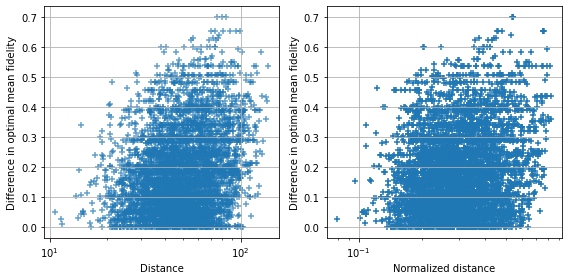

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))

axes[0].scatter(show_dist, show_fid_diff, marker='+')
axes[1].scatter(show_distnorm, show_fid_diff, marker='+')
axes[2].scatter(show_dist, show_expr_diff, marker='+')
axes[3].scatter(show_distnorm, show_exprf, marker='+')

axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Difference in optimal mean fidelity")
axes[1].set_xlabel("Normalized distance")
axes[1].set_ylabel("Difference in optimal mean fidelity")
axes[2].set_xlabel("Distance")
axes[2].set_ylabel("Difference in expressibility")
axes[3.set_xlabel("Normalized distance")
axes[3.set_ylabel("Difference in expressibility")

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2.set_xscale('log')
axes[3.set_xscale('log')     

axes[0].grid()
axes[1].grid()
axes[2.grid()
axes[3.grid()
     
fig.tight_layout()

In [12]:
num_qubits = 2
MAX_OP_NODES = 15
num_circuits = 100

encoding_length = (num_qubits + 1) * MAX_OP_NODES
bounds = np.array([[-.2] * encoding_length, [1.0] * encoding_length])

x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(num_circuits,encoding_length)
qc_list = [qc_embedding.enc_to_qc(num_qubits=num_qubits, encoding=x[i]) for i in range(len(x))]

In [13]:
expr_list = []
for qc in qc_list:
    expr_list.append(new_expressibility.get_expressibility(qc,num_samples=5000,num_bins=75))

In [14]:
expr_list = np.array(expr_list)

In [15]:
dist_mat = np.zeros(shape=(len(x),len(x)))
distnorm_mat = np.zeros(shape=(len(x),len(x)))

for i in range(len(qc_list)):
    for j in range(i+1,len(qc_list)):
        res = circuit_distance_POT(qc_list[i], qc_list[j])
        print(res)
        dist_mat[i,j] = res[0][0]
        distnorm_mat[i,j] = res[1][0]

([58.262259526419165], [0.39233844798935463])
([81.90589072884504], [0.653157023356021])
([63.32175224677205], [0.27025929255984654])
([50.772383942300635], [0.3077114178321251])
([39.82404514313768], [0.23207485514648996])
([64.27118194271408], [0.46371704143372344])
([39.47480242902191], [0.2256992706061859])
([44.41420327069677], [0.25394055615035316])
([30.42748197560949], [0.1617622646231233])
([39.6293086110005], [0.19686690815201444])
([54.62505273344593], [0.35219247410345544])
([30.793129369323598], [0.15297133318094186])
([45.72536882454405], [0.24743164948346344])
([52.834448348726816], [0.3202087778710716])
([67.55156662693219], [0.4652311751166129])
([68.99515126850142], [0.4751732181026268])
([54.973250481607224], [0.35443746280855715])
([46.32104229825466], [0.2648430091381055])
([46.251144383142375], [0.20611026908708724])
([47.82989190433562], [0.21960464602541607])
([58.51066017177983], [0.24625698725496561])
([67.57131501389505], [0.4875275253527781])
([42.4572181407

([57.58086003540476], [0.40578477826219])
([100.56168566334225], [0.5254006565482876])
([77.1399027411115], [0.47705567557892087])
([64.91838915876258], [0.42765737258736874])
([18.90347505060972], [0.19094419243040126])
([38.15565801212898], [0.312495151614488])
([22.561755570788506], [0.21365298835973964])
([40.48148690269814], [0.31454146777543235])
([50.15171301234075], [0.36184497122900977])
([68.47129822031135], [0.4510625706212869])
([68.19120974114392], [0.4305000614971208])
([116.3810438637312], [0.7197343467144786])
([44.45219685825284], [0.4810843815828229])
([54.715260380757705], [0.5526793977854314])
([27.828701668126044], [0.42164699497160674])
([57.71730502970953], [0.5641965301046874])
([55.64439287101902], [0.543933459149746])
([67.38749999999997], [0.5834415584415582])
([83.24903335986049], [0.6468456360517522])
([40.72303139866161], [0.4936125018019589])
([86.63415210566046], [0.6731480350090169])
([69.49211797073191], [0.6193593402026017])
([46.41794049819981], [0.5

([79.49954819415682], [0.3764183153132425])
([52.90400408386587], [0.2226599498479203])
([65.46046100997496], [0.2960672139754634])
([55.87952185513614], [0.21434415748038413])
([101.79749737189348], [0.5318573530401959])
([57.37655291092311], [0.23495721912744927])
([66.42636608767184], [0.28756002635355776])
([75.26806357612594], [0.3305580306373559])
([50.455202342463004], [0.18201732446775973])
([55.79555181888246], [0.2254365730055857])
([57.994217787701736], [0.24408340819739785])
([96.08594264842735], [0.5199455771018796])
([86.48640495898054], [0.4160000238527203])
([93.9139042715474], [0.49066825638217026])
([78.93911026906164], [0.3680145000888655])
([75.99244610361028], [0.3386472642763381])
([71.40450693363303], [0.30052401908094706])
([56.02137117655917], [0.2294077443757542])
([28.332572466200705], [0.20441971476335283])
([37.59312941341378], [0.3559955436876304])
([28.65743764260369], [0.20195516309093509])
([30.696295605505217], [0.21632343626148848])
([38.1531498745947

([58.711409559882306], [0.34214108135129545])
([33.437252958663024], [0.20678573258295008])
([20.587316133660615], [0.13562131840356134])
([44.754037502208035], [0.39887733959187194])
([27.558221891611545], [0.18557725179536394])
([51.66461850511315], [0.29539518870847997])
([40.174577232848904], [0.25362738152051073])
([83.03168864859491], [0.41935196287169146])
([35.52863421018305], [0.2760577638708862])
([65.16038013636104], [0.35901035887802224])
([53.9688586933876], [0.3206705804717029])
([49.001963542241924], [0.2969815972257086])
([91.51151850343368], [0.4266271258901337])
([59.42921356237307], [0.32158665347604476])
([55.54889397439236], [0.31760373913317524])
([39.598940922190124], [0.3243156504683876])
([29.7867111695506], [0.2051426389087507])
([34.918536501259524], [0.2713172999320864])
([32.42085571052418], [0.21357612457525807])
([42.93032887966057], [0.2654936850937574])
([51.39420233096601], [0.293849069931195])
([59.059129335600275], [0.32539465198677836])
([45.1147831

([54.199898132398594], [0.30989078406174153])
([51.53906758263448], [0.2946773446691508])
([34.981620825276885], [0.21200982318349626])
([32.041505435368755], [0.2065861085452531])
([51.46603206316333], [0.44559335119621934])
([22.77328579892178], [0.15002164557919484])
([51.10223830261769], [0.28676901404387034])
([36.15271314339131], [0.22357893100427528])
([73.97682311896612], [0.36749539552392513])
([39.88697411335807], [0.30217404631331873])
([58.16496174713483], [0.31474546399964737])
([42.090984296831955], [0.2452854562752445])
([37.17291410295614], [0.22087292990467106])
([80.20478557691726], [0.36824970420990477])
([64.27193405898758], [0.3416902395480467])
([46.67090807336724], [0.2619018410402202])
([37.05263649985518], [0.2954755701742838])
([31.929047914611598], [0.21501042366741815])
([27.417984447054774], [0.2077120033867786])
([28.027388294902412], [0.18070527591813287])
([41.738096779003456], [0.25295816229699064])
([52.63350820451101], [0.2953619989029798])
([57.95175

([25.902082396785566], [0.14809652599648696])
([68.74119924986545], [0.32047179137466414])
([51.67693878346584], [0.3559017822552744])
([49.825180815461025], [0.25164232735081327])
([40.28326998851701], [0.2179830627084254])
([39.430105653771065], [0.217245761177802])
([79.54582364694863], [0.3443542149218556])
([47.23941382089581], [0.23467170303475318])
([33.141088889059674], [0.17315093463458553])
([49.18036126698928], [0.35483666137798914])
([40.961602034952314], [0.2533185036175159])
([50.57373065480865], [0.3483039301295362])
([30.976801406602956], [0.18405704935592962])
([33.55474231201821], [0.18829821723915946])
([38.68673455865542], [0.20212504994072839])
([50.307978711194515], [0.25408070056158844])
([67.03222193328399], [0.42318321927578284])
([40.858561084410404], [0.19969971204501666])
([51.100303903490605], [0.27166562415465506])
([65.2013805382615], [0.38741164906869585])
([71.62737392445314], [0.4823392183464858])
([70.5446759908389], [0.4750483231706323])
([63.2964386

([72.69172871324157], [0.43191757999549363])
([71.91130395332097], [0.4539855047558142])
([29.65317486148196], [0.2808065801276701])
([44.35640179933683], [0.3446495866304338])
([19.571601336750717], [0.17443494952540747])
([49.157338337011396], [0.3633210520104316])
([60.08582253568707], [0.4138142047912333])
([67.77486571978623], [0.42787162701885245])
([76.66492310859417], [0.4646358976278434])
([51.60722644654898], [0.2743605871693194])
([61.59566091524715], [0.36598729004900266])
([75.71348135373925], [0.5098550932911734])
([69.79485550663689], [0.4699990269807198])
([62.61744481558319], [0.3953121516135302])
([55.57022242617031], [0.311841876690069])
([50.49027906202916], [0.22174035600364148])
([50.45868398441038], [0.2282165716165101])
([58.39983604422102], [0.24242356182740146])
([76.09233534261631], [0.536239149701313])
([45.9209730053003], [0.23585502313970363])
([47.532704107855665], [0.26673795795654137])
([63.85920479509275], [0.42067987348545943])
([43.98458919679043], [

([78.06914667854394], [0.4224520924163634])
([91.19737801025707], [0.44573498538737566])
([42.80643932670552], [0.4053640087756205])
([48.30316733525708], [0.30494423822763306])
([24.206960696595555], [0.17059168919376716])
([29.426541544670425], [0.254775251469008])
([38.603330371761096], [0.24889316809646092])
([29.238898093256164], [0.2605962396903401])
([85.51867551099113], [0.41797984120719023])
([32.62677752411255], [0.22992796000079313])
([46.548029169007215], [0.2938638205114092])
([34.37214176427105], [0.2893277926285442])
([45.972858550896525], [0.29640785654994534])
([96.89352544221045], [0.45877616213167827])
([26.790043400697833], [0.21363670973443247])
([43.13847915419915], [0.29049480911918624])
([34.44196566042725], [0.2372036202508764])
([22.675053940142583], [0.180821801755523])
([36.75342233546314], [0.3182114487918886])
([58.57051840530228], [0.3413200373269364])
([31.3441967172101], [0.24354465203737452])
([111.10140361936577], [0.5101074546343699])
([41.3897035511

([114.15822703017805], [0.5765567021726165])
([56.406523935010476], [0.42732215102280663])
([26.21438803436424], [0.29421310925212396])
([64.18595237791557], [0.43222863554151897])
([46.988448029998295], [0.365100606293693])
([96.97066017177976], [0.5342736097618719])
([66.91932342480311], [0.46087688309093044])
([42.16716273937318], [0.354942447301121])
([77.62596464753418], [0.5113699910904754])
([60.208494138913956], [0.43440471961698374])
([60.39860634413715], [0.4256420461179503])
([23.064232129067157], [0.23297204170774907])
([43.56764956009431], [0.3667310569031507])
([46.93207617556943], [0.3950511462590019])
([27.49891045734528], [0.33332012675570033])
([26.4709368919216], [0.24307563720772812])
([43.04218399778232], [0.34323910684036923])
([38.94243706406548], [0.3189388784935747])
([137.5388727025626], [0.6314916102046032])
([27.92112168503774], [0.28203153217209836])
([25.546818063031832], [0.29774846227309826])
([67.61388720195785], [0.44541427669273953])
([40.426429355470

([23.13022876665417], [0.16300372633301033])
([27.982300659428034], [0.17305071527166374])
([63.624828685750835], [0.3213375186149031])
([69.85318568372497], [0.35279386708952004])
([40.27450058577303], [0.29766814919270523])
([41.121724248684565], [0.32792443579493263])
([34.10445668738802], [0.2583670961165759])
([29.525617141659588], [0.1988257046576403])
([78.16063578541818], [0.3882793630671543])
([49.932930365206914], [0.2751125639956303])
([35.808429089672366], [0.27127597795206326])
([49.21958954653652], [0.281415606326681])
([49.674444200707214], [0.2840162618679657])
([41.49691522535315], [0.25149645591123115])
([22.68421892451502], [0.14625544116386213])
([48.41267161317061], [0.419157329984161])
([30.00399555650255], [0.19765477968710501])
([53.25964935024077], [0.2988756978127989])
([28.944969328712208], [0.17900413932413234])
([71.42330419209738], [0.3548102543074882])
([32.29985661312706], [0.24469588343278073])
([53.515741827958145], [0.28958734755388604])
([38.91096385

([57.932719992109284], [0.3026787878375616])
([80.82757679674063], [0.4621359450928567])
([57.96575954496746], [0.29275636133821953])
([44.09037761482993], [0.21207492840226042])
([58.071292212192], [0.2626471832301764])
([30.903697546432078], [0.13572111351090066])
([112.80758378773365], [0.6330391907280226])
([75.95567648462172], [0.3288124523143797])
([88.45521435512448], [0.41237862170221207])
([100.32810142212503], [0.5333764030947635])
([70.39220992658471], [0.30914453195689373])
([102.68770509831246], [0.5556693998826432])
([45.8601235441375], [0.16544056112603714])
([80.42595529158353], [0.3749461785155409])
([75.97143986241339], [0.3288806920450796])
([99.6651417983449], [0.5207165193225961])
([68.19170107948133], [0.2994804614821314])
([46.93315993184665], [0.16537406600368798])
([99.75117003586159], [0.5037937880599069])
([78.8468996405656], [0.356611938672843])
([84.19921300891582], [0.38658959140916355])
([90.62192925095154], [0.45768651136844213])
([102.06359074528014], [

([32.99532221147135], [0.17541372786534473])
([58.92137252715785], [0.4057945766333186])
([46.10798633762282], [0.2794423414401383])
([44.85751385424723], [0.2718637203287711])
([71.35877905428498], [0.554458267710062])
([49.6146267619958], [0.31988798686006314])
([42.76731385300436], [0.2492267707051536])
([45.43056366099301], [0.26993798966721927])
([103.37626135252071], [0.39157674754742694])
([55.75396682847686], [0.38398048779942745])
([68.29409456187915], [0.5173795042566602])
([46.04753400885547], [0.23256330307502762])
([43.12473674225317], [0.26136204086214043])
([40.902817389601], [0.24789586296727872])
([30.918300412536254], [0.17677701779609065])
([40.236903813292415], [0.2540208574071491])
([35.694625951507376], [0.20030654293775185])
([55.85619760869511], [0.26040185365359025])
([61.02373710234101], [0.2844929468640606])
([56.95981935131016], [0.37522937649084426])
([55.748311275296444], [0.3928704106786219])
([55.359273188132754], [0.3727897184386044])
([37.1852781285957

([24.21684810602898], [0.22932621312527443])
([73.37116720872132], [0.46320181318637205])
([61.183300858899095], [0.4213725954469635])
([58.009518072878905], [0.4088056241922403])
([104.1191822317897], [0.5439873679821823])
([73.71439881611762], [0.45587135940703544])
([60.021041717894065], [0.39539553173843256])
([18.684517915974023], [0.18873250420175783])
([42.271916789329325], [0.3462073447119519])
([24.087945142548836], [0.22810554112262157])
([39.32529338007423], [0.3055578351210119])
([56.557353480745306], [0.40806171342529085])
([62.99277163845378], [0.4149721451808549])
([73.67179779060449], [0.46509973352654355])
([54.46133017924189], [0.402522765552416])
([76.09632123890276], [0.33419552586255047])
([32.148934381891365], [0.19484202655691737])
([40.456461222760375], [0.22290061279757784])
([58.6001895142948], [0.4129682136313939])
([23.16594539882588], [0.1299996935961048])
([80.58969451132005], [0.34395943026598397])
([44.34930085889912], [0.2986484906323173])
([37.11909380

([89.63912125214905], [0.42442765744388755])
([116.36041608372686], [0.665296832954413])
([99.3023309523313], [0.4933051711491867])
([82.86649298394666], [0.38047058303005804])
([92.72655809246845], [0.432291646118734])
([82.6733551654348], [0.266516296471421])
([103.63392028397071], [0.5414520391012053])
([116.29808472707737], [0.6526267380868539])
([72.38514693085362], [0.2964174730993187])
([96.02750030354528], [0.4546756643160287])
([90.33747969070087], [0.4277342788385457])
([87.1214575488713], [0.3940364430071067])
([98.63225170100793], [0.48207356647608957])
([90.22126207893996], [0.40205553511114056])
([63.237190815431376], [0.24256689994411723])
([57.26107429931339], [0.21964355312356496])
([91.65949263585776], [0.46292673048413])
([105.27394917844641], [0.5596701179077427])
([103.19555689973971], [0.5300234047238814])
([87.12898745444743], [0.412542554235073])
([52.096606715339554], [0.1973356314974983])
([72.06597570828515], [0.29511046563589327])
([103.51545094915024], [0.5

([110.18510340559432], [0.5564904212403754])
([28.688746985600297], [0.25569293213547506])
([46.07663843400941], [0.3405516513969653])
([52.29884789397535], [0.39620339313617686])
([25.489045313896263], [0.22717509192420915])
([28.84788546887915], [0.281993015336062])
([72.27086785058547], [0.45625547885470635])
([22.723096996444877], [0.1967367705319903])
([119.81913692263963], [0.5856262801693043])
([56.02179356167759], [0.4041976447451486])
([22.90311897309501], [0.23932203733641602])
([66.76098915822608], [0.4304383569195751])
([52.96938627542051], [0.39149583352121586])
([101.92729663653692], [0.5418782383654277])
([64.36012399082331], [0.42397973643493614])
([41.16828785740384], [0.32829575643862713])
([64.19007377555323], [0.4052403647446543])
([55.5356952114155], [0.38247723974804065])
([62.036524821970254], [0.4177543759055236])
([25.478754673584017], [0.24127608592409108])
([31.28476904692893], [0.24947981696115576])
([42.56928180378464], [0.3394679569679796])
([33.1578761365

([82.61175765251154], [0.35762665650437897])
([54.43425877005218], [0.20116134061364446])
([111.67650561262936], [0.554776480937056])
([70.18143029937588], [0.27619610507428527])
([72.93968645920597], [0.3027799354886093])
([87.74039793270175], [0.3692777690770276])
([42.63417531389433], [0.14849939154961453])
([61.13276323444236], [0.23750102266683124])
([65.3142299521329], [0.2638958785944764])
([103.79464238343952], [0.5331003717690782])
([85.6181904755831], [0.3931046394654872])
([105.20171958930356], [0.522611622400912])
([87.1064664727358], [0.3881749842813539])
([73.93790552469426], [0.3155693791066763])
([79.02269985881334], [0.3192836357931852])
([63.90424429679773], [0.2514925001841706])
([42.313389640281116], [0.29819161127752725])
([35.33483766184073], [0.25494110867128955])
([24.45929427672693], [0.2058863154606644])
([26.858527224615436], [0.24663477708554118])
([62.44063419223243], [0.3784280860135299])
([23.271478959351008], [0.19059360327068803])
([112.51855807963554],

([39.46752982944618], [0.23450701027597257])
([36.297575309919274], [0.22915135927979344])
([58.218451038478605], [0.4900543016706954])
([40.767739066021186], [0.26284809197950476])
([48.36552390973497], [0.26647671575611553])
([35.663141004353825], [0.2161402485112353])
([66.5974382593445], [0.325500675754372])
([39.727286240230725], [0.29362369726704163])
([46.68829526726197], [0.24820996952292387])
([36.629544318786586], [0.2094313568827135])
([34.06920269604803], [0.19853847724969714])
([83.79647522192292], [0.3789980787965759])
([61.412792854638404], [0.3208609867013501])
([50.580948067352715], [0.2786829094619984])
([50.225147313650155], [0.39024978487684664])
([36.30870484442776], [0.2391877789487995])
([42.53930978059305], [0.3144073154515377])
([34.72606987261178], [0.21923023909477138])
([43.81250021035456], [0.26032382775017565])
([56.86250111630859], [0.3132920171697443])
([62.729903496109635], [0.3334923099208381])
([29.300541536661363], [0.2690591509335295])
([66.09754544

([49.088779393757115], [0.26563192312639133])
([73.72500000000002], [0.5077479338842977])
([53.64754555734624], [0.2955787634013567])
([33.69533583661624], [0.16207472744885157])
([46.223399095645185], [0.24150156267317235])
([51.24809775049608], [0.22185323701513457])
([63.47913631646062], [0.39257350845059136])
([31.504076140700995], [0.1468721498400979])
([32.48486004305942], [0.16137536037287345])
([42.169250845935984], [0.21297601437341407])
([60.42234662524039], [0.24413069343531468])
([43.23973868602774], [0.19852956237845612])
([30.952518625947214], [0.14888176347256957])
([64.86270625024392], [0.4181992666037649])
([59.92854232065468], [0.33629933962208014])
([66.19842920371013], [0.40939040942306826])
([51.64895986452335], [0.2794857135526155])
([50.36197521376059], [0.2586644849191607])
([39.08815108529529], [0.18801419473446507])
([36.613711419209054], [0.17069329332964595])
([113.11143435875948], [0.5273260343065711])
([43.99845972546423], [0.2962859240772002])
([31.373294

([58.91496848465752], [0.2975503458821087])
([41.42840386252762], [0.22024669783374595])
([44.690717504037856], [0.3303083333631771])
([44.66042432748007], [0.28194712327954596])
([39.08987233042453], [0.2754747873884745])
([34.15509741262616], [0.20700059037955248])
([37.659002115105025], [0.21531733627847358])
([49.98199467879159], [0.2657203332205826])
([57.107572985094805], [0.29331059571183776])
([78.44716223080177], [0.5402697123333455])
([57.35756851487787], [0.4573968781090739])
([108.1001162850868], [0.6066224258422379])
([69.93277868974266], [0.4928314213512521])
([43.17240848034576], [0.37378708640992003])
([75.94083314619759], [0.5113860817925764])
([67.01941911926292], [0.4953393874298811])
([67.33753013054888], [0.485840765732676])
([31.156335981976035], [0.3255625494459356])
([36.66133640332312], [0.3174141679941396])
([41.24164953009252], [0.3570705587020998])
([21.09718314607113], [0.26637857507665574])
([32.95171988847162], [0.31204280197416306])
([53.72873837348252],

([76.17284520837968], [0.24820086415242648])
([97.75785950365443], [0.5197121717365999])
([110.6543372631262], [0.6326720255181602])
([53.06326112723858], [0.22027090546798916])
([75.93442409781005], [0.36524494515541156])
([75.90057277509203], [0.36508212013031277])
([71.60329109655495], [0.32875707574175833])
([87.76322962018332], [0.4359822633888889])
([66.74799188547472], [0.30189051056297933])
([42.37831037173025], [0.16463990043407248])
([39.528696223099594], [0.15356913839588032])
([94.78196813160913], [0.4868103139784753])
([98.04722177415948], [0.5305585593839799])
([91.48142489251246], [0.47795937770382696])
([86.61328615725029], [0.4166103230266969])
([56.387573398587556], [0.21629295511541066])
([63.226086266894825], [0.2624578093270852])
([96.44489538200425], [0.5038918254023211])
([64.03935291671887], [0.2733220354960259])
([65.80607014576792], [0.28086244193669624])
([78.56012090222174], [0.3500896653396691])
([81.6775373560907], [0.3807810599351548])
([105.6205219318655

([66.20299964324732], [0.4268407456044316])
([65.74853934490422], [0.3689592555830764])
([64.95015816160922], [0.4016707369301746])
([59.00644607002119], [0.31929895059535274])
([58.42004623099667], [0.30005159851564805])
([41.34176342066294], [0.19885408090746967])
([45.71231861166959], [0.2131110424786461])
([34.047336899220156], [0.18100657575342982])
([53.80942003395374], [0.3705882922448605])
([45.03215233737725], [0.27292213537804394])
([45.993332161634925], [0.2787474676462723])
([65.23782106536095], [0.5068983765762312])
([51.65857623496374], [0.333066255544576])
([40.05593238453538], [0.2334261793970593])
([45.973032328844305], [0.27316121407512955])
([101.50338178908324], [0.38448250677683043])
([58.399456157699206], [0.4022001112789202])
([61.53462471762267], [0.46617139937592933])
([44.3825112970413], [0.22415409745980452])
([32.573662102506376], [0.1974161339545841])
([45.57578152522886], [0.2762168577286597])
([34.09113303817245], [0.19491785613592025])
([48.6024607944588

([61.037109577968494], [0.33629261475464733])
([50.34476915141179], [0.29913707160672487])
([41.25676741258748], [0.2500410146217423])
([87.63714260079581], [0.40856476736967745])
([52.88919371452357], [0.2861969356846514])
([55.83933917810438], [0.31926437494628007])
([42.490254686011156], [0.3479955338739653])
([31.713045443475576], [0.2184094038806858])
([40.055895528522235], [0.31123461949123726])
([34.33725181031843], [0.22620060481105683])
([46.66191721869577], [0.2885709166276795])
([54.41102249422158], [0.3110978987662754])
([61.4223615241127], [0.3384152150088854])
([39.536535532680475], [0.36305358615868205])
([34.11583144179509], [0.2521495302423879])
([30.23372334353884], [0.19916813796797656])
([33.6595641987034], [0.22666373197780068])
([119.62896103067894], [0.48988108530171554])
([45.88383377541521], [0.36589979087252966])
([53.19624582749241], [0.47411983803469177])
([63.56979839098082], [0.35673287537026277])
([30.279476283088655], [0.20853633803780067])
([30.55012426

([117.07707535013598], [0.47303868828337764])
([48.915728745429654], [0.3800755924275809])
([53.101447498012156], [0.45975279219058146])
([47.70985138392574], [0.26286419495275887])
([25.490359254892013], [0.17165225087469368])
([24.66049982493232], [0.16606397188506608])
([38.86043570618866], [0.24533103349866578])
([28.69863389233703], [0.2022454819755957])
([30.05917246228625], [0.18589469673646414])
([65.5728384685886], [0.33117595186155857])
([63.68737894891988], [0.32165342903494887])
([38.09649453158018], [0.2815705434706591])
([36.14845383941185], [0.2882651821324709])
([36.48586049402424], [0.2764080340456382])
([30.07308568614279], [0.20251236152284707])
([72.34633621429948], [0.35939560960903866])
([60.63465177582968], [0.33407521639575577])
([34.03791047812492], [0.25786295816761307])
([47.06177071752729], [0.2690781630504705])
([54.226837639030215], [0.3100448121156673])
([37.19272609716739], [0.22541046119495387])
([31.83281544526716], [0.2052405895890855])
([52.241261441

([49.99957911527004], [0.25252312684479816])
([69.30002348522918], [0.28000009488981487])
([36.278818468061495], [0.16656941445390955])
([29.686093608499704], [0.14279025304713663])
([67.92707179743046], [0.4379566202284363])
([54.223637993131746], [0.30428528615674383])
([69.39360033729577], [0.42915028037907094])
([49.067153516861026], [0.26551489998301425])
([45.495650006109436], [0.23367051877816866])
([46.407295386184316], [0.2232193140268606])
([33.441492836477565], [0.15590439550805393])
([24.60302572425294], [0.16944232592460698])
([29.084802150645032], [0.18752290232524196])
([27.16773771158395], [0.19601542360450178])
([29.575130881432997], [0.18671168485753153])
([67.80051672430997], [0.34823069709455556])
([70.42006260779264], [0.3616849646008867])
([37.807256707662056], [0.28641861142168223])
([40.79828723572125], [0.33413830659886357])
([31.76441018454071], [0.2468097139435953])
([28.491054883424226], [0.19621938624947816])
([78.59652555000265], [0.39695214924243766])
([5

([81.60222268454072], [0.4579249308896786])
([71.99020718841429], [0.3697493949071099])
([47.90949254781485], [0.1935737072638984])
([41.538079323771434], [0.18242459079390175])
([85.05699239438914], [0.47731196629848])
([51.15734437060029], [0.23137650099773988])
([59.06566860782325], [0.267144588909196])
([62.67477659369423], [0.2967555709928704])
([69.98918044341076], [0.3476859435837593])
([93.3975972358453], [0.5775980039322528])
([62.260239946935414], [0.3144456562976536])
([45.59102948607899], [0.20316858059749993])
([62.58998291689915], [0.3010581188884038])
([50.793102963559704], [0.20522465843862506])
([88.58462190653118], [0.4971078670400179])
([46.29728889712054], [0.20042116405679886])
([53.0028856243271], [0.2433557650336414])
([58.86926066547917], [0.27444876767123155])
([54.05173780702305], [0.20474143108720852])
([47.546719957196714], [0.20293094305248277])
([50.31299031876953], [0.22421118680378574])
([82.15506457188266], [0.47875911755176376])
([73.22414825010432], [

([85.2877444428531], [0.4876371894960155])
([79.39665788611451], [0.400993221647043])
([80.58467955339177], [0.44399272481207586])
([72.63442434279202], [0.3550069615972239])
([72.23325025750523], [0.33675174945223885])
([65.11515544781155], [0.2859690621335597])
([61.23953889128788], [0.2613723384177886])
([71.9200875862974], [0.4447748150049312])
([33.27796891983634], [0.1626489194517905])
([47.46166549530686], [0.23197294963493087])
([38.67319319537694], [0.19862965174821232])
([53.54732915522565], [0.2897582746494894])
([74.88118210364541], [0.5157106205485221])
([54.528369039931775], [0.3004317853439767])
([36.98585566749784], [0.17790214366280824])
([53.40686473064657], [0.2790327310901074])
([59.5988393082704], [0.25800363336913595])
([70.86771431968997], [0.4382666315379713])
([43.045561884967796], [0.20067861018633004])
([38.680809758764866], [0.19215504102714787])
([52.11546737122762], [0.26320943116781625])
([68.39095692186415], [0.2763270986741985])
([44.920925483076985], [

([47.204078641332], [0.246625280257743])
([39.278663193688175], [0.19197782597110544])
([39.52881791227511], [0.18716296359978746])
([63.26926654910313], [0.29957039085749587])
([45.97167894940718], [0.32397236750815495])
([43.76945502843105], [0.22480459696163868])
([39.441962225541765], [0.21731108664210338])
([32.298070020011515], [0.18124618417514882])
([79.95630813672821], [0.3511475983167686])
([50.534507785767495], [0.25522478679680555])
([34.4592636879436], [0.18319651083436253])
([48.79979013196739], [0.36067841930500666])
([37.57444516155652], [0.23721240632295784])
([46.82077498337484], [0.32995613096106297])
([27.85265705167453], [0.1688039821313608])
([33.35658385750562], [0.19071803234708762])
([51.86052941726327], [0.2757072270986883])
([49.86351324327471], [0.2561043309875435])
([84.63548688709176], [0.46631122251841195])
([46.50520736162953], [0.19848573351100957])
([55.307335055571166], [0.25014624629385424])
([55.04133538511099], [0.2527150384991322])
([48.4425537255

In [16]:
expr_diff_mat = abs(expr_list[:,None] - expr_list)
show_expr_diff = []
show_dist = []
show_distnorm = []

for i in range(len(qc_list)):
    for j in range(i, len(qc_list)):
        show_expr_diff.append(expr_diff_mat[i,j])
        show_dist.append(dist_mat[i,j])
        show_distnorm.append(distnorm_mat[i,j])

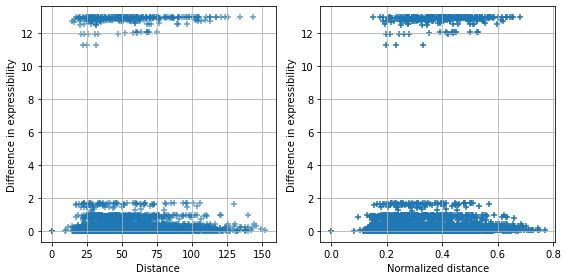

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].scatter(show_dist, show_expr_diff, marker='+', alpha=0.7)
axes[1].scatter(show_distnorm, show_expr_diff, marker='+')

axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Difference in expressibility")
axes[1].set_xlabel("Normalized distance")
axes[1].set_ylabel("Difference in expressibility")

#axes[0].set_xscale('log')
#axes[1].set_xscale('log')

axes[0].grid()
axes[1].grid()
fig.tight_layout()

In [20]:
show_expr_diff = np.array(show_expr_diff)

In [29]:
qc_list[11].draw()

┌──────────────┐┌───┐┌───┐┌──────────────┐             »
q_0: ───────■────────┤ Ry(theta[1]) ├┤ Y ├┤ X ├┤ Rz(theta[2]) ├──■────■───■─»
     ┌──────┴───────┐└──────┬───────┘└───┘└─┬─┘└──────────────┘┌─┴─┐┌─┴─┐ │ »
q_1: ┤ Rz(theta[0]) ├───────■───────────────■──────────────────┤ Y ├┤ Y ├─■─»
     └──────────────┘                                          └───┘└───┘   »
«     ┌──────────────┐┌───┐┌───┐┌──────────────┐
«q_0: ┤ Ry(theta[3]) ├┤ H ├┤ X ├┤ Rx(theta[4]) ├
«     └──────┬───────┘└───┘└───┘└──────────────┘
«q_1: ───────■──────────────────────────────────
«

In [25]:
expr_list

array([7.26423518e-03, 6.22301075e-02, 8.05204292e-02, 9.23576859e-03,
       5.50508206e-03, 5.30615427e-02, 1.04127504e-01, 1.83685906e-01,
       6.51584231e-03, 5.90965183e-03, 2.88440078e-02, 1.29524643e+01,
       4.58099731e-02, 1.05843753e-01, 8.83829548e-03, 6.55487560e-02,
       7.42381970e-02, 2.49101811e-02, 2.00595329e-02, 9.23713369e-03,
       4.02969838e-02, 6.55283137e-03, 1.29524643e+01, 8.94800065e-03,
       2.01739239e-01, 6.90708303e-03, 1.22828339e-02, 7.10077843e-02,
       1.53608340e-01, 7.91222393e-03, 9.49186956e-01, 1.00344267e+00,
       4.10823891e-02, 8.26790891e-03, 1.47999551e-02, 1.04530902e-02,
       8.60481927e-03, 7.86218342e-03, 8.71790799e-03, 8.20549237e-02,
       4.31467683e-01, 6.98585279e-03, 1.37843686e-02, 1.22952739e-01,
       8.87194944e-01, 7.10457024e-03, 8.95762063e-03, 9.12410959e-01,
       1.00394179e+00, 1.86450031e-01, 2.17126384e-01, 1.76083062e-02,
       5.76783251e-02, 2.26544445e-01, 3.76248877e-02, 3.25834285e-01,
      

In [24]:
np.where(show_expr_diff > 10)

(array([  11,   22,   60,  110,  121,  159,  208,  219,  257,  305,  316,
         354,  401,  412,  450,  496,  507,  545,  590,  601,  639,  683,
         694,  732,  775,  786,  824,  866,  877,  915,  956,  967, 1005,
        1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1057,
        1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068,
        1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079,
        1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090,
        1091, 1092, 1093, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102,
        1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113,
        1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124,
        1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1144, 1182,
        1231, 1269, 1317, 1355, 1402, 1440, 1486, 1524, 1569, 1607, 1651,
        1689, 1732, 1770, 1812, 1850, 1891, 1929, 1970, 1971, 1972, 1973,
        1974, 1975, 1976, 1977, 1978, 

In [21]:
show_expr_diff[show_expr_diff > 10]

array([12.94520011, 12.94520011, 12.94520011, 12.89023423, 12.89023423,
       12.89023423, 12.87194391, 12.87194391, 12.87194391, 12.94322857,
       12.94322857, 12.94322857, 12.94695926, 12.94695926, 12.94695926,
       12.8994028 , 12.8994028 , 12.8994028 , 12.84833684, 12.84833684,
       12.84833684, 12.76877843, 12.76877843, 12.76877843, 12.9459485 ,
       12.9459485 , 12.9459485 , 12.94655469, 12.94655469, 12.94655469,
       12.92362033, 12.92362033, 12.92362033, 12.90665437, 12.84662059,
       12.94362605, 12.88691558, 12.87822614, 12.92755416, 12.93240481,
       12.94322721, 12.91216736, 12.94591151, 12.94351634, 12.7507251 ,
       12.94555726, 12.94018151, 12.88145656, 12.798856  , 12.94455212,
       12.00327739, 11.94902167, 12.91138195, 12.94419643, 12.93766439,
       12.94201125, 12.94385952, 12.94460216, 12.94374643, 12.87040942,
       12.52099666, 12.94547849, 12.93867997, 12.8295116 , 12.0652694 ,
       12.94535977, 12.94350672, 12.04005338, 11.94852255, 12.76

In [35]:
qc = QuantumCircuit(4)
qc.h(0)
qc.draw()

┌───┐
q_0: ┤ H ├
     └───┘
q_1: ─────
          
q_2: ─────
          
q_3: ─────

In [36]:
if qc.str_dists is not None:
    print(qc.draw())

AttributeError: 'QuantumCircuit' object has no attribute 'str_dists'

In [33]:
qc.str_dists = np.array([[2,3],[4,5]])

In [38]:
qc.str_dists, qc.lmm_dists = np.array([[2,3],[4,5]]), np.array([[2,3],[4,6]])

In [39]:
qc.lmm_dists

array([[2, 3],
       [4, 6]])

In [37]:
max([])

ValueError: max() arg is an empty sequence